<style>
@import url(https://www.numfys.net/static/css/nbstyle.css);
</style>
<a href="https://www.numfys.net"><img class="logo" /></a>

# Neural Network From Scratch
### Modules - Modern
<section class="post-meta">
By Sondre Duna Lundemo, Jenny Lunde, Niels Henrik Aase, Thorvald M. Ballestad, Jon Andreas Støvneng and Brynjulf Owren.
</section>

Last edited: March 1st, 2021

---

This notebook will give an introduction to how a fully connected neural network is built, and how the different components work. Throughout the notebook, there will be code snippets for each component in the network, to easier see the connection between the equations and the implementations. Towards the end, all the components will be assembled into classes to make the code more functional and tidy. The problem is based on an excersice in the course TMA4320 - Introduction to Scientific Computation at NTNU.

#### _Remark_:
If you are unfamiliar with object-oriented programming, don't panic! The way in which classes are used in this notebook will be readily understood by someone with a bit of programming background; you can think of it being a practical way of collecting certain variables together with the functions you use to manipulate them. If you want to learn more you can for instance read more <a href="https://docs.python.org/3/tutorial/classes.html">here</a>.

# Problem Outline

The use of neural networks has had major impact on problems related to artificial intelligence. The general nature of the method makes it perform outstandingly well in a wide variety of tasks, ranging from useful applications such as image recognition and self-driving cars, to less useful applications in for example video games (where the usefulness of video games may be debated!). Another important example where neural networks may be used is to solve classification problems. These kinds of problems also arise in the physical sciences, thus the use of neural networks can in some cases also furnish insight in these fields, insight that is inaccessible if one limits oneself to the conventional methods used in numerical analysis. In a future notebook we will explore such a problem using the vast machinery provided in various Python packages for machine learning. In the present case however, we will implement the algorithms from scratch in order to provide insight into the mechanics of a neural network. 

Although the problem does not have to be classification of images, to make the workings of the network less abstract, we will frequently refer to the input of the network as being an _image_. What we picture, is that each pixel of the image has a scalar value associated to it, say representing a grayscale value. To avoid using matrices as representation of the input, we stack the rows of the image on top of each other to create an input vector, whose dimensions necessarily will be the product of the number of pixels in each direction of the image. In the case of binary classification, the label associated to each image is either $0$ or $1$, and it represents some kind of category. If for example the problem was to be able to say whether an image showed a wolf or a husky, we could translate it to $0$ representing the wolf category and $1$ the husky category.

# What Is an Artificial Neural Network?

An artificial neural network (ANN) is a set of functions that are put together to mimic a biological neural network [[1]](#Biological_net). Just as a biological neural network, an ANN consists of many neurons connected together to form a complex network. In an ANN, these neurons are structured in layers. The first is called the input layer, the last layer is called the output layer and between them there is a number of hidden layers$^1$. The number of hidden layers, also known as the depth of the network, will vary depending on the complexity of the problem one want to solve with the network. Each layer holds neurons, and the number of neurons vary from network to network, and it can also vary from layer to layer in a given network. 

<center>
    <img src="https://www.numfys.net/media/notebooks/images/fully_connected.PNG" alt="Fully Connected Neural Network" style="width: 500px;">
    <i>This figure is a visualization of the network made in this notebook. The network is fully connected, and the number of neurons is the same for all layers except the output layer.</i>
    <img src="https://www.numfys.net/media/notebooks/images/not_fully_connected.PNG" alt="Not fully Connected Neural Network" style="width: 500px;">
    <i>This figrue shows a more general neural network. The network is not fully connected, and the number of neurons vary form layer to layer.</i>
</center>

We will in this notebook consider an ANN in which the number of neurons in each layer is constant. More specifically, the network we will use is called ResNet, and was first mentioned in <a href = "https://arxiv.org/abs/1512.03385"> this report </a> by Kaiming He, Xiangyu Zhang, Shaoqing Ren and Jian Sun. For simplicity, the number of neurons will be equal to the dimension of the input. We will also restrict our focus to <em> fully connected neural networks</em>, that is, any neuron of the network is connected to all the neurons in the next layer. These simplifications are only made to make the overall structure simpler to implement and understand, but it is important to emphasise that choosing more complicated structures may enhance performance in real applications. For such purposes, using well documented and robust Python packages such as PyTorch or TensorFlow is undoubtedly easier and better than trying to implement the algorithms yourself.

Although the fully connected network is much simpler to implement, it is more computationally expensive than a network that is not fully connected. Another advantage of choosing a more complicated structure is that it allows for treating subsets of the data differently. In that way one can in a sense lead the network into the right path. Furthermore, more complicated structures allow for more complicated and non-linear connections between the neurons.

## Overiview of Variables
Throughout this notebook, a lot of variables will be introduced. Here is an overview of all of them. The variable names used in the code will be in $\texttt{teletypefont}$. 

$$
\begin{equation*}
    \begin{aligned}
        K = & \texttt{ num_layers} && \text{ Number of layers.} \\
        I = & \texttt{ num_images} && \text{ Number of images.}  \\
        d = & \texttt{ dimension} && \text{ Dimension of input data.} \\
        Y = & \texttt{ Y} && \text{ All output values, } y \text{, in a matrix of size [num layes + 1, num neurons]. } Y[0] \text{ is the input to the network.} \\ 
        W = & \texttt{ weight} &&\text{ All weights, } w \text{, in a matrix of size [num layers, num neurons, num neurons].} \\
        B = & \texttt{ bias_vec} &&\text{ All biases, } b \text{, in a matix for size [num layers, num neurons].} \\
        \mu = & \texttt{ mu}  &&\text{ Variable corresponding to a bias in the output layer.}\\
        \omega = & \texttt{ omega}  &&\text{ Variable corresponding to a weight in the output layer.}\\
        h = & \texttt{ steplength}  &&\text{ Steplength.} \\
        Z_i = & \texttt{ Z}  &&\text{ Output from last layer, the 'guess' of the network.} \\
        c_i = & \texttt{ c}  &&\text{ The correct value for an output.}\\
        \mathcal{J} = & \texttt{ cost_function}  &&\text{ The error/cost of the network.}\\
        U = & \texttt{ U}  &&\text{ Collection of all variables} W \text{, } b\text{, } \omega \text{ and } \mu \text{.}\\
        \sigma = & \texttt{ sigma}  &&\text{ Sigmoid function, but used generally as activation function.} \\
        \eta = & \texttt{ eta}  &&\text{ Projection function for output layer.} \\
        \sigma ' = & \texttt{ sigma_derivative}  &&\text{ The derivative of the activation function.} \\
        \eta ' = & \texttt{ eta_derivative}  &&\text{ The derivative of the projection function.} \\
    \end{aligned}
\end{equation*}
$$

Since what we end up with is essentially a collection of many variables that we want to manipulate in different ways, and in specific orders, it is convenient to gather these in a class. In this notebook, we have made three classes which we will call $\texttt{Network}$, $\texttt{Param}$ and $\texttt{Gradient_descent}$, and the content of the classes will be explained along the way. 

## How Does a Layer in the Network Work?

In the following, $k$ will denote the index of an arbitrary layer, $n$ an arbitrary neuron index and $i$ an arbitrary index for input vectors to the network. $K$ denotes the total number of layers and $N$ is the total number of nodes in each layer.

<center>
    <img src="https://www.numfys.net/media/notebooks/images/layer_in_nn_2.PNG" alt="A layer in the network" style="width: 250px;">
    <i>This figure shows how the previous layer is the input to a node in the current layer. The variable $k$ is the number of the current layer, and corresponds to the superscript of $y$. The subscript of $y$ is $n$, which tells us what neuron in the layer $y_n$ corresponds to.
    </i>
</center>

Each layer takes in input form the previous layer, except the first layer which takes in the input to the network. In a fully connected layer, each neuron takes the output from every neuron in the previous layer as input. In a neuron, every input is multiplied by an individual weight and then they are all summed up. A bias is added to the sum, and then the results is passed through an activation function before it is sent as output to the next layer together with the output form every other neuron in the same layer. Why is a neuron built up like this? As mentioned in the beginning, an ANN is made to mimic a biological neural network, and in a biological neural network different stimuli 'light up' different neurons, and the signal is passed on to specific neurons. In an ANN the output value from a neuron can be interpreted as if the neuron has been 'lit up' or not. Values close to 1 means 'lit up' while values close to 0 represent an inactive neuron$^2$. By denoting the inputs to the first layer by $y^{(0)}_n$, the weights to each input to the a neuron in the first layer $w_{0,n}^{(0)}$, the bias $b_0^{(0)}$ and the activation function $f$, the output of neuron $1$ will be 

$$
y^{(1)}_0 = y^{(0)}_0 + h f\big( w_{0,0}^{(0)} y^{(0)}_0 + w_{0,1}^{(0)} y^{(0)}_1 + w_{0,2}^{(0)} y^{(0)}_2 + \dots + w_{0,N-1}^{(0)} y^{(0)}_{N-1} + b_0^{(0)} \big) \text{.}
$$ 

$h$ is known as the steplength, and is a number between 0 and 1. It is the combination of the output value from each neuron in the previous layer and their corresponding weights that affect the sum in the present neuron. The bias can push the value up or down to effectively make a threshold for activation. After having transformed the input through the hidden layers, it is passed through an activation function which projects the output on a scalar between 0 and 1 in the case of binary classification. One example of an activation function is the sigmoid function: 

$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$ 

To simplify notation and calculations, matrices and vectors are used to compactly gather the weights and biases. Let the inputs to the first layer be the vector $y^{(0)}$, $W^{(0)}$ be a matrix with the weights in the first layer and $b^{(0)}$ be the biases in the first layer. $W$ consist of vectors with the weights from each neuron in the layer. The output from the first layer is then in matrix notation

$$
\begin{equation*}
    \begin{aligned}
        \begin{bmatrix}
        y^{(1)}_0\\
        y^{(1)}_1\\
        \vdots \\
        y^{(1)}_{N-1}\\
        \end{bmatrix} =
        \begin{bmatrix}
        y^{(0)}_0\\
        y^{(0)}_1\\
        \vdots \\
        y^{(0)}_{N-1}\\
        \end{bmatrix}
        +
        h \sigma \left(
        \begin{bmatrix}
        w^{(0)}_{0,0} & w^{(0)}_{0,1} & \dots & w^{(0)}_{0,N-1} \\
        w^{(0)}_{1,0} & w^{(0)}_{1,1} & \dots & w^{(0)}_{1,N-1} \\
        &\vdots \\ 
        w^{(0)}_{N-1,0} & w^{(0)}_{N-1,1} & \dots & w^{(0)}_{N-1,N-1} \\
        \end{bmatrix}
        \begin{bmatrix}
        y^{(0)}_0\\
        y^{(0)}_1\\
        \vdots \\
        y^{(0)}_{N-1}\\
        \end{bmatrix}
        +
        \begin{bmatrix}
        b^{(0)}_0\\
        b^{(0)}_1\\
        \vdots \\
        b^{(0)}_{N-1}\\
        \end{bmatrix}
        \right)
        \text{,}
    \end{aligned}
\end{equation*}
$$
or written more compactly

$$
y^{(1)} = y^{(0)} + h \sigma \left(W^{(0)}y^{(0)} + b^{(0)}\right) \text{,}
$$

where the sigmoid function$^3$, $\sigma$, is applied elementwise. In a fully connect neural network every neuron in one layer is connected to every neuron in the next layer, and the matrix equation above gives the output of each hidden layer in the network. It is convenient for computational purposes to send every input-vector through the transformation simultaneously. In our notation, this amounts to 

\begin{equation}
    \mathbf{Y}_{k} = \mathbf{Y}_{k-1} + h \sigma \left( W_{k-1} \mathbf{Y}_{k-1} + b_{k-1}\right).
\end{equation}

## Activation Functions
Activation functions are what differentiate a neural network from linear regression. Without processing the output from each layer through a non-linear activation function, it would always be possible to make a single layer that is equal to the sum of any other set of layer of the same size, and the depth of the network would be insignificant. With the use of activation functions, it is possible for the network to make non-linear connections between the input and the output. Another aspect of the activation function is that it becomes more clear whether the neuron is active or inactive. One could think that the best way to show this would be a binary activation function that outputs 1 if it is active and 0 else, but then the gradient of the function will be ill-defined. It will become clear that this is very unfortunate when we discuss _training_ of the network, where the gradient of the activation function plays a crucial role. There are many choices for activation functions, some of the most well known are sigmoid function, hyperbolic tangent and the ReLU function.

### Sigmoid
The sigmoid function is a well known activation function, and it outputs values between 0 and 1. It is a continuous function and makes gradient calculations simple. One downside with this function is what is called 'vanishing gradients'. That is, when the absolute value of the input takes a large value, the gradient of the sigmoid function gets very small. As we will see later, the gradient of the activation function is an important part of the learning of the network, and vanishing gradients will make the network learn very slowly [[2]](#activation_functions). The function can also be used in the output layer.

In [1]:
# Packages:
import pickle  # Python object serialization.

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Library for statistical graphics.
from IPython.display import Image
from matplotlib import rc
from tqdm import tqdm  # Fancy progress meters.

# Setting common plotting parameters
fontsize = 22
newparams = {
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize,
    "lines.linewidth": 2,
    "lines.markersize": 7,
    "figure.figsize": (13, 7),
    "ytick.labelsize": fontsize,
    "xtick.labelsize": fontsize,
    "legend.fontsize": fontsize,
    "legend.handlelength": 1.5,
    "figure.titlesize": fontsize,
    "figure.dpi": 400,
    "text.usetex": True,
    "font.family": "sans-serif",
}
plt.rcParams.update(newparams)


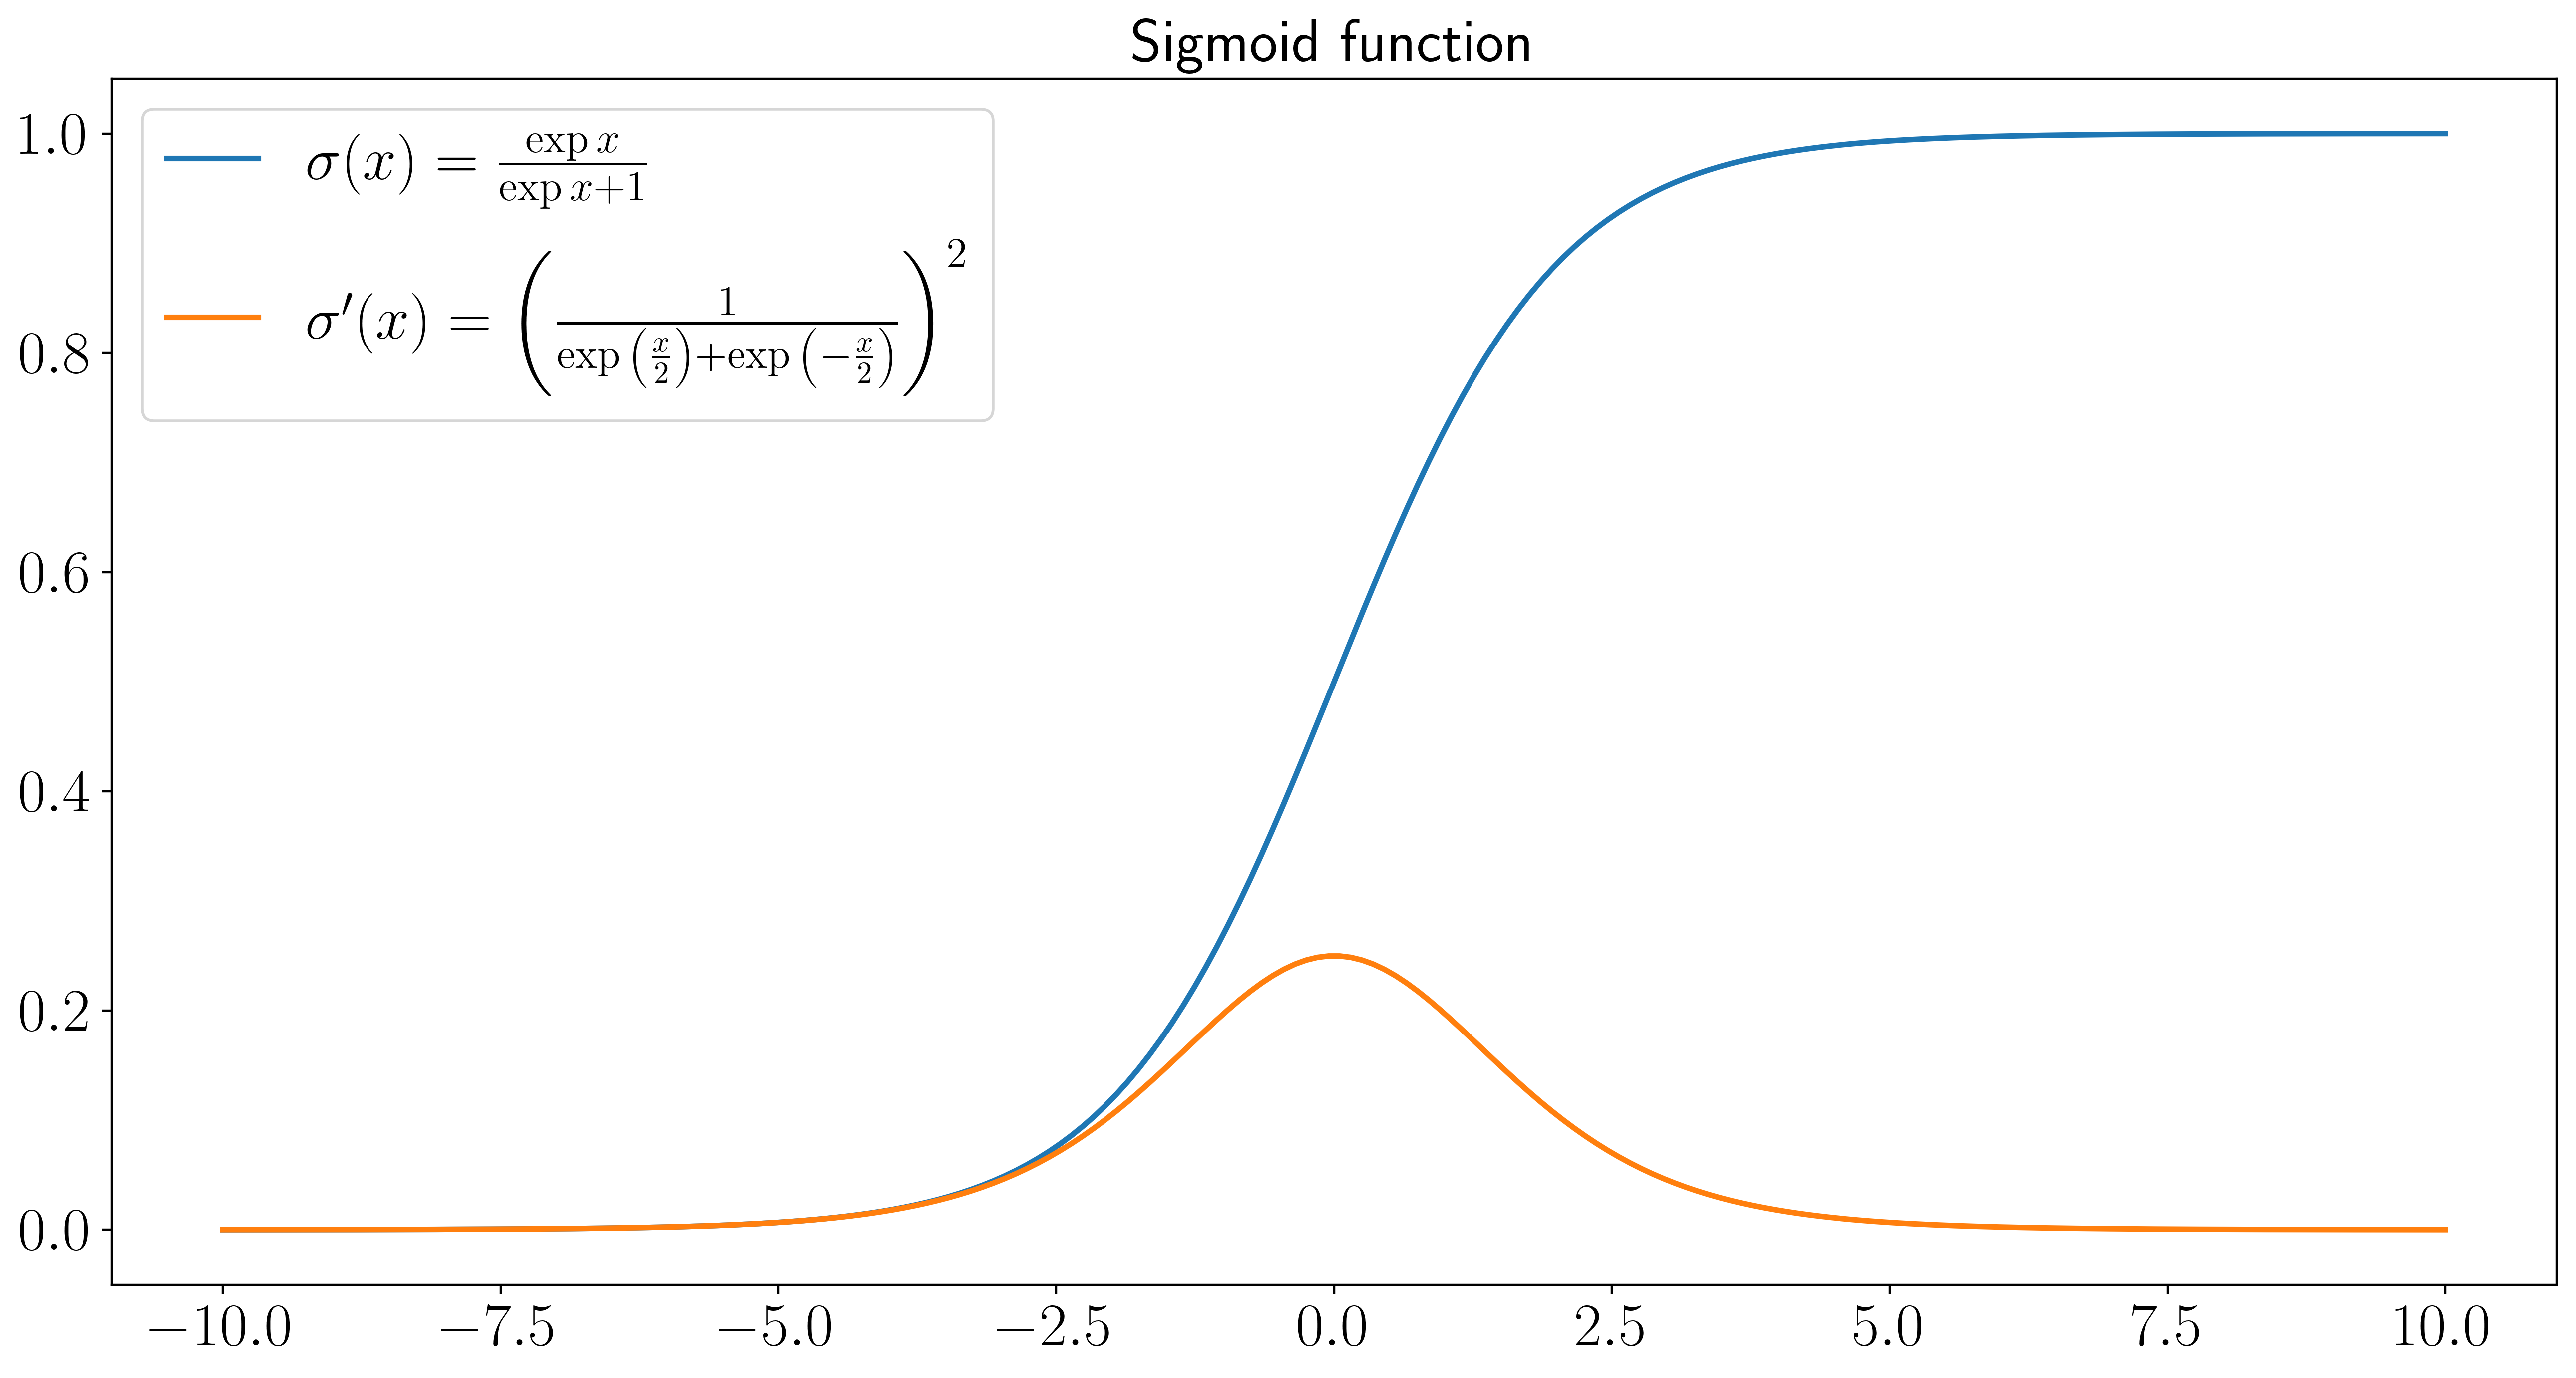

In [2]:
def sigmoid(x):
    return np.exp(x)/(np.exp(x) + 1)

def sigmoid_derivative(x):
    return 1/np.square(np.exp(x/2)+np.exp(-x/2))

x = np.linspace(-10,10,200)
plt.plot(x, sigmoid(x),label=r"$\sigma (x) = \frac{\exp{x}}{\exp{x} +1}$")
plt.plot(x, sigmoid_derivative(x),label=r"$\sigma '(x) = \left(\frac{1}{ \exp{\left(\frac{x}{2}\right)} + \exp{\left(-\frac{x}{2}\right)}}\right)^2$")
plt.title("Sigmoid function")

plt.tight_layout()
plt.legend()

plt.show()

### Hyberbolic Tangent
The shape of the hyperbolic tangent function is similar to the sigmoid function, but it takes values between $-1$ and $1$. According to [[3]](#ann_training), centering the values around 0 will make the network learn easier, and it often gives better results than the sigmoid function.

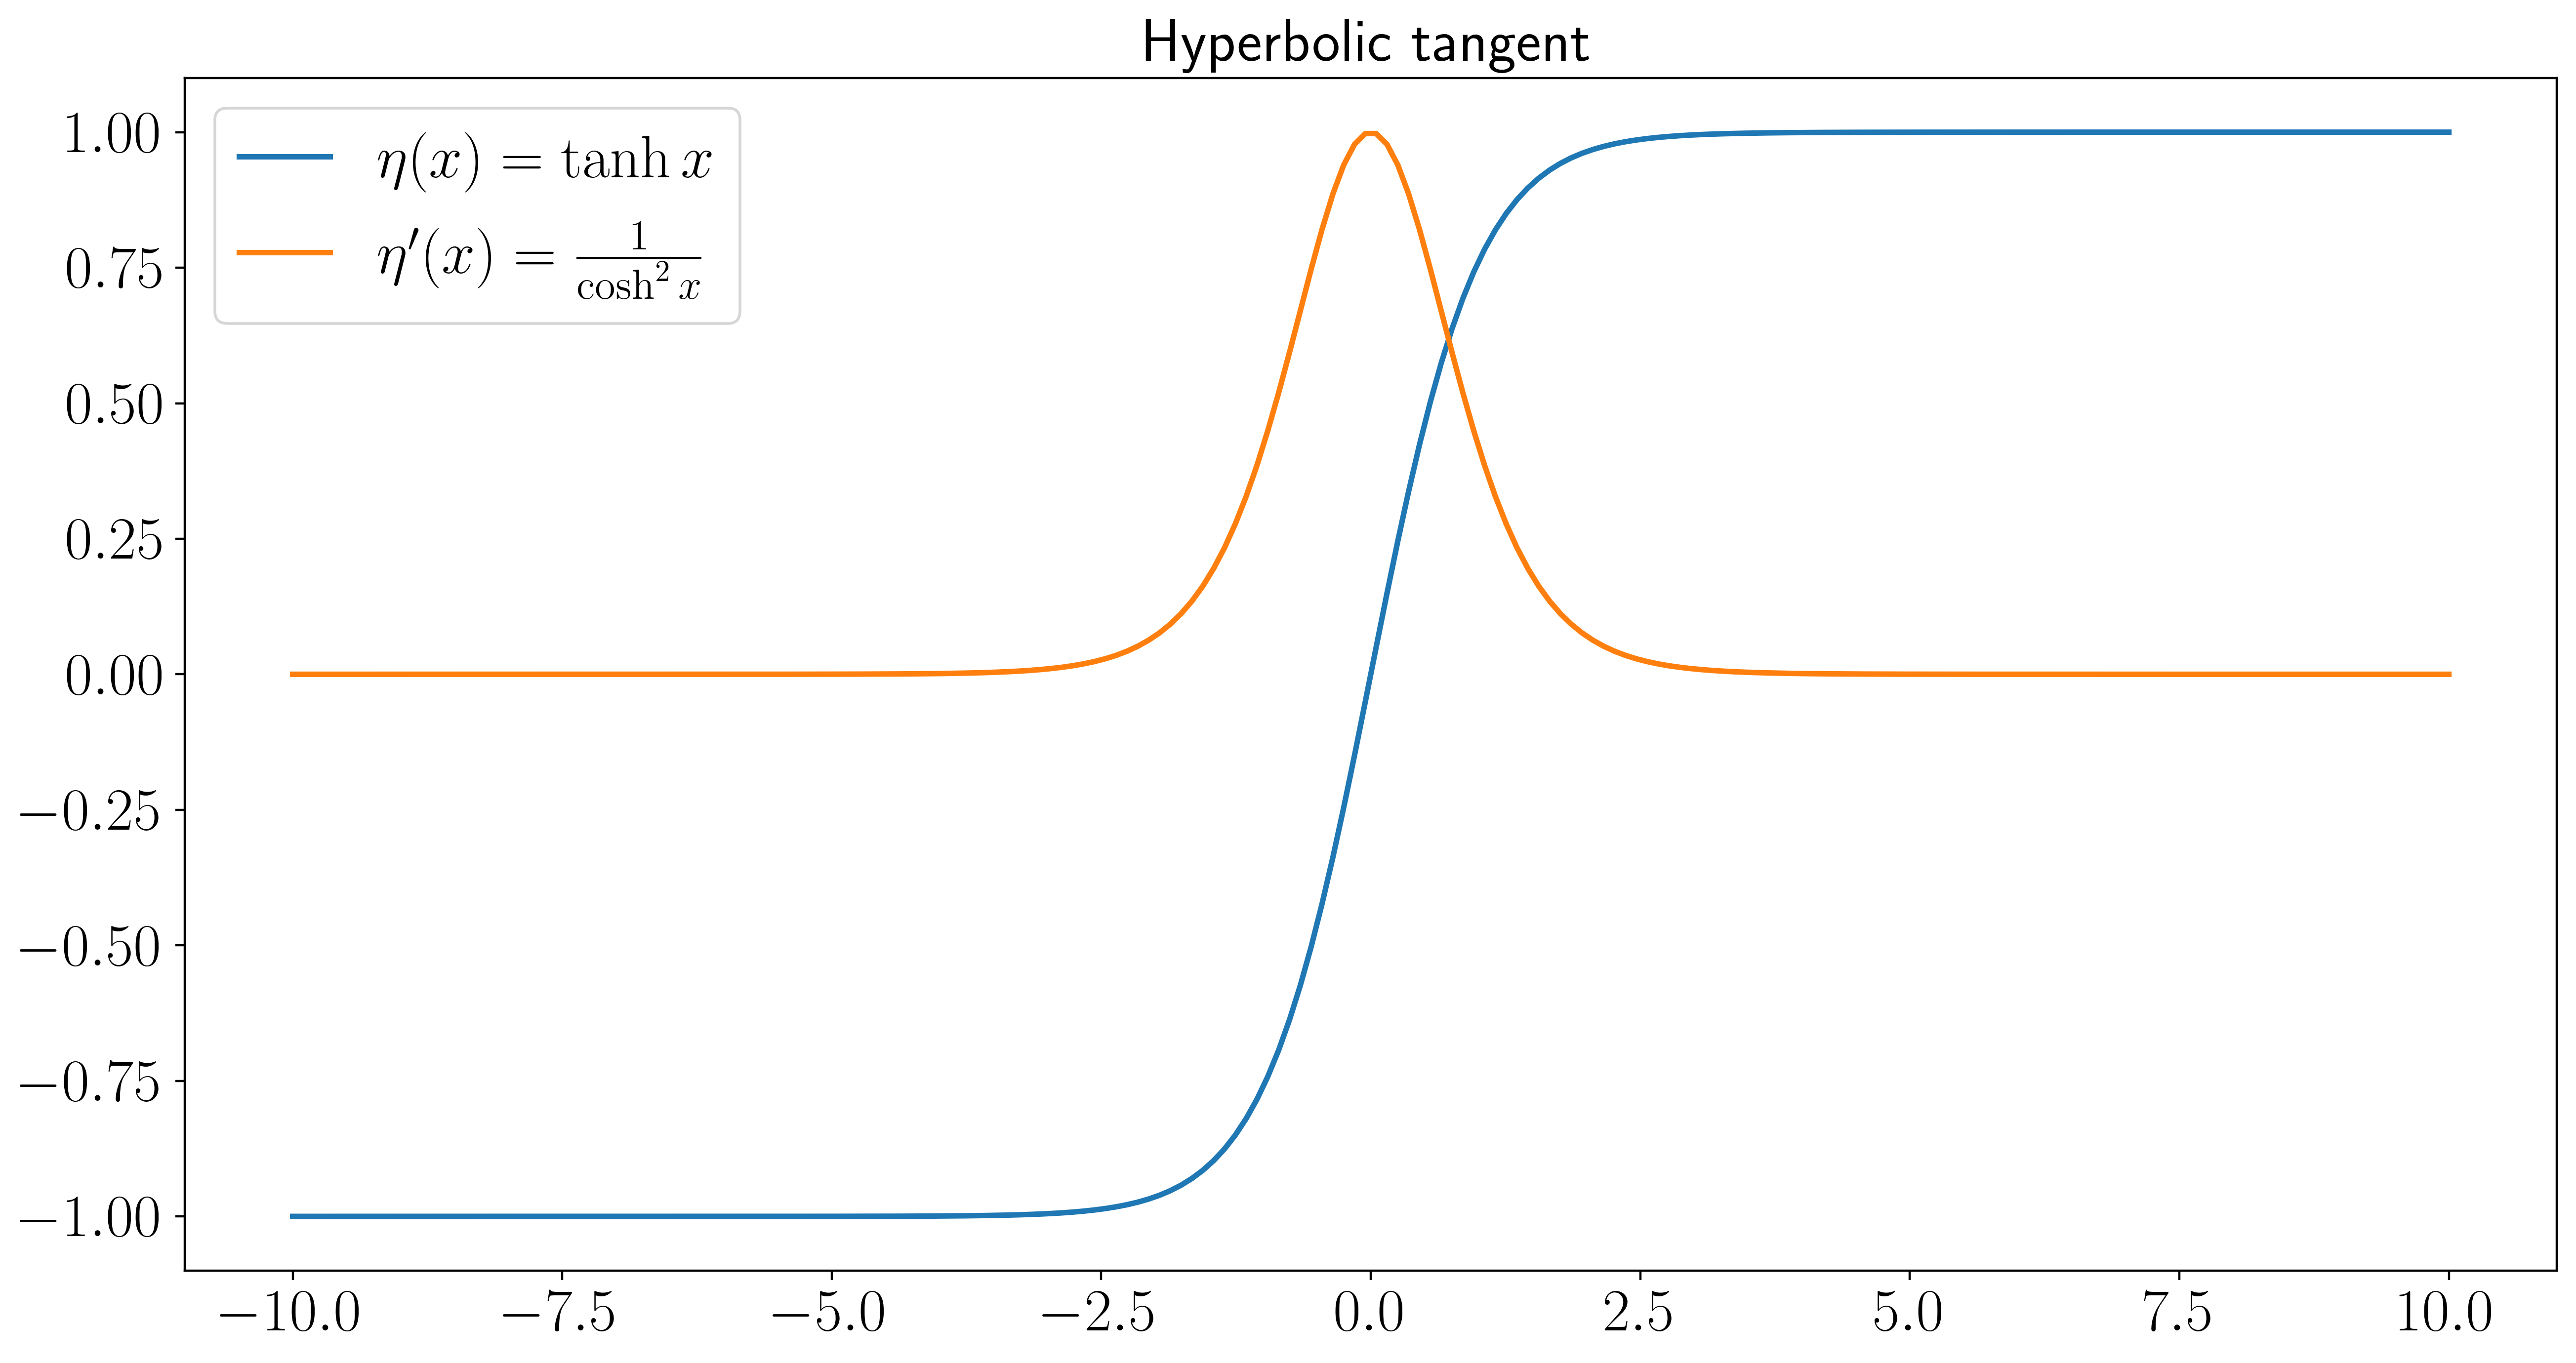

In [3]:
def tanh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

def tanh_derivative(x):
    return 4/np.square(np.exp(x)+np.exp(-x))

x = np.linspace(-10,10,200)
plt.plot(x, tanh(x),label=r"$\eta (x) = \tanh{x}$")
plt.plot(x, tanh_derivative(x),label=r"$\eta '(x) = \frac{1}{\cosh^2{x}}$")
plt.title("Hyperbolic tangent")

plt.tight_layout()
plt.legend()

plt.show()

### ReLU
ReLU is short for Rectified Linear Unit and is less computationally expensive than the sigmoid and hyperbolic tangent functions. It returns 0 if the input value is negative, and the value itself if the input value is positive. This function does not have an upper limit for the output values, but it shows clearly when a neuron is inactive. There exist versions of ReLU where not all negative values become zero, e.g. leaky ReLU which has a small linear slope on the negative side. For some problems it is beneficital to output zero for negative values because it shows clealy that the neuron is inactive, but some neurons can end up only outputting 0, and the neuron does not contribute to the network[[4]](#ReLU).

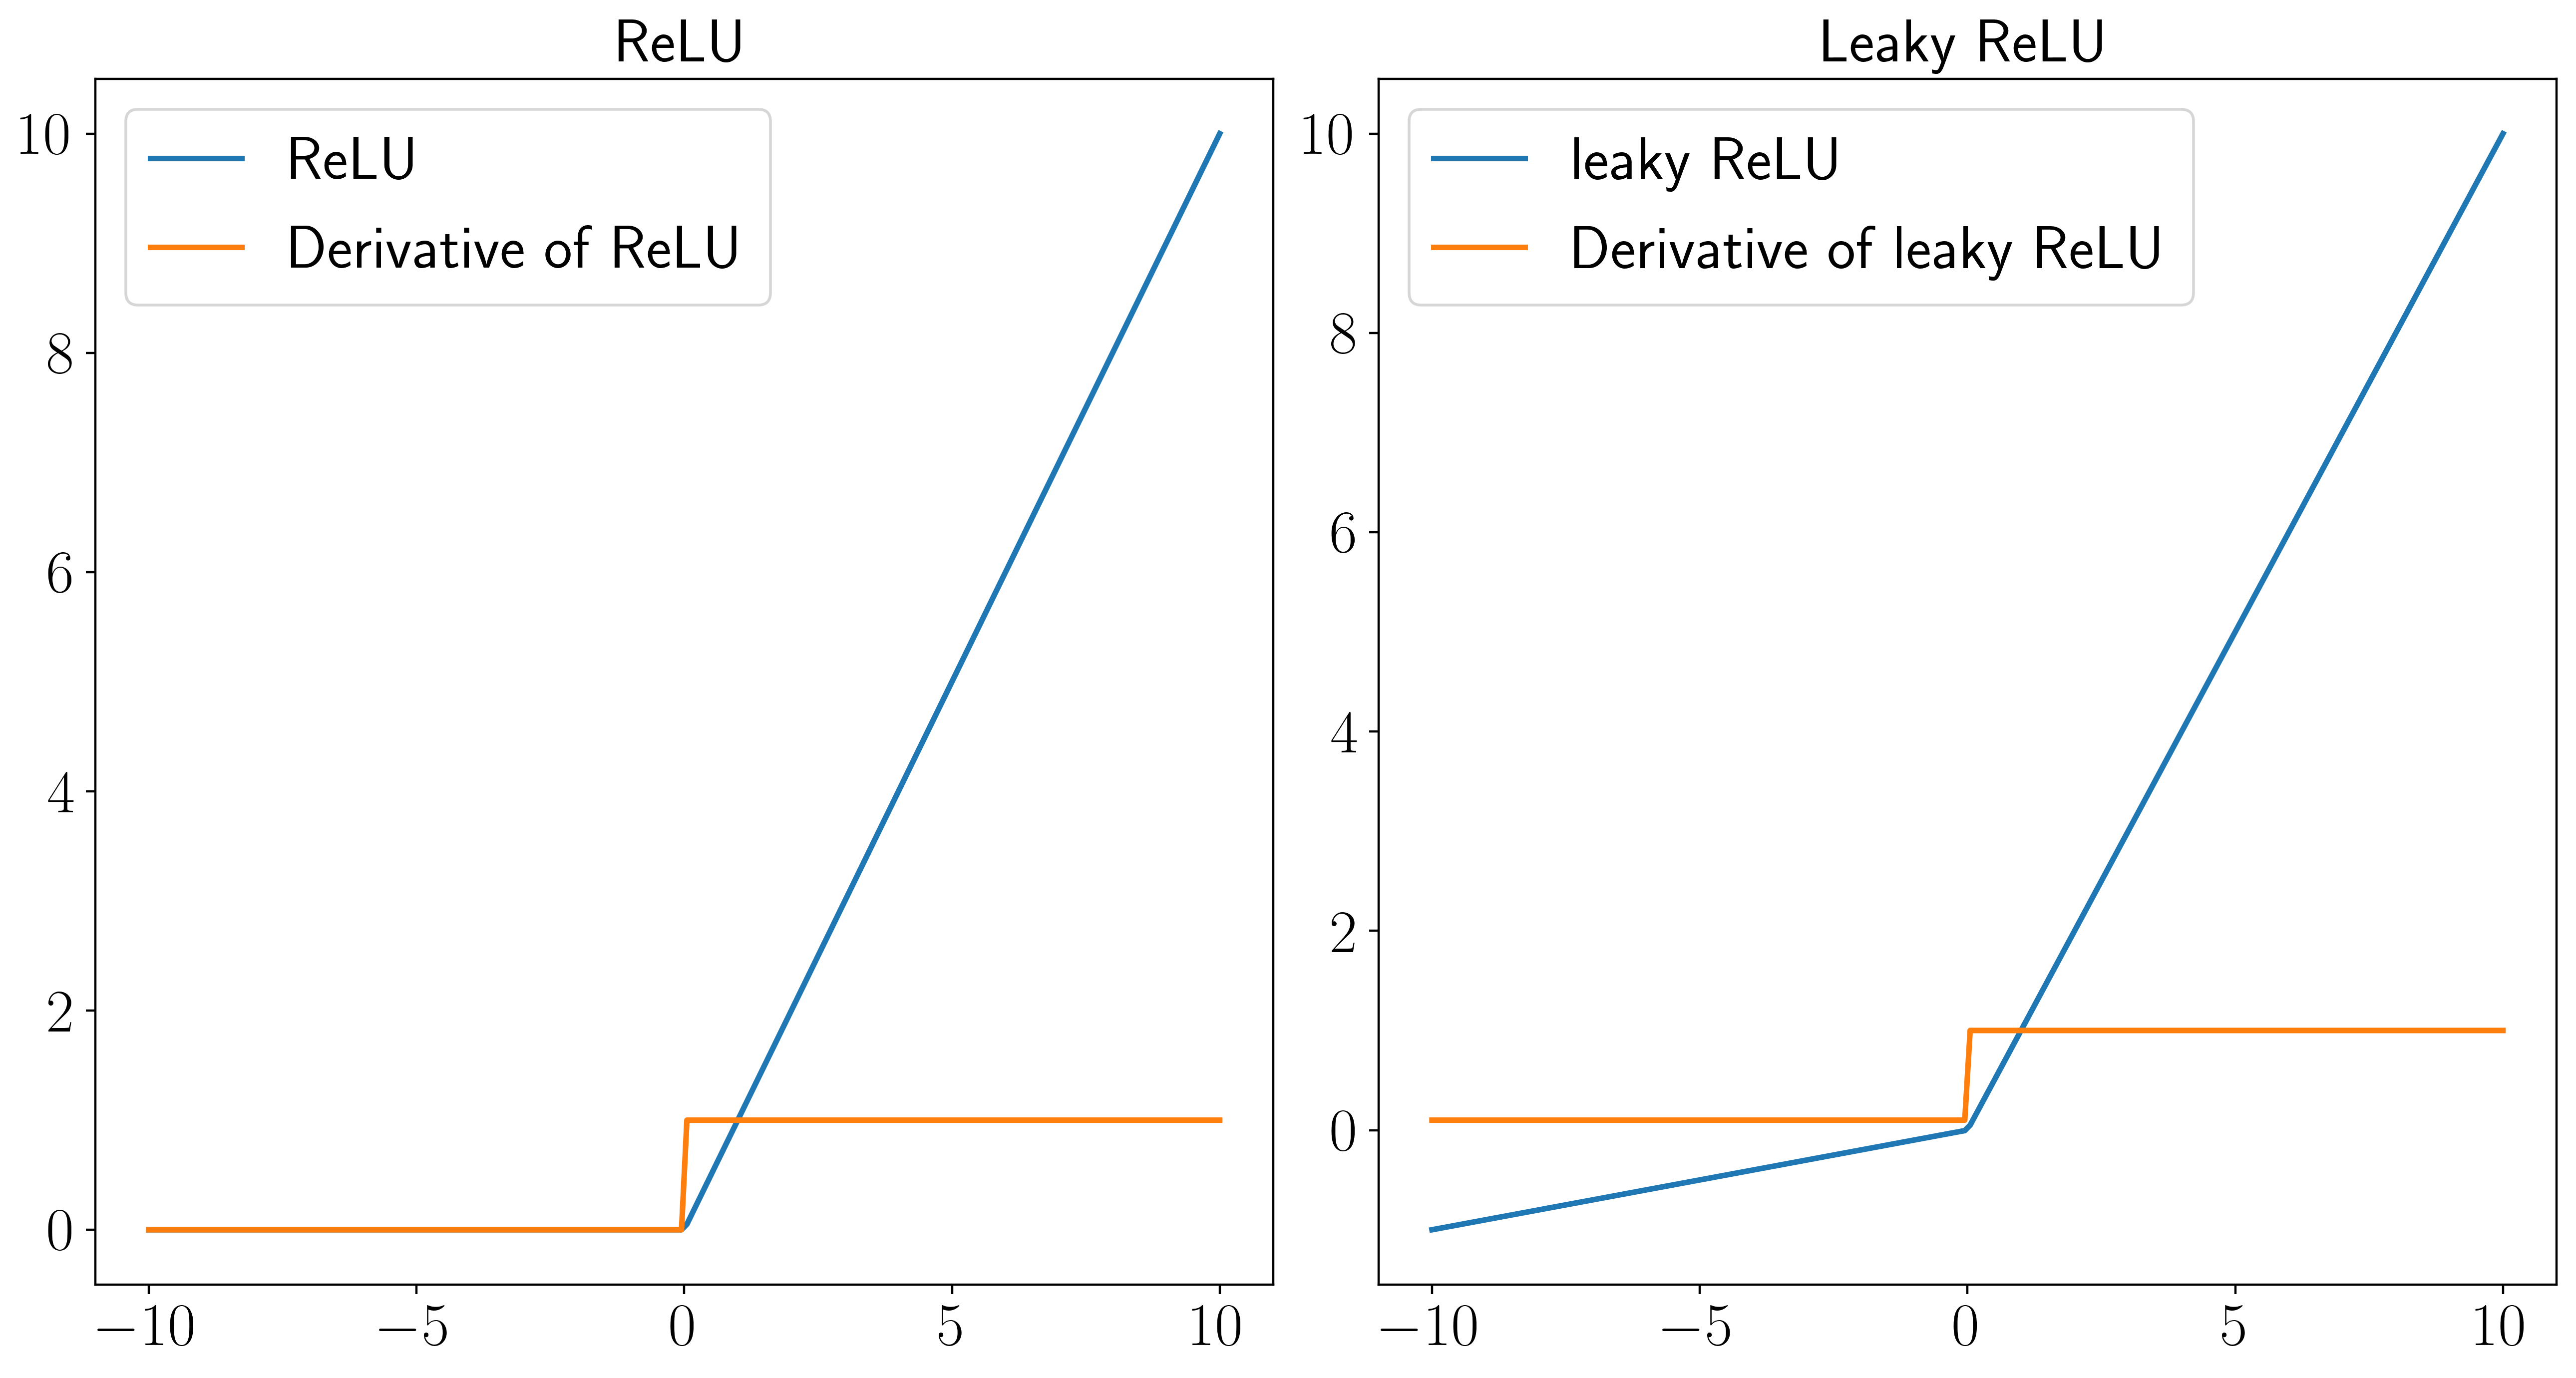

In [4]:
def ReLU(x):
    return np.maximum(0,x)

def leakyReLU(x, a):
    return np.maximum(x*a, x)

def ReLU_derivative(x):
    return np.heaviside(x,0)

def leakyReLU_derivative(x, a):
    return a + np.heaviside(x,0) * (1-a)

x = np.linspace(-10,10,200)

fig, axs = plt.subplots(1, 2)
axs[0].plot(x, ReLU(x), label = "ReLU")
axs[0].plot(x, ReLU_derivative(x), label = "Derivative of ReLU", ls = "-")
axs[1].plot(x, leakyReLU(x,0.1), label = "leaky ReLU")
axs[1].plot(x, leakyReLU_derivative(x, 0.1), label = "Derivative of leaky ReLU", ls = "-")
axs[0].legend()
axs[1].legend()
axs[0].set_title('ReLU')
axs[1].set_title('Leaky ReLU')

plt.tight_layout()
plt.show()

### Output Layer
The most important part of the output layer is to downscale the dimension of the input. In this notebook the problem is a binary classification problem and the desired output is a number between 0 and 1. For other problem types, the output can be e.g. a vector, or real numbers. While most of the network can stay the same for other problems, it is important to adapt the output layer to get the desired dimensions and values. A typical output layer is 

$$
Z = \eta (\mathbf{Y}_K^T \omega + \mu \mathbf{1}).
$$

Here $\omega$ is a vector and does the same job as the weights in a hidden layer. $\mu$ is a one dimensional vector (i.e. a scalar) and does the job of a bias, and $\mathbf{1}$ denotes the vector of the same dimension as $\omega$ containing only ones. $\eta$ is a scaling function. For the purpose of binary classification, $\eta$ normally outputs a decimal number between 0 and 1, and the sigmoid function is one of many functions that can be used. If it is desirable to output a vector, $\omega$ will be a matrix, $\mu$ will be a vector and $\eta$ will work elementwise. The output $Z$ is the guess of the network, and is implemented in the following way:

In [5]:
# Method belonging to Network class.
# self = Network
# U = Parameter belonging to Param class

def projection(self):
    self.Z = self.eta(Y[-1].T@self.U.omega + self.U.mu)

During training of the neural network, this value is compared to the true value, denoted $c$, to calculate the cost of the network. That is, how far off the guess was. When starting off, all the parameters are essentially free so we expect the guess to be close to random. To improve the guess, the idea is to change the weights, biases, $\omega$ and $\mu$ in such a way as to minimize the cost.

## How Is a Network Trained?
If the network is already trained, the network can make a decision by "eating" input data, processing it through the hidden layers and eventually through the output layer from which it yields a decision. Before this is possible, the network must be trained. Training a neural network, means that one adjusts each weight and bias to the problem you want to solve to make the decisions as precise as possible. This is done mainly in two steps: forward propagation and backwards propagation.

### Forward Propagation
In forward propagation one sends in input data and lets the network make a guess. In the beginning of the training, these guesses will be mostly random, since the weights and biases are not adapted to the dataset. The guess is made by simply sending the input data through all the layers.

In [6]:
# Method belonging to Network class.
# self = Network
# U = Parameter belonging to Param class

def forward_prop(self):
    for i in range(self.num_layers):
        self.Y[i+1,:,:] = self.steplength*self.sigma(self.U.weight[i,:,:]@self.Y[i,:,:] + self.U.bias_vec[i])

### Backward Propagation
When the guess has been made, the error between the guess and the true value is measured with a cost function. The goal of the next step will be to use the information about the error to improve the subsequent guesses. A normal choice for cost function, $\mathcal{J}$ , is the square deviation of the guesses and the true values

$$
\mathcal{J} = \frac{1}{2} \sum_{i=1}^{I} \vert Z_i - c_i \vert^2 = \frac{1}{2} \| \mathbf{Z} - \mathbf{c} \|^2.
$$

When regarding the input data $\mathbf{Y}_k$ as given, the cost function is just a function of the parameters of the network. For simplicity, we collect all the parameters in one variable called $\mathbf{U} = [(W_k,b_k)_{k=0}^{K-1},\omega,\mu]$. We want to find the values of the parameters $\mathbf{U}$ that minimise $\mathcal{J}$. Since $\mathcal{J}$ decreases fastest locally in the direction of $-\nabla J (\mathbf{U})$, we update our parameters according to a gradient descent algorithm, where one of the simplest algorithms is the iteration 

$$
\mathbf{U}^{(j+1)} = \mathbf{U}^{(j)} - \tau \nabla J (\mathbf{U}^{(j)}) \text{,}
$$

where $\tau$ is known as the learning parameter. This gradient descent method is called Plain Vanilla, and we will return to this method later. In the backward propagation, the gradient of the cost function with respect to all variables is calculated, and used to update the weights to minimize the cost of the network. 

In [7]:
# Method belonging to network
# self = Network

def calculate_cost(self):
    self.cost = 1/2*np.sum(np.square(self.Z-self.c))

### Calculation of Gradients

To find the parameters which minimise the cost $\mathcal{J}$, we use an iterative scheme involving the local gradient of the cost $\nabla \mathcal{J}(\mathbf{U}^{(j)})$. In the following, we will derive the simplest components of the gradient, and refer to the appendix for a derivation of the more complicated ones. The perhaps simplest is the one with respect to the scalar $\mu$ used in the output layer. By the chain rule,

\begin{align}
    \frac{\partial \mathcal{J}}{\partial \mu} = \sum_{i=1}^{I} \frac{\partial \mathcal{J}}{\partial Z_i} \frac{\partial Z_i}{\partial \mu} &= \sum_{i=1}^{I} [\eta'(\mathbf{Y}_K^T \omega + \mu \mathbf{1})]_i (Z_i-c_i) \\ &= \eta'(\mathbf{Y}_K^T \omega + \mu \mathbf{1})^T (\mathbf{Z}- \mathbf{c}).
\end{align}

Calculating the gradient with respect to $\mu$ is done in the following way.

In [8]:
# Method belonging to Parameters
# self = Param

def gradient_mu(self,network):
    first_factor = network.eta_derivative(network.Y[self.num_layers,:,:].T @ self.omega + self.mu * network.one).T
    second_factor = network.Z - network.c

    return first_factor @ second_factor 

Similarly, we have

\begin{align}
    \frac{\partial \mathcal{J}}{\partial \omega} &= \sum_{i=1}^{I}  \frac{\partial \mathcal{J}}{\partial Z_i} \frac{\partial Z_i}{\partial \omega} = \sum_{i=1}^{I} \sum_{j=1}^{d} (Z_i - c_i) [ \eta'(\mathbf{Y}_K^T \omega + \mu \mathbf{1})]_i \mathbf{Y}^T_{K,ij} \\
    &= \mathbf{Y}_K^T \left( \left( \mathbf{Z} - \mathbf{c} \right) \odot \eta'(\mathbf{Y}_K^T \omega + \mu \mathbf{1}) \right),
\end{align}

where we have introduced the Hadamard (element-wise) product $\odot$ defined by $(A \odot B)_{ij} = A_{ij} \cdot B_{ij}$. In numpy, we can calculate the Hadamard product of two arrays, $\texttt{X}$ and $\texttt{Y}$ (with the same shape), by using `np.multiply(X,Y)` or simply `X * Y`, wheras ordinary matrix multiplication is done with the `@`-operator, or `np.dot(,)`.

In [9]:
# Method belonging to Parameters
# self = Param

def gradient_omega(self,network):
    
    first_factor = network.Y[self.num_layers,:,:]
    second_factor = np.multiply((network.Z - network.c),network.eta_derivative(first_factor.T @ self.omega + self.mu * self.one))

    return first_factor @ second_factor

Calculating the gradient with respect to the bias and weights is a bit messier, so we only present the results here, and provide the details in the appendix. It turns out to be useful to calculate the gradient with respect to $\mathbf{Y}_k$ in order to get these gradients. We denote this by $\mathbf{P}$, and present the following identities connecting $\mathbf{P}$ of the last layer to the previous ones. 

\begin{equation}\label{eq:P_K}
\mathbf{P}_K = \frac{\partial \mathcal{J}}{\partial \mathbf{Y}_K} = \omega \otimes \left[(\mathbf{Z} - \mathbf{c}) \odot \eta'\left( \mathbf{Y}_{K} ^{T} \omega + \mu \mathbf{1}\right) \right]^T 
\end{equation}

\begin{equation}\label{eq:P_k-1}
\mathbf{P}_{k-1} = \frac{\partial \mathcal{J}}{\partial \mathbf{Y}_{k-1}} = \mathbf{P}_{k} + h W_{k-1}^{T} \cdot \left[ \sigma' \left(W_{k-1} \mathbf{Y}_{k-1} + b_{k-1} \right) \odot \mathbf{P}_{k}\right] 
\end{equation}

Here, the $\otimes$ denotes the outer product. Using these, we can express the gradient with respect to the weights and the biases as 

\begin{equation}
    \frac{\partial \mathcal{J}}{\partial W_k} = h \left( \mathbf{P}_{k+1} \odot \sigma' \left( W_k \mathbf{Y}_k + b_k \right) \right) \cdot \mathbf{Y}_{k}^{T},
\end{equation}

and 

\begin{equation}
    \frac{\partial \mathcal{J}}{\partial b_k} = h \left( \mathbf{P}_{k+1} \odot \sigma' \left( W_k \mathbf{Y}_k + b_k \right) \right) \cdot \mathbf{1}.
\end{equation}

Notice that calculating these requires to first calculate $\mathbf{P}_K$ based on $\mathbf{Y}_K$ which is obtained by the forward propagation. After this, one can calculate $\mathbf{P}_{k}$ for $k<K$, and all the components of $\mathbf{P}$ is required to calculate the gradients with respect to all the weights and biases.

In [10]:
# Method belonging to Parameters
# self = Param

def calculate_P_K(self,network):

    first_factor  = network.Z - network.c
    second_factor = network.eta_derivative((network.Y[self.num_layers,:,:]).T @ self.omega + self.mu * network.one) 
    third_factor = np.multiply(first_factor,second_factor)

    self.P[self.num_layers,:,:] =  np.outer(self.omega, third_factor.T)
        
def calculate_P(self,network):
    for k in range(self.num_layers,0,-1):
        first_factor  = network.steplength * self.weight[k-1,:,:].T 
        second_factor = np.multiply(network.sigma_derivative(self.weight[k-1,:,:] @ network.Y[k-1,:,:] + self.bias_vec[k-1]),self.P[k,:,:])

        self.P[k-1,:,:]  = self.P[k,:,:] + first_factor @ second_factor

In [11]:
# Method belonging to Parameters
# self = Param

def gradient_weight(self,network,index):

    first_factor  = network.steplength * np.multiply(self.P[index+1,:,:],network.sigma_derivative(self.weight[index,:,:] @ network.Y[index,:,:] + self.bias_vec[index]))
    second_factor = network.Y[index,:,:].T
    
    return first_factor @ second_factor 

def gradient_bias_vec(self,network,index):

    first_factor  = network.steplength * np.multiply(self.P[index+1,:,:],network.sigma_derivative(self.weight[index,:,:] @ network.Y[index,:,:] + self.bias_vec[index]))
    second_factor  = network.one

    return np.reshape(first_factor @ second_factor,(self.dimension,1))

### Initialization of Parameters
When initializing the parameters $\mathbf{U}$ in the network, one could naively think that a simple choice is to initialize all parameters to zero by using `np.zeros()`, but this is not a good choice. If all values of the weights are zero, the gradient will be equal to one for all weights, and the gradient will continue being equal for all weights, and the network will work only as good as a linear model [[5]](#initialization_of_weights). There are many ways to improve the model by initializing the parameters in a way that enhance learning, but we will keep it simple, and initialize the parameters using a normal distribution. In the following cell we have made a class for all the parameters in $\mathbf{U}$, and their gradients.

In [12]:
class Param(object):
    """Parameters of neural network.
    
    Initializes the parameters to random numbers.

    Parameters
    ----------

    K : int
        number of layers
    d : int
        dimension of input 'images'
    I : int
        number of input input 'images'
    
    Attributes
    ----------
    
    num_layers : int
        number of layers in total
    dimension  : int
        dimension of input 'image'
    num_images : int
        number of input images 
        
    mu         : float
        mu in projection/output layer
    omega      : np.array
        omega in projection/output layer. shape: dimension x 1
    weight     : np.array
        weights. shape : num_layers x dimension x dimension
    bias_vec   : np.array
        bias. shape: num_layers x dimension x num_images   
    P          : np.array
        P-matrix. shape: num_layers + 1 x dimension x num_images
    """
    
    def __init__(self,K,d,I):
        self.num_layers = K
        self.dimension  = d
        self.num_images = I
        
        self.mu         =  np.random.normal()
        self.omega      =  np.random.randn(self.dimension,1)
        self.weight     =  np.random.randn(self.num_layers,self.dimension,self.dimension)
        self.bias_vec   =  np.random.randn(self.num_layers,self.dimension,1)
        
        self.P          =  np.zeros((self.num_layers+1,self.dimension,self.num_images))
        
    def gradient_mu(self,network):
        """Calculates the gradient with respect to mu
        
        Parameters
        ----------
            network : Network
                The network of which this instance is a member
        Returns
        -------
            _ : float
                The gradient with respect to mu
        """
        
        first_factor = network.eta_derivative(network.Y[self.num_layers,:,:].T @ self.omega + 
                                              self.mu * network.one).T
        second_factor = network.Z - network.c
    
        return first_factor @ second_factor 
    
    def gradient_omega(self,network):
        """Calculates the gradient with respect to omega
        
        Parameters
        ----------
            network : Network
                The network of which this instance is a member
        Returns
        -------
            _ : np.array
                The gradient with respect to omega
        """
    
        first_factor = network.Y[self.num_layers,:,:]
        second_factor = np.multiply((network.Z - network.c),
                                    network.eta_derivative(first_factor.T @ self.omega + self.mu * network.one)) 

        return first_factor @ second_factor
    
    def calculate_P_K(self,network):
        """Calculates P_K
        
        Parameters
        ----------
            network : Network
                The network of which this instance is a member
        """
    
        first_factor  = network.Z - network.c
        second_factor = network.eta_derivative((network.Y[self.num_layers,:,:]).T @ self.omega + 
                                               self.mu * network.one) 
        third_factor = np.multiply(first_factor,second_factor)
        
        self.P[self.num_layers,:,:] = np.outer(self.omega, third_factor.T)
        
    def calculate_P(self,network):
        """Calculates P 
        
        Parameters
        ----------
            network : Network
                The network of which this instance is a member
                
        """
        
        for k in range(self.num_layers,0,-1):
            first_factor  = network.steplength * self.weight[k-1,:,:].T 
            second_factor = np.multiply(network.sigma_derivative(self.weight[k-1,:,:] @ network.Y[k-1,:,:] 
                                                                 + self.bias_vec[k-1]),self.P[k,:,:])

            self.P[k-1,:,:]  =  self.P[k,:,:] + first_factor @ second_factor
            
    def gradient_weight(self,network,index):
        """Calculates the gradient with respect to the weight
        
        Parameters
        ----------
            network : Network
                The network of which this instance is a member
        Returns
        -------
            _ : np.array
                The gradient with respect to the weight
        """
  
        first_factor  = network.steplength * np.multiply(self.P[index+1,:,:],
                        network.sigma_derivative(self.weight[index,:,:] @ network.Y[index,:,:] +
                                                  self.bias_vec[index]))
        second_factor = network.Y[index,:,:].T
        return first_factor @ second_factor 
        
    def gradient_bias_vec(self,network,index):
        """Calculates the gradient with respect to the bias
        
        Parameters
        ----------
            network : Network
                The network of which this instance is a member
        Returns
        -------
            _ : np.array
                The gradient with respect to the bias
        """

        first_factor  = network.steplength * np.multiply(self.P[index+1,:,:],
                        network.sigma_derivative(self.weight[index,:,:] @ network.Y[index,:,:] +
                                                 self.bias_vec[index]))
        second_factor  = network.one
        
        return np.reshape(first_factor @ second_factor,(self.dimension,1))
    

### Training Algorithm
Before explaining the gradient descent methods, we will give an outline of the training prosess. The algorithm for traning looks like this:

for $i$ in range(num_iterations): <br>
$\hspace{1cm}$ for $k$ in range($K$): <br>
$\hspace{2cm}$ Calculate $Y_k$ <br>
$\hspace{1cm}$ Calculate $P_K$ <br>
$\hspace{1cm}$ Calculate the gradient of $\omega$ and $\mu$ <br>
$\hspace{1cm}$ for $k$ in range(K-1, 1, -1): <br>
$\hspace{2cm}$ Caluclate $P_{k-1}$ <br>
$\hspace{1cm}$ for $k$ in range(K-1): <br>
$\hspace{2cm}$ Calculate the gradient of $W_k$ and $b_k$ <br>
$\hspace{1cm}$ Update $\mathbf{U}$ according to gradient descent method <br>

In this notebook, we have chosen to make a class for each gradient descent method. To ensure that the different classes for gradient descents work in the network, we have defined three functions that all gradient descent classes must contain. These are `update_first()`, `update_second()` and `update_params()`. `update_first()` calculates the gradients of $\mu$ and $\omega$, `update_second()` calculates the gradients of $W$ and $b$ and `update_params()` updates all values of $U$ according to the gradient descent method. The implementations of these functions will be shown in the next section. The implementation of the training algorithm is shown below. The codelines followed by `##` does not contribute to the traning, but is used to make a plot for the validation of network. 

In [13]:
# Method beloning to the Network class
# self = Network


def train(self,h = 0.1,tau = 0.01):

    self.cost_per_iter = np.zeros(self.iterations-1)
    self.validation_cost_per_iter = np.zeros(self.iterations-1) ##
    self.steplength = h
    self.tau = tau

    for i in tqdm(range(self.iterations)): #tqdm creates a progressbar

        self.forward_prop(self.Y)

        self.Z = self.projection(self.Y)
        self.U.calculate_P_K(self)

        self.gradient_descent.update_first(self)
        self.U.calculate_P(self)

        self.gradient_descent.update_second(self)

        self.Z = self.projection(self.Y)

        self.gradient_descent.update_params(self,i)

        self.Z = self.projection(self.Y)

        if i != 0:
            self.cost_per_iter[i - 1] = self.cost_function()
            pred = self.predict(self.validation_data, integers = False) ##
            self.validation_cost_per_iter[i-1] = 1/2*(np.linalg.norm(pred-self.validation_labels))**2 ##
                

### Optimization
As mentioned, we want to find the values of $\mathbf{U}$ that minimizes $\mathcal{J}$. There are many ways to do this, and we will present two methods: The Plain Vanilla gradient descent and the Adam gradient descent.

#### Plain Vanilla
Plain vanilla gradient descent is one of the simplest gradient descent algorithms, and updates $\mathbf{U}$ with the iteration 

$$
\mathbf{U}^{(j+1)} = \mathbf{U}^{(j)} - \tau \nabla J (\mathbf{U}^{(j)}) \text{.}
$$ 

In [14]:
class GradientDescent:
    """Virtual class for gradient descent methods for the network. 
    All gradient descent methods must have this form to be compatible with the Network class
    
    Parameters
    -----------
    network : Network
        The network of which this instance is a member 
    """
    
    def __init__(self, network):
        self.gradient_mu = np.zeros(np.shape(network.U.mu))
        self.gradient_omega = np.zeros(np.shape(network.U.omega))
        self.gradient_bias_vec = np.zeros(np.shape(network.U.bias_vec))
        self.gradient_weight = np.zeros(np.shape(network.U.weight))
    
    def update_first(self, network):
        """Updates gradients wrt mu and omega
        
        Parameters
        ----------
        network : Network
            The network of which this instance is a member
        """
        self.gradient_mu = network.U.gradient_mu(network)
        self.gradient_omega = network.U.gradient_omega(network)
        
    def update_second(self, network):
        """Updates gradients wrt weights and biases
        
        Parameters
        ----------
        network : Network
            The network of which this instance is a member
        """
        for k in range(network.num_layers):
            self.gradient_weight[k] = network.U.gradient_weight(network, k)
            self.gradient_bias_vec[k] = network.U.gradient_bias_vec(network, k)
            
    def update_params(self, network, j):
        """Updates the params of the network after the gradients have been calculated 
        
        Parameters
        ----------
        network : Network
            The network of which this instance is a member
        j    : int
            iteration of training.
            
        """
        raise NotImplementedError

        
class Plain_vanilla(GradientDescent):
    """Class plain vanilla gradient descent. 
    Inherits form GradientDescent class
    
    Parameters
    -----------
    network : Network
        The network of which this instance is a member
    tau : float
        steplength used in the plain vanilla algorithm
    """
    def __init__(self, network, tau=0.01):
        GradientDescent.__init__(self, network)
        self.tau = tau    
            
    def update_params(self, network, j):
        """Updates the params of the network after the gradients have been calculated 
        
        Parameters
        ----------
        network : Network
            The network of which this instance is a member
        iter    : int
            iteration of training. Irrelevant here, but important for adam descent.
        """
        network.U.mu = network.U.mu - self.tau * self.gradient_mu
        network.U.omega = network.U.omega - self.tau * self.gradient_omega
        network.U.weight = network.U.weight - self.tau * self.gradient_weight    
        network.U.bias_vec = network.U.bias_vec - self.tau * self.gradient_bias_vec

#### Adam Descent
The Adam descent algorithm is not as straight forward as the Plain Vanilla algorithm. One of the differences between the two algorithms is that Plain Vanilla uses the same steplength throughout the whole learning process, while Adam adapts the steplength to the gradient. We will not go in depth about how Adam works, but you can read more about it <a href = "https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/" target =_blank >here</a>.

This is the algorithm for the Adam gradient descent method:


$v_0 = 0$, $m_0 = 0$ <br>
for $j = 1$,$2$, $\dots$ <br>
    $\hspace{1cm} g_j = \nabla_{\mathbf{U}} \mathcal{J}(\mathbf{U}^{(j)})$ <br>
    $\hspace{1cm} m_j = \beta_1 m_{j-1} + (1-\beta_1) g_j$ <br>
    $\hspace{1cm} v_j = \beta_2 v_{j-1} + (1-\beta_2)(g_j \odot g_j)$ <br>
    $\hspace{1cm} \hat{m}_j = \frac{m_j}{1-\beta_1^j}$ <br>
    $\hspace{1cm} \hat{v}_j = \frac{v_j}{1-\beta_2^j}$ <br>
    $\hspace{1cm} \mathbf{U}^{(j+1)} = \mathbf{U}^{(j)} - \alpha \frac{\hat{m}_j}{\sqrt{\hat{v}_j} + \epsilon}$


where $\beta_1$, $\beta_2$, $\alpha$ and $\epsilon$ are parameters you can change to optimise the performance of the algorithm.
$\odot$ is still the Hadamar product.

In [15]:
class Adam(GradientDescent):
    """Class Adam gradient descent. 
    Inherits form GradientDescent class
    
    Parameters
    -----------
    network : Network
        The network of which this instance is a member
    tau : float
        steplength used in the Adam algorithm
    """
    def __init__(self,network,tau = 0.01):
        GradientDescent.__init__(self, network)
        self.tau = tau
        
    def update_params(self,network,j):
        """Updates the params of the network after the gradients have been calculated 
        
        Parameters
        ----------
        network : Network
            The network of which this instance is a member
        j    : int
            iteration of training. Irrelevant here, but important for adam.   
        """ 
        
        beta_1  = 0.9
        beta_2  = 0.999
        alpha   = self.tau
        epsilon = 1e-8

        if j == 0:
            self.m = 0
            self.v = 0
        else:
            g_j = np.asarray([self.gradient_mu,self.gradient_omega,
                              self.gradient_weight,self.gradient_bias_vec], dtype=object)

            self.m = beta_1 * self.m + (1-beta_1) * g_j
            self.v = beta_2 * self.v + (1-beta_2) * np.multiply(g_j,g_j)

            m_hat = self.m /(1-beta_1**j) 
            v_hat = self.v /(1-beta_2**j)

            network.U.mu = network.U.mu - alpha * m_hat[0] /(np.sqrt(v_hat[0]) + epsilon)
            network.U.omega = network.U.omega - alpha * m_hat[1] /(np.sqrt(v_hat[1]) + epsilon)
            network.U.weight = network.U.weight - alpha * m_hat[2] /(np.sqrt(v_hat[2]) + epsilon)    
            network.U.bias_vec = network.U.bias_vec - alpha * m_hat[3] /(np.sqrt(v_hat[3]) + epsilon)

## Setting up the Network
Before we assemble the entire network class, we will introduce some helpful functions when working with machine learning. 

### Save and Upload Models
The neural network made here is quite simple, and it is trained relatively fast. For deeper networks that are applied to more complex problems, one will normally need to work more with finding good parameters, e.g. number of layers, number of iterations and size of the different layers. The time it takes to train a model can also be considerably longer than for this network. These are some of the reasons why it is useful to be able to save and upload models during the development of a network. When making it possible to save and upload your models, it will be easier to compare models without having to train them again each time. For convenience, we include methods for doing this with this simple network as well. 
We have chosen to use Python dictionaries to save the models. This way it is possible to save everything form functions to numpy arrays in the same document. We also save the dictionary in a binary file using the `pickle.dump` function. 

In [16]:
# Methods beloning to Network class.
# self = Network

def save_model(self, filename):
    """Saves a trained model. Saves all values neccesary to make predictions with the model. 

    Parameters
    ----------
    filename : string
        Name of binary-file to ave model to.
    """
    # Create sub dictionaries to structre the data
    parameters = {}
    parameters['weight'] = self.U.weight
    parameters['bias_vec'] = self.U.bias_vec
    parameters['mu'] = self.U.mu
    parameters['omega'] = self.U.omega

    dimensions = {}
    dimensions['K'] = self.num_layers
    dimensions['d'] = self.dimension
    dimensions['I'] = self.num_images
    dimensions['iterations'] = self.iterations 

    functions = {}
    functions['sigma'] = self.sigma
    functions['sigma_derivative'] = self.sigma_derivative
    functions['eta'] = self.eta
    functions['eta_derivative'] = self.eta_derivative

    # Collect all dictionaries in one
    network_dict = {}
    network_dict['parameters'] = parameters
    network_dict['dimensions'] = dimensions
    network_dict['functions'] = functions

    # Save dictionary as binay file
    # 'w' for write, 'b' to open as binary file (text file is default)
    with open(filename, 'wb') as outfile:
        pickle.dump(network_dict, outfile, pickle.HIGHEST_PROTOCOL)

def load_model(self, filename):
    """Loads up a trained model. Sets all valules neccesary to make predictions with the model. 

    Parameters
    ----------

    filename : string
        Name of binary-file to load model form. The file must contain a dictionary.
    """
    # Open file as binary file
    # 'r' for read, add 'b' to open the file as a binary file (default is text file)
    file_to_read = open(filename, "rb")

    # Reads binary file using pickle
    network_dict = pickle.load(file_to_read)

    self.num_layers = network_dict['dimensions']['K']
    self.dimension = network_dict['dimensions']['d']
    self.num_images = network_dict['dimensions']['I']
    self.iterations = network_dict['dimensions']['iterations']

    # Initalize U with random values
    self.U = Param(self.num_layers, self.dimension, self.num_images)

    # Set the right values for U
    self.U.weight = network_dict['parameters']['weight']
    self.U.bias_vec = network_dict['parameters']['bias_vec']
    self.U.mu = network_dict['parameters']['mu']
    self.U.omega = network_dict['parameters']['omega']

    self.sigma = network_dict['functions']['sigma']
    self.sigma_derivative = network_dict['functions']['sigma_derivative']
    self.eta = network_dict['functions']['eta']
    self.eta_derivative = network_dict['functions']['eta_derivative']

### Structuring the Network
As seen in this notebook, a neural network consists of many variables and functions, and to keep everything tidy and readable, it is important to structure the code. We have chosen to split the implementation of parameters and the network in two separate classes, and also keep a separate class for the gradient descent method. Note that there are of course many ways to do this that would work equally well. In the following code cell we have assembled the `Network` class. Most of the functions and variables have been introduced already, but functions that are made to test the network will be explained in the following sections.

In [17]:
class Network():
    def __init__(self, K=None, d=None, I=None, 
                 num_iterations = None, 
                 activation_functions_list = None, 
                 gradient_descent_method = None, 
                 gradient_descent_input = [], 
                 filename = '', data = None,
                 rstate = 42
                ):
        """Initializes the network. To types of initialization: from file with set variables or from dataset.
        -------
        From file with set variables:
        Input
        ------
        filename : string
            filename with all data necesary to make a prediction. Has to:
                - Be a binary file
                - Contain Python dictionary in format specified in Network.save_model()
        -------
        From dataset
        Input
        -----
        K : int
            Number of layers
        d : int
            Number of neurons in a layer
        I : int
            Number of intputs
        activation_functions_list : list of functions
            [activation function, derivative of activation function, outputlayer activation function, 
            derivative of outputlayer activation function]
        gradient_descent_method : GradientDescent
            Class for gradient descent 
        gradient_descent_input : list
            List of additional agruments to gradient_descent_methon. Default = []
        rstate : int
            Random state for numpy. To make the outputs reproducable
            
            
        Attributes
        ----------
            U                : Param
                The parameters of the network.
            num_layers       : int
                Number of layers in total
            dimension        : int
                Dimension of input 'image'
            num_images       : int
                Number of input images 
            gradient_descent : GradientDescent
                Gradient descent method to use
            one              : np.array
                Array of ones. shape: num_images x 1
            Y                : np.array
                Matrix to contain the image transformed through the K layers. 
                shape: num_layers + 1 x dimension x num_images
            Z                : np.array
                Array to contain the projection of the last layer in each iteration. shape: dimension x 1
            c                : np.array
                The true labels of the images. shape: dimension x 1
            sigma            : function
                Sigmoid function - activation function to use when transforming through the hidden layers
            sigma_derivative : function
                Derivative of the sigmoid function
            eta              : function
                Activation function to project the last layer onto a scalar value.
            eta_derivative   : function 
                Derivative of the eta function
            iterations       : int
                The number of iterations to do during traning
        """
        if filename != '':
            self.load_model(filename)
            np.random.RandomState(rstate)
        else:
            np.random.RandomState(rstate)

            self.U = Param(K,d,I)
            self.num_layers = K
            self.dimension = d
            self.num_images = I
            self.gradient_descent = gradient_descent_method(self, *gradient_descent_input)
            self.one = np.ones((I,1))
            self.Y = np.zeros((K+1,d,I))
            self.Z = np.zeros((d,1))
            
            self.get_dataset(data[0],data[1], data[2],  data[3])
            
            self.Y[0,:,:] = self.training_data
            self.c = self.training_labels
            self.sigma, self.sigma_derivative = activation_functions_list[0], activation_functions_list[1]
            self.eta, self.eta_derivative = activation_functions_list[2], activation_functions_list[3]
            self.iterations = num_iterations
    
    def get_dataset(self, X, y, X_train, y_train):
        """Function for loading data set for training and testing
        
        Parameters
        ----------
        
        X       : np.array
            test 'images'. shape : dimension x num_images
        y       : np.array
            test labels. shape : num_images x 1
        X_train : np.array
            train 'images'. shape : dimension x num_images
        y_train : np.array
            test labels. shape : num_images x 1
        """
        
        self.training_data = X_train
        self.training_labels = y_train
        self.validation_data = X
        self.validation_labels = y
        
    def cost_function(self):
        """Calculates the least square error of the current output form the network."""
        return 1/2*(np.linalg.norm(self.Z-self.c))**2
    
    def projection(self,Y):
        """Calculates output. Uses the last values of Y and send them through the outputlayer."""
        return self.eta(Y[-1].T@self.U.omega + self.U.mu)
    
    def forward_prop(self,Y):
        """Forward propagation. Calculates all values of Y based on weights and biases."""
        for i in range(self.num_layers):
            Y[i+1,:,:] = Y[i,:,:] +  self.steplength*self.sigma(self.U.weight[i,:,:]@Y[i,:,:] + self.U.bias_vec[i])  
        
    def train(self, h=0.1, tau=0.01):
        """Training of the network
        Parameters
        ----------
        h : float
            steplength
        """
        
        # REVIEWER'S NOTE, REMOVE BEFORE PUBLISH!
        # Empty parameter list in docstring.
        self.cost_per_iter = np.zeros(self.iterations-1)
        self.validation_cost_per_iter = np.zeros(self.iterations-1)
        self.steplength = h
        self.tau = tau

        for i in tqdm(range(self.iterations)):  # tqdm creates a progressbar
            
            self.forward_prop(self.Y)
            
            self.Z = self.projection(self.Y)
            self.U.calculate_P_K(self)
            
            self.gradient_descent.update_first(self)
            self.U.calculate_P(self)
            
            self.gradient_descent.update_second(self)
            
            self.Z = self.projection(self.Y)
            
            self.gradient_descent.update_params(self,i)
            
            self.Z = self.projection(self.Y)
            
            if i != 0:
                self.cost_per_iter[i - 1] = self.cost_function()
                pred = self.predict(self.validation_data, integers = False)
                self.validation_cost_per_iter[i-1] = 1/2*(np.linalg.norm(pred-self.validation_labels))**2

                
    def predict(self, X, integers=True):
        """Makes a prediction based on current weights and biases.
        
        Parameters
        ----------
        X : np.array
            Input to network
            
        Returns
        -------
        prediction : np.array
            Output of the network
        """
        Y_pred = np.zeros((self.num_layers+1,self.dimension,len(X[0])))
        Y_pred[0,:,:] = X
        self.forward_prop(Y_pred)
        
        prediction = self.projection(Y_pred)
        
        if integers == True:
            prediction[prediction>=0.5] = 1
            prediction[prediction<0.5] = 0
        return prediction

    
    def evolution(self, filename=""):
        """Function for plotting how the performance of the model evolves.
        
        Parameters 
        ----------
        
        filename : string
            default = "" : does not save figure, else filename
            specifies the name of the file to which the plot will be saved.
        """
        
        fig = plt.figure()
        plt.title(r"\textbf{Cost as a function of iteration}")
        
        plt.plot(
            np.arange(self.iterations-1),
            self.cost_per_iter,
            label = r"$\mathcal{J}(\mathbf{U}^{(j)})$"
        )
        
        plt.xlabel(r"$j$")
        plt.ylabel(r"$\mathcal{J}(\mathbf{U}^{(j)})$")
        plt.grid(ls ="--")
        
        plt.yscale("log")  # Logarithmic scale of y-axis to better see how it evolves with j.
        
        plt.tight_layout()
        plt.legend()
        
        if filename != "":
            fig.savefig(filename)
        
    def compare_evolution(self, other, label1, label2, filename=""):
        """Function for plotting the performance of the model compared to another
        model.
        
        Parameters
        ----------
        other : Network
            trained network of the same type. Most meaningful to compare if it is 
            trained with the same amount of iterations.
            
        label1 : string
            label of self
        
        label2 : string
            label of other
        
        filename : string
            default = "" : does not save figure, else filename
            specifies the name of the file to which the plot will be saved.
        
        """
        fig = plt.figure()
        
        plt.title(r"\textbf{Cost as a function of iteration}")
        
        plt.plot(
            np.arange(self.iterations-1),
            self.cost_per_iter,
            label=r"$\mathcal{J}(\mathbf{U}^{(j)})_{\textup{%s}}$" %label1
        )
        plt.plot(
            np.arange(other.iterations-1),
            other.cost_per_iter,
            label=r"$\mathcal{J}(\mathbf{U}^{(j)})_{\textup{%s}}$" %label2
        )
        
        plt.legend()
        
        plt.xlabel(r"$j$")
        plt.ylabel(r"$\mathcal{J}(\mathbf{U}^{(j)})$")
        
        plt.grid(ls ="--")
        plt.yscale("log")  # Logarithmic scale of y-axis to see how it evolves with j better.
        
        fig.tight_layout()
        
        if filename != "":
            fig.savefig(filename)
    
    def accuracy(self, X, y):
        """Use a validation set {X,y} to check the accuracy of the network. 
        
        Parameters
        ----------
        X : np.array
            Validation set input
        y : np.array
            Validation set true value for output
        
        Returns
        -------
        accuracy : float
            The accuracy is the percentage of correct predictions
        """
        Y_test = self.predict(X)
        accuracy = np.sum(y == Y_test)/len(Y_test)
        return accuracy
    
    def variance(self, X, y):
        """Use a validation set {X,y} to check the variance of the network. 
        
        Parameters
        ----------
        X : np.array
            Validation set input
        y : np.array
            Validation set true value for output
        
        Returns
        -------
        variance : float
            The variance is 1/(n-1) sum((prediction - true value)^2)
        """
        Y_test = self.predict(X, integers=False)
        variance = 1/(len(y)-1)*np.sum(np.square(Y_test-y))
        return variance
    
    def confusion_matrix(self, X, y, label=""):
        """Use a validation set {X,y} to test if the model is biased. 

        Parameters
        ----------
        X : np.array
            Validation set input
        y : np.array
            Validation set true value for output
        label : string
            Label to append to figure title
        """
        Y_test = self.predict(X)
        
        Y_test = Y_test[:,0]
        y      = y[:,0]  
        Y_test = np.array([int(y_i) for y_i in Y_test])
        
        TP = np.sum(Y_test&y)         # True positives
        TN = np.sum((1-Y_test)&(1-y)) # True negatives
        FP = np.sum(Y_test&(1-y))     # False positives
        FN = np.sum((1-Y_test)&y)     # False negatives
        
        # Normalising data
        
        tn = TN/(TN + FN)
        fn = FN/(TN + FN)
        fp = FP/(FP + TP)
        tp = TP/(FP + TP)
        
        M = np.array([[tn,fn],
                      [fp,tp]])
        
        fig, ax = plt.subplots()
        
        plt.title(f"Confusion matrix{' - ' + label if label else ''}")
        
        # Using the seaborn heatmap-function
        sns.heatmap(M, annot=True, 
                    square = True, 
                    xticklabels=[0,1], 
                    yticklabels=[0,1],
                    vmax = 1,
                    vmin = 0
                   )
        
        ax.set_xlabel("Predicted value")
        ax.set_ylabel("Actual value")
        
        plt.tight_layout()
        
    
    def visualize_layers(self):
        """Visualizes how the input data is transformed through the layers of 
        the network. This function is only sensible to use when the data
        is two-dimensional, and the number of nodes in each layer is the same
        as the input dimension.
        """
        height = int(np.ceil((self.num_layers + 1)/4))  # Number of columns of plot
        
        fig, ax = plt.subplots(ncols=4, nrows=height, figsize=(14, 3 * height))
        fig.suptitle(r"\textbf{Grid transformations progression}", fontsize=26)
        
        for i in range(self.num_layers + 1):
            k = i // 4  # Row-index
            j = i - k * 4   # Column-index
            
            ax[k,j].scatter(x=(self.Y[i,:,:])[0,:], 
                            y=(self.Y[i,:,:])[1,:], 
                            s=1, 
                            c=self.c.flatten(), 
                            cmap='bwr')
            ax[k,j].axis([-1.2, 1.2, -1.2, 1.2])
            ax[k,j].axis('square')
            ax[k,j].axis("off") #  Removing frame of axis
        
        for i in range(height * 4 - self.num_layers + 1):
            # Deleting unused subplots    
            ax[height-1,i].axis("off")

        plt.tight_layout()
        plt.show()
        
    def training_vs_validation_error(self, filename=""):
        """Compares training error with validation error, using a validation set {X, y}
        
        Parameters
        ----------
        X : np.array
            Validation set input
        y : np.array
            Validation set true value for output
        filename : string
            default = "" : does not save figure, else filename
            specifies the name of the file to which the plot will be saved.
        """
        
        fig = plt.figure()
        plt.title(r"\textbf{Cost as a function of iteration. Validation vs training}")
        
        plt.plot(
            np.arange(self.iterations-1),self.cost_per_iter,
            label="Training cost"
        )
        plt.plot(
            np.arange(self.iterations-1),self.validation_cost_per_iter,
            label="Validation cost"
        )
        
        plt.xlabel(r"$j$")
        plt.ylabel(r"$\mathcal{J}(\mathbf{U}^{(j)})$")
        plt.grid(ls ="--")
        
        plt.yscale("log")  # Logarithmic scale of y-axis to see how it evolves with j better.
        
        plt.tight_layout()
        plt.legend()
        
        if filename != "":
            fig.savefig(filename)
        
        
    
    def save_model(self, filename):
        """Saves a trained model. Saves all values neccesary to make predictions with the model. 

        Parameters
        ----------
        filename : string
            Name of binary-file to ave model to.
        """
        # Create sub dictionaries to structre the data.
        parameters = {}
        parameters['weight'] = self.U.weight
        parameters['bias_vec'] = self.U.bias_vec
        parameters['mu'] = self.U.mu
        parameters['omega'] = self.U.omega

        dimensions = {}
        dimensions['K'] = self.num_layers
        dimensions['d'] = self.dimension
        dimensions['I'] = self.num_images
        dimensions['iterations'] = self.iterations 

        functions = {}
        functions['sigma'] = self.sigma
        functions['sigma_derivative'] = self.sigma_derivative
        functions['eta'] = self.eta
        functions['eta_derivative'] = self.eta_derivative

        # Collect all dictionaries in one.
        network_dict = {}
        network_dict['parameters'] = parameters
        network_dict['dimensions'] = dimensions
        network_dict['functions'] = functions

        # Save dictionary as binay file.
        # 'w' for write, 'b' to open as binary file (text file is default).
        with open(filename, 'wb') as outfile: 
            pickle.dump(network_dict, outfile, pickle.HIGHEST_PROTOCOL)

    def load_model(self, filename):
        """Loads up a trained model. Sets all valules neccesary to make predictions with the model. 

        Parameters
        ----------

        filename : string
            Name of binary-file to load model form. The file must contain a dictionary.
        """
        # Open file as binary file.
        # 'r' for read, add 'b' to open the file as a binary file (default is text file)
        file_to_read = open(filename, "rb")
        print('file', file_to_read)

        # Converts binary file to.
        network_dict = pickle.load(file_to_read)
        print('dict', network_dict)

        self.num_layers = network_dict['dimensions']['K']
        self.dimension = network_dict['dimensions']['d']
        self.num_images = network_dict['dimensions']['I']
        self.iterations = network_dict['dimensions']['iterations']

        # Initalize U with random values.
        self.U = Param(self.num_layers,self.dimension,self.num_images)

        # Set the right values for U.
        self.U.weight = network_dict['parameters']['weight']
        self.U.bias_vec = network_dict['parameters']['bias_vec']
        self.U.mu = network_dict['parameters']['mu']
        self.U.omega = network_dict['parameters']['omega']

        self.sigma = network_dict['functions']['sigma']
        self.sigma_derivative = network_dict['functions']['sigma_derivative']
        self.eta = network_dict['functions']['eta']
        self.eta_derivative = network_dict['functions']['eta_derivative']


### The Dataset
In this notebook, we have tested the network on a simple and easily accessible dataset form `sklearn`. The dataset is loaded by calling `sklearn.datsets.make_moons(n)`, where $n$ is the number of datapoints you want. The dataset consists of a 2-dimentional input that represents points in a grid, with associated labels. The function call returns two variables, $X$ and $y$, where $X$ contains the data points and $y$ contains the associated labels. Below we have plotted the dataset for $n=400$, and colored the points according to the labels.

The function will return points in two half circles in $\mathbb{R}^2$, labelled with $1$ or $0$ depending on their coordinates. We choose to assign the color _blue_ to the instances with label $0$, and _red_ to the ones with label $1$. To make the problem less trivial, we add noise to the data, which makes the points lie a bit off of the half circle they belong to. The data with and without noise is shown below. The function returns by default the points in random order. The value of `random_state` is set in order to have the function return the points in the same order every time.

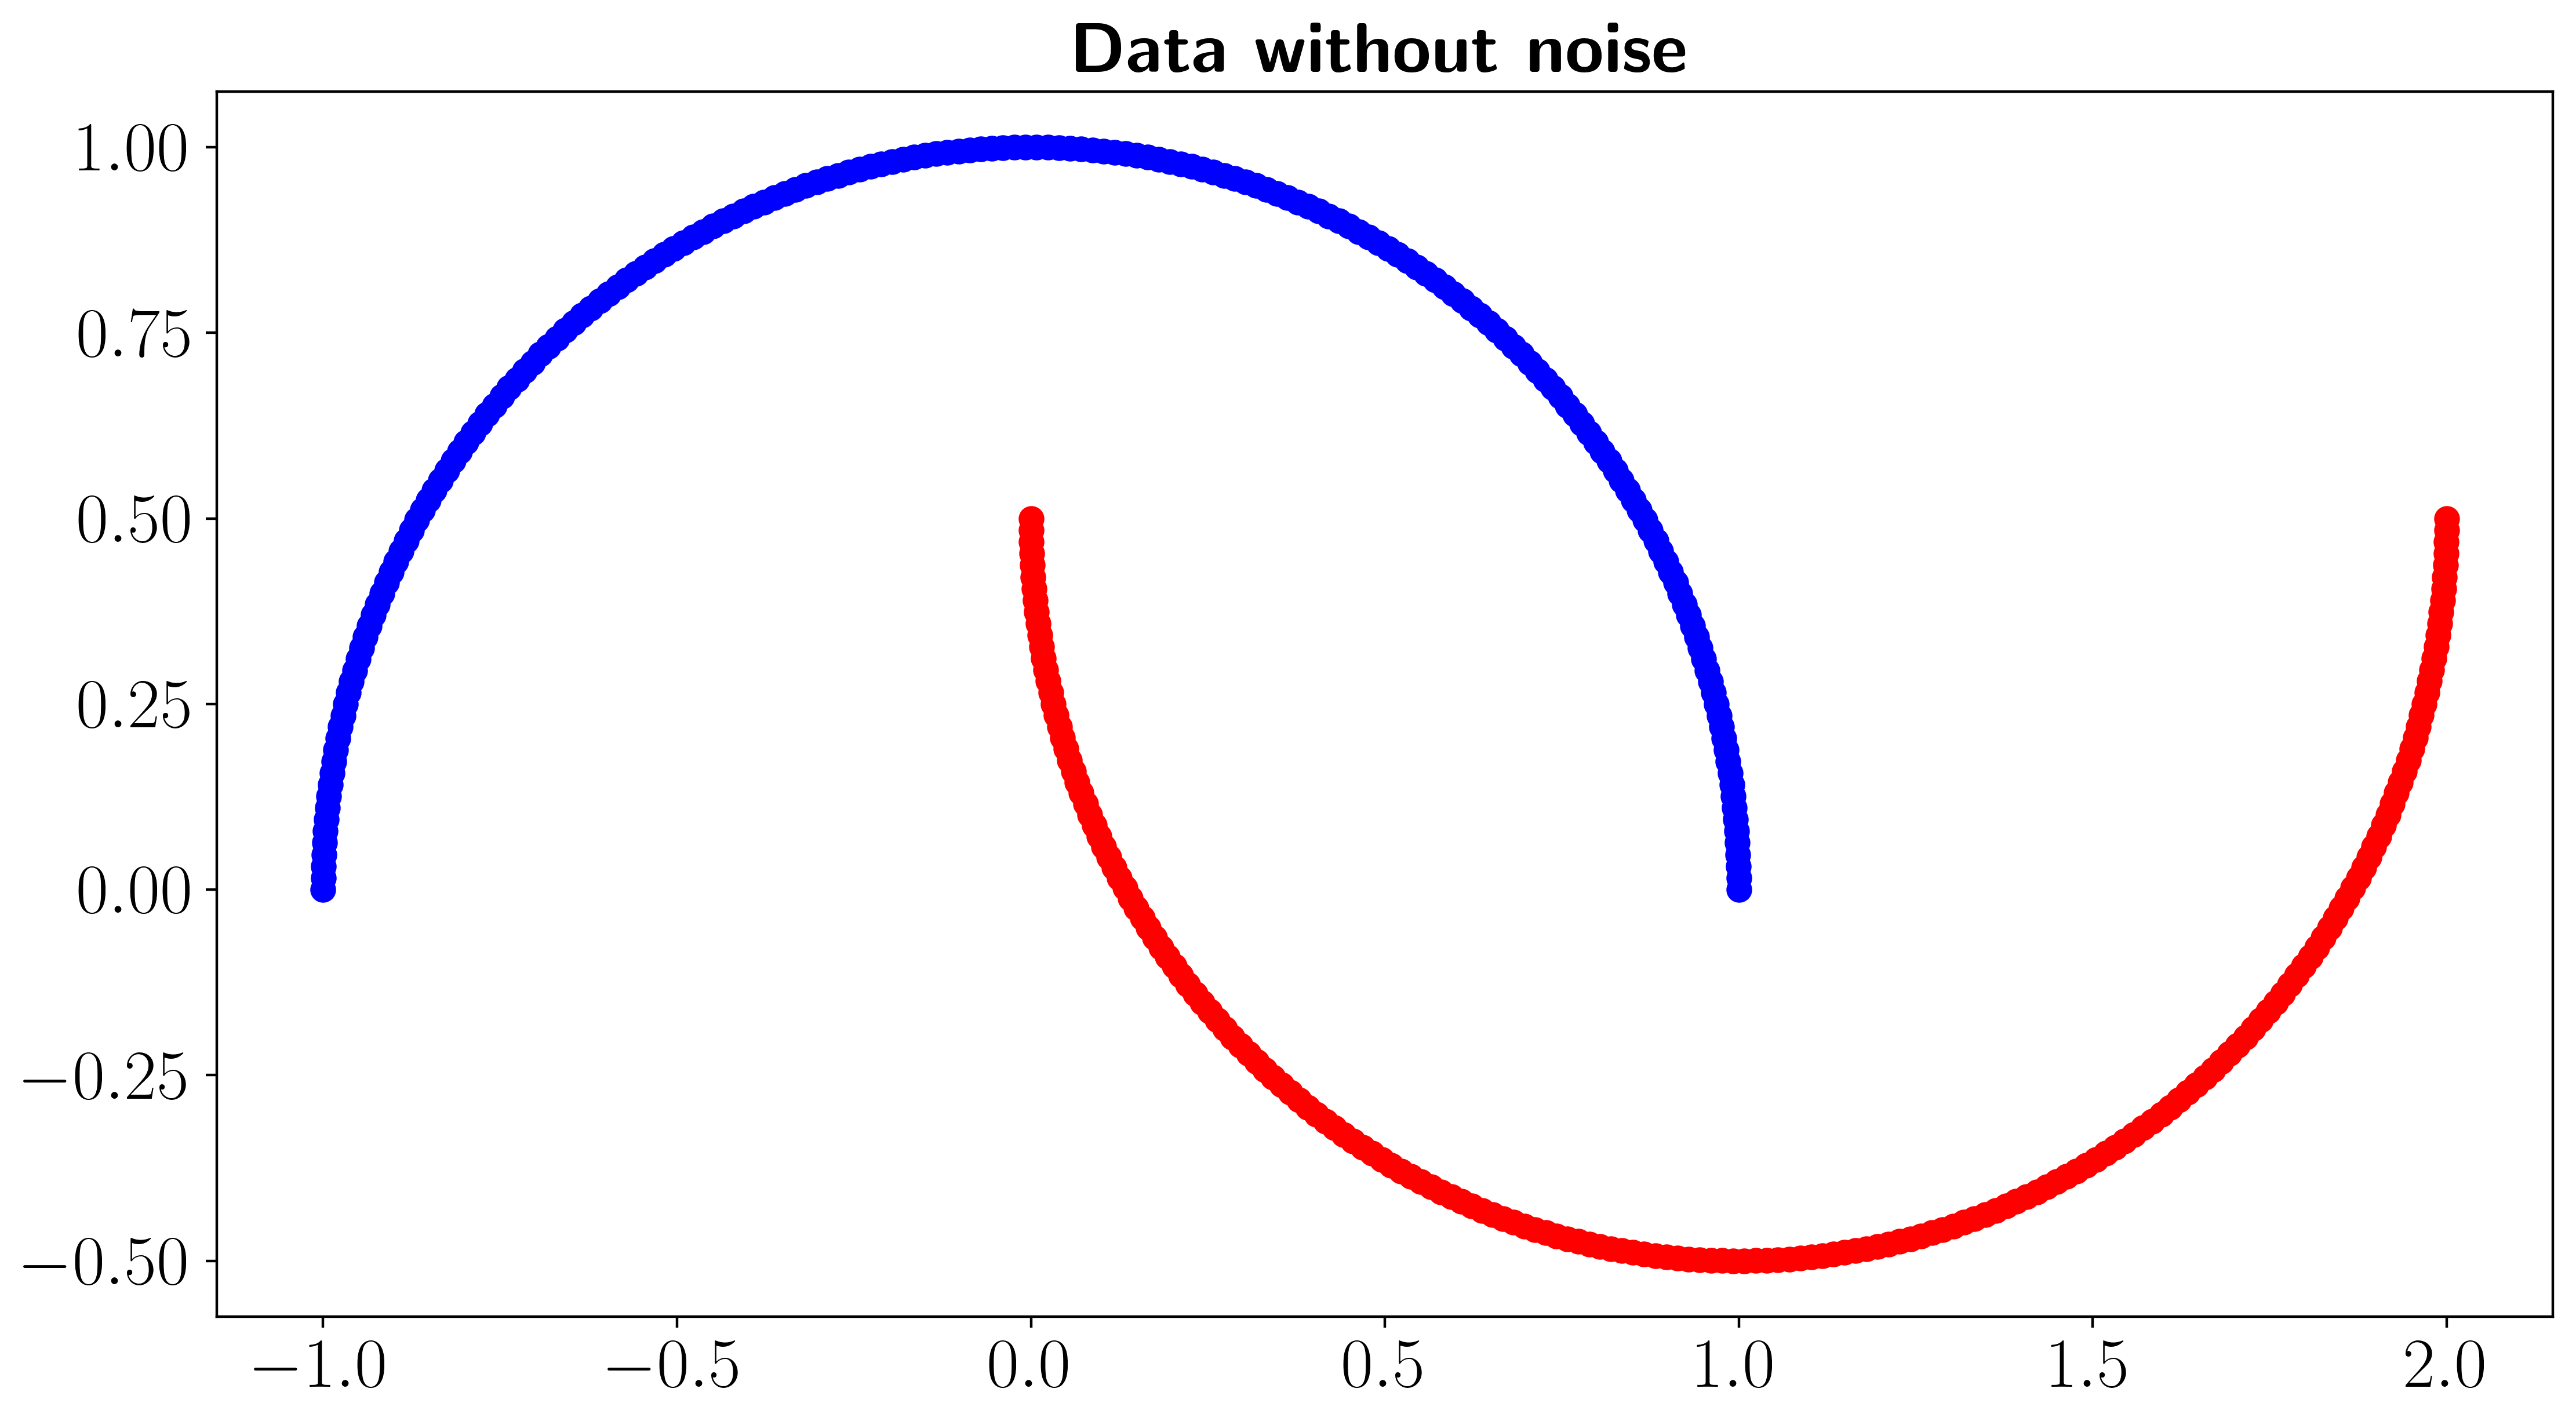

In [18]:
from sklearn import datasets

#Vizualization of dataset
X, y = datasets.make_moons(400,random_state = 42, noise = 0)

blue = X[y==0]
red  = X[y==1]

plt.title(r"\textbf{Data without noise}")
plt.plot(blue[:,0],blue[:,1],"bo")
plt.plot(red[:,0],red[:,1],"ro")
plt.show()

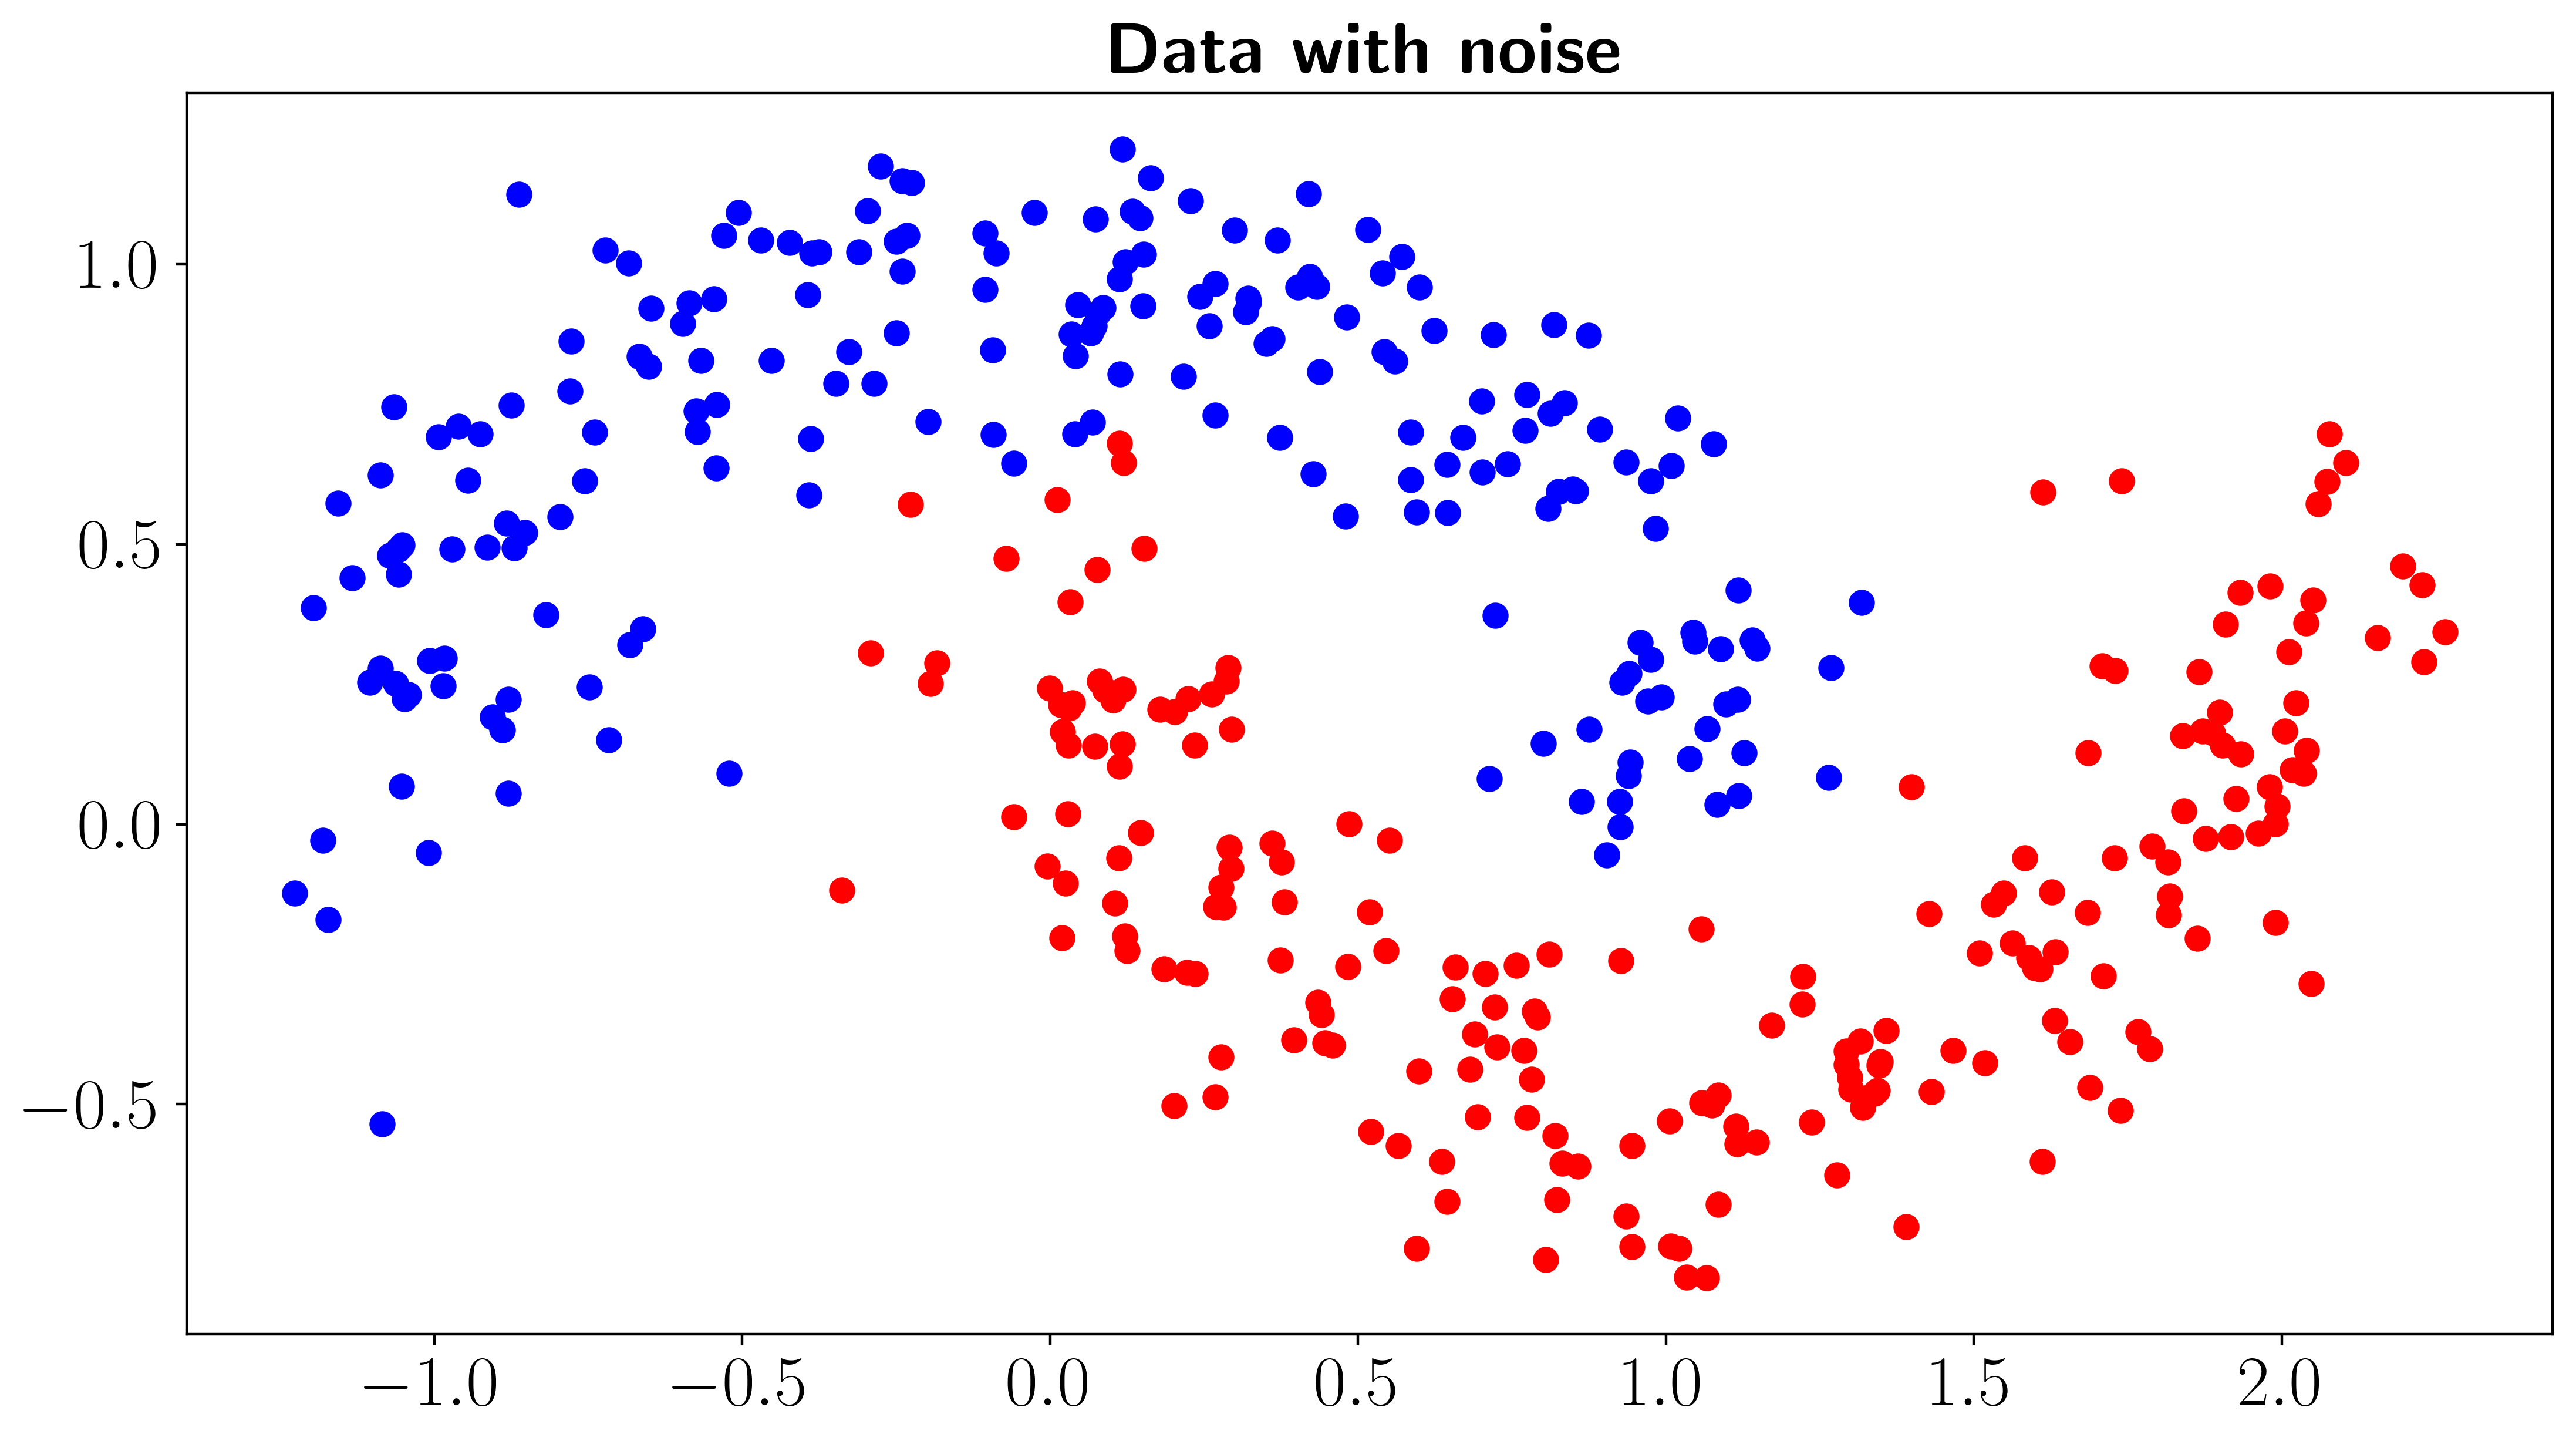

In [19]:
#Vizualization of dataset
X, y = datasets.make_moons(400,random_state = 42, noise = 0.15)

blue = X[y==0]
red  = X[y==1]

plt.title(r"\textbf{Data with noise}")
plt.plot(blue[:,0],blue[:,1],"bo")
plt.plot(red[:,0],red[:,1],"ro")
plt.show()

## Test the Network
It is time to test the network. The objective will be to classify whether a point belongs to the blue or red half circle in the dataset. We will test both the Adam gradient descent and the Vanilla gradient descent, and therefore we will make two separate networks.

During the training of the network we also test how it performs on a different set of data. We therefore make two _separate_ datasets.

In [20]:
I = 1000  # Number of datapoints

X_train, y_train = datasets.make_moons(I, random_state=100, noise=0.1)      
X_validate, y_validate = datasets.make_moons(I, random_state=30, noise=0.1)  

y_train = np.reshape(y_train, (I,1))  # Change the shape to adapt it to the network.
y_validate = np.reshape(y_validate, (I,1))

netAdam = Network(
    K=15,        # number of layers
    d=2,         # dimension of input
    I=I,         # number of datapoints
    num_iterations=5000,
    activation_functions_list=[tanh, tanh_derivative, sigmoid, sigmoid_derivative],
    gradient_descent_method=Adam,
    gradient_descent_input=[], # using default values of the parameters
    data=[X_validate.T, y_validate, X_train.T, y_train],
)


netVanilla = Network(
    K=15,        # number of layers
    d=2,         # dimension of input
    I=I,         # number of datapoints
    num_iterations=5000,
    activation_functions_list=[tanh, tanh_derivative, sigmoid, sigmoid_derivative],
    gradient_descent_method=Plain_vanilla,
    gradient_descent_input=[], # using default values of the parameters
    data=[X_validate.T, y_validate, X_train.T, y_train],
)

# If you wish to save a model, or load a model, this is how its done:
# netAdam.save_model('test')
# AdamCopy = Network(filename = 'test')

In [21]:
netVanilla.train()
netAdam.train()

100%|██████████| 5000/5000 [00:30<00:00, 162.72it/s]


To visualize how the cost evolves as a function of the iteration index, we use the function `Network.training_vs_validation_error()`.

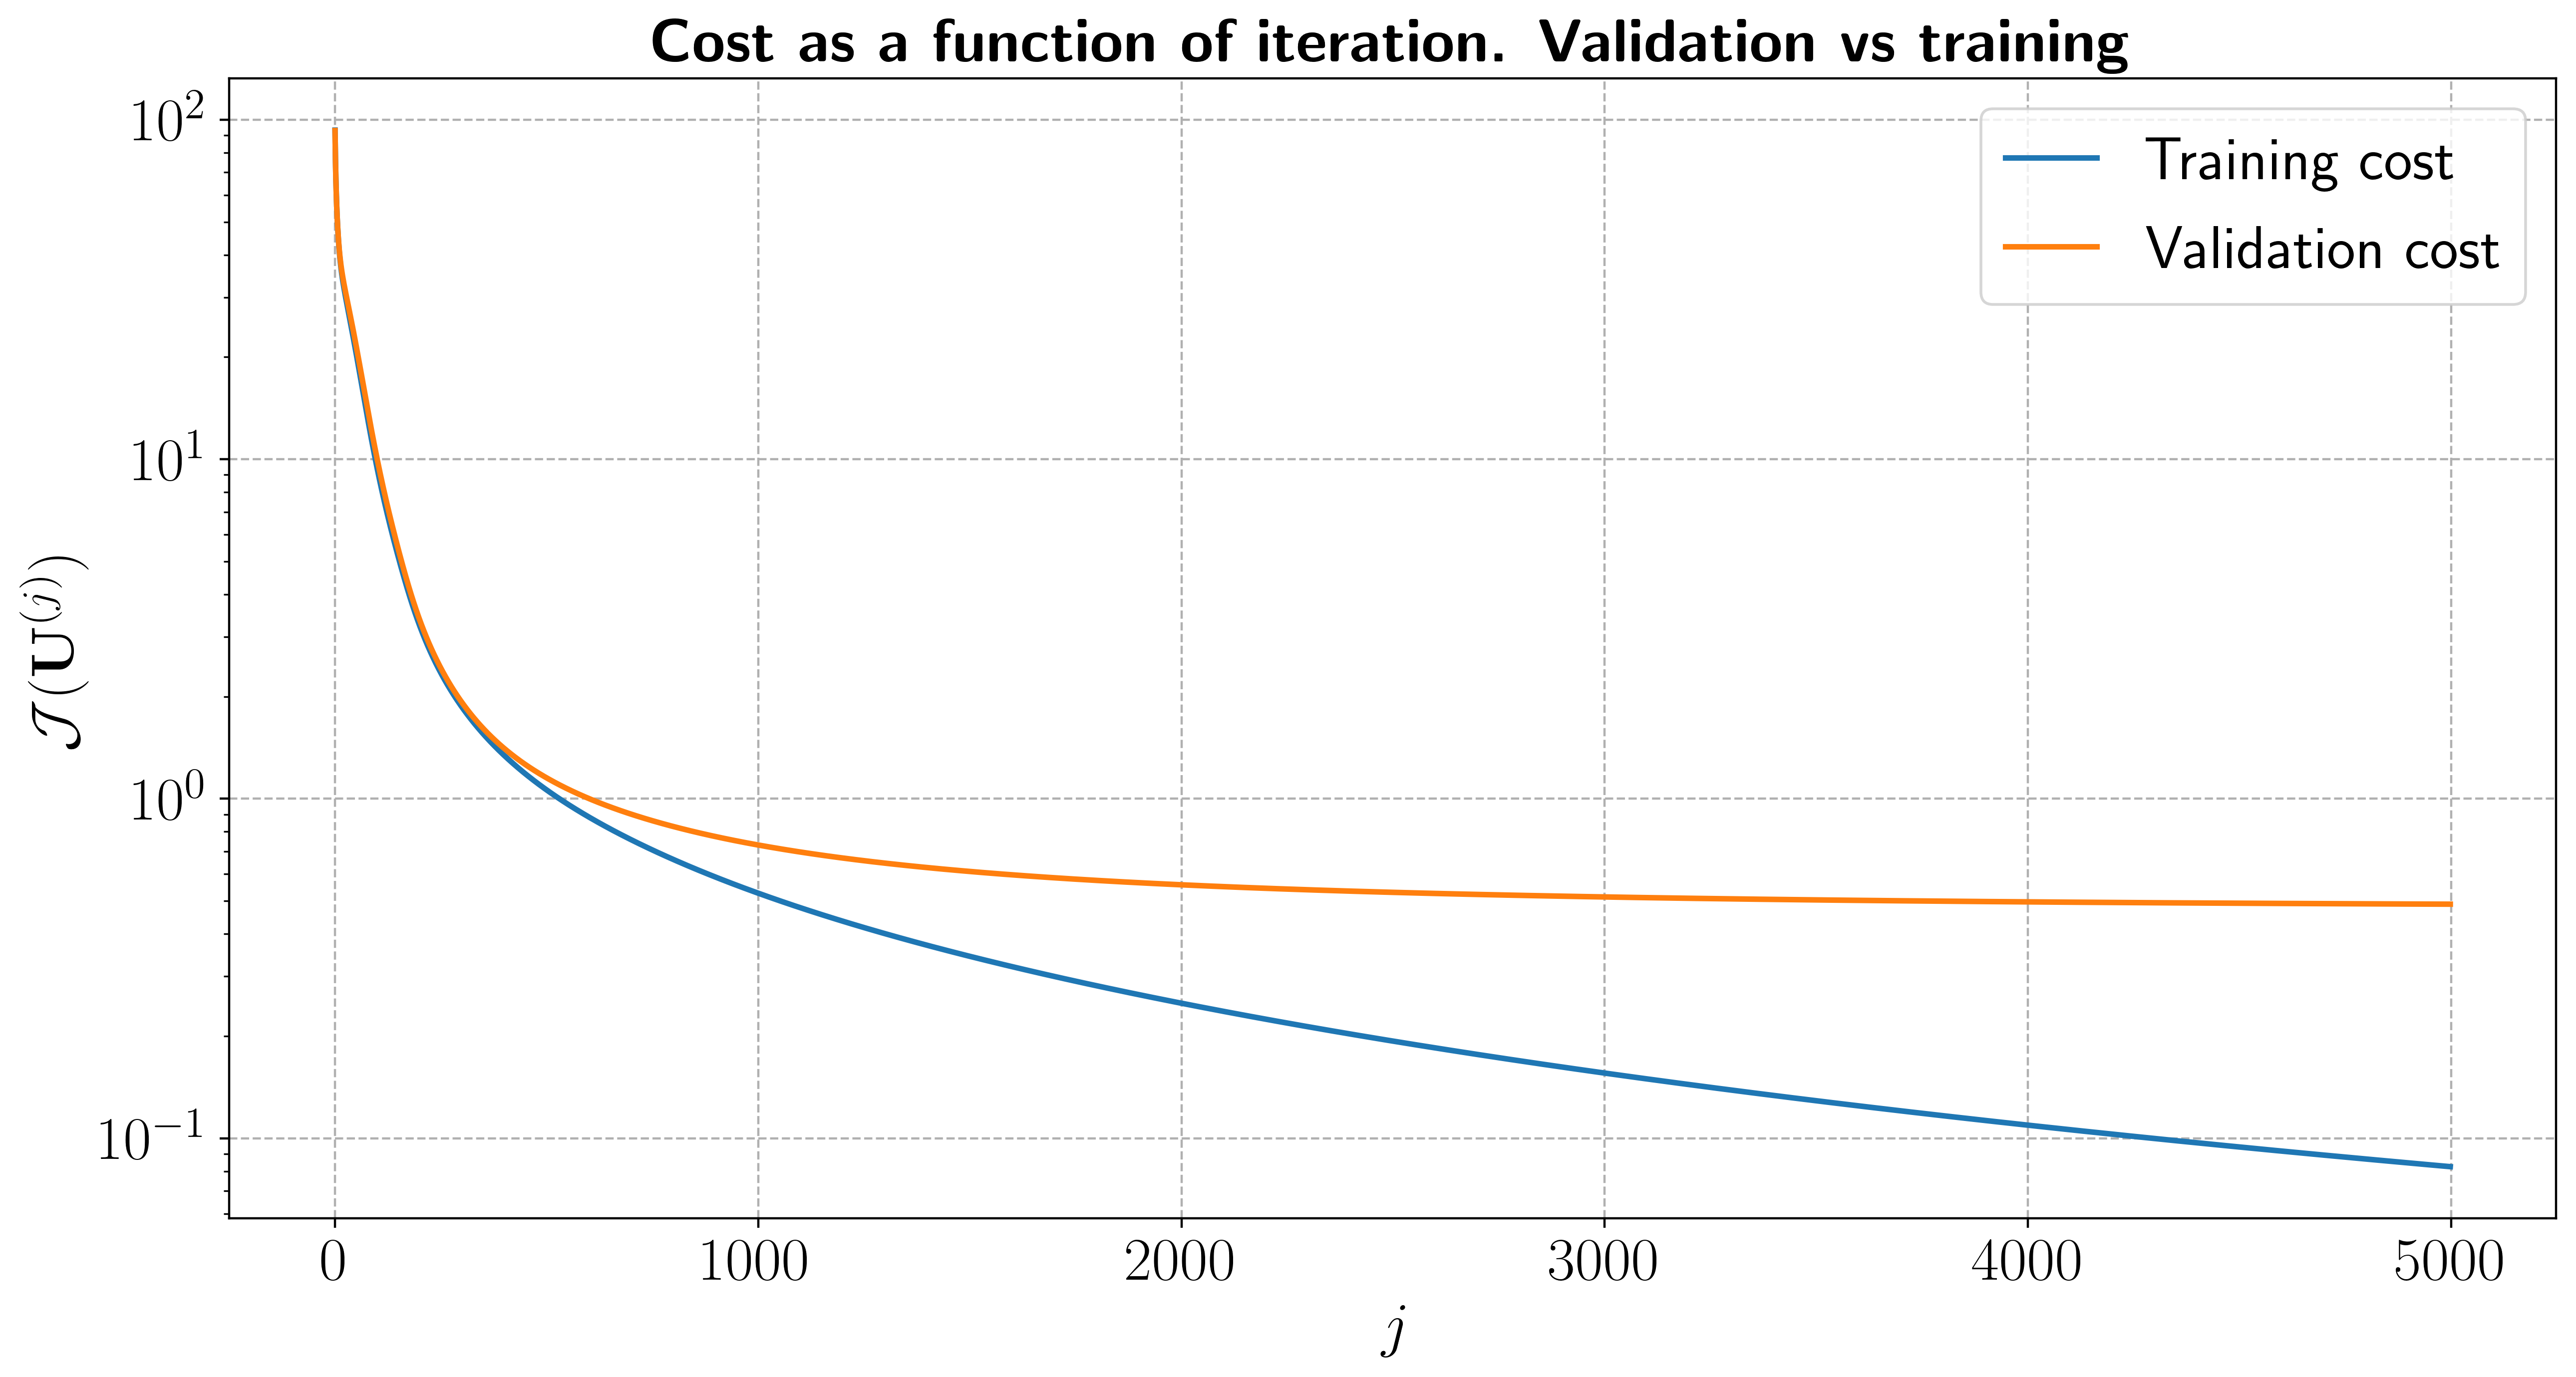

In [22]:
netVanilla.training_vs_validation_error()

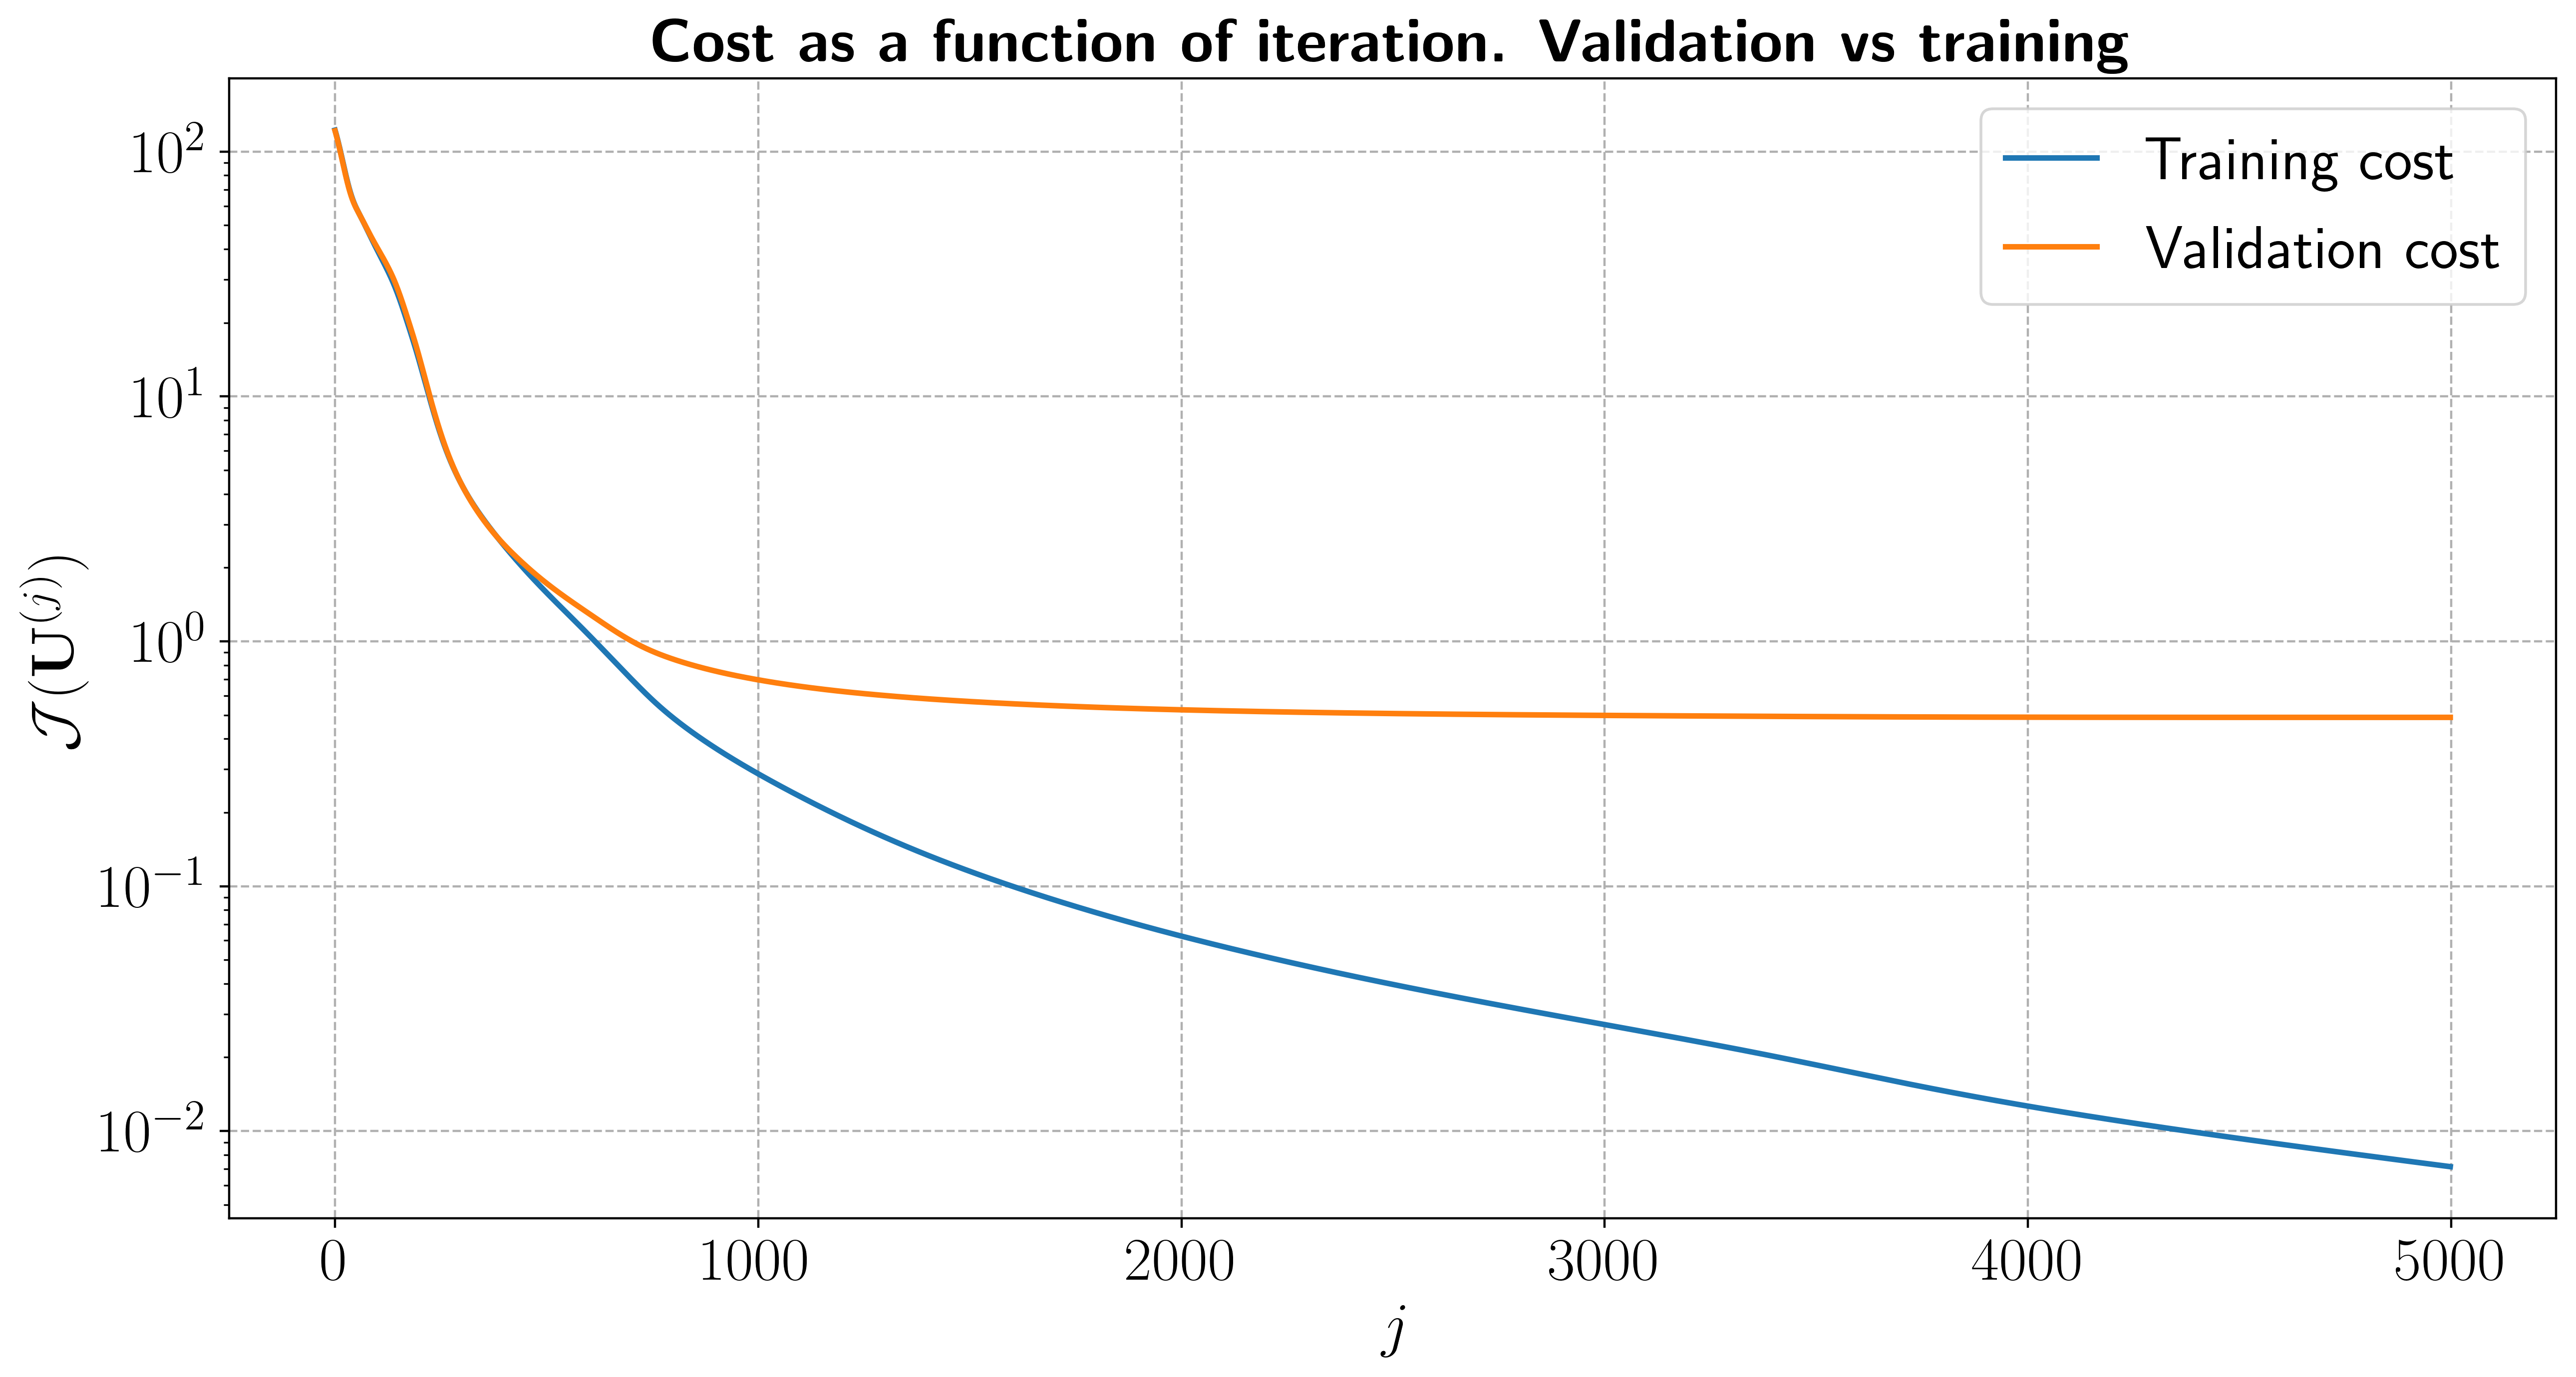

In [23]:
netAdam.training_vs_validation_error()

As shown above, the validation cost will in most cases reach a point beyond which it does not significantly improve the classification. The validation cost may even increase if we go on further, although the training cost continues to decrease. Ideally, one should stop the training at the minimum of the validation cost, since training the network further will result in the network _overfitting_. That is, rather than capturing the essence of the structure of the data it specializes to the particular data it has been given. Heuristically, the network fools itself to consider random noise in the data as part of the structure it is set out to predict. This causes the network to perform very good on the training data, but worse on unseen data. 

As an illustration of this, consider the problem of approximating a polynomial to a set of points. If we have $N$ points which we want our polynomial to approximate, we know that we are guaranteed that there exists a polynomial of degree _at most_ $N-1$ which passes through all of the points. However, it is not necessarily the case that this is the polynomial that most closely resembles the true model. The other extreme case is when the model is too simple, and we call this _underfitting_.

![overfitting](https://www.numfys.net/media/notebooks/images/overfitting_fig.png "overfitting")

### Visualization of Training
The main goal of the traning is to find the values of the parameters $\mathbf{U}$ that minimise $\mathcal{J}$. To see if the training is working as expected we can plot $\mathcal{J}(\mathbf{U}^{(j)})$ to se how the cost changes as a function of iterations $j$. We use the function `Network.compare_evolution` implemented in the `Network` class to visualize the training for both of the networks.

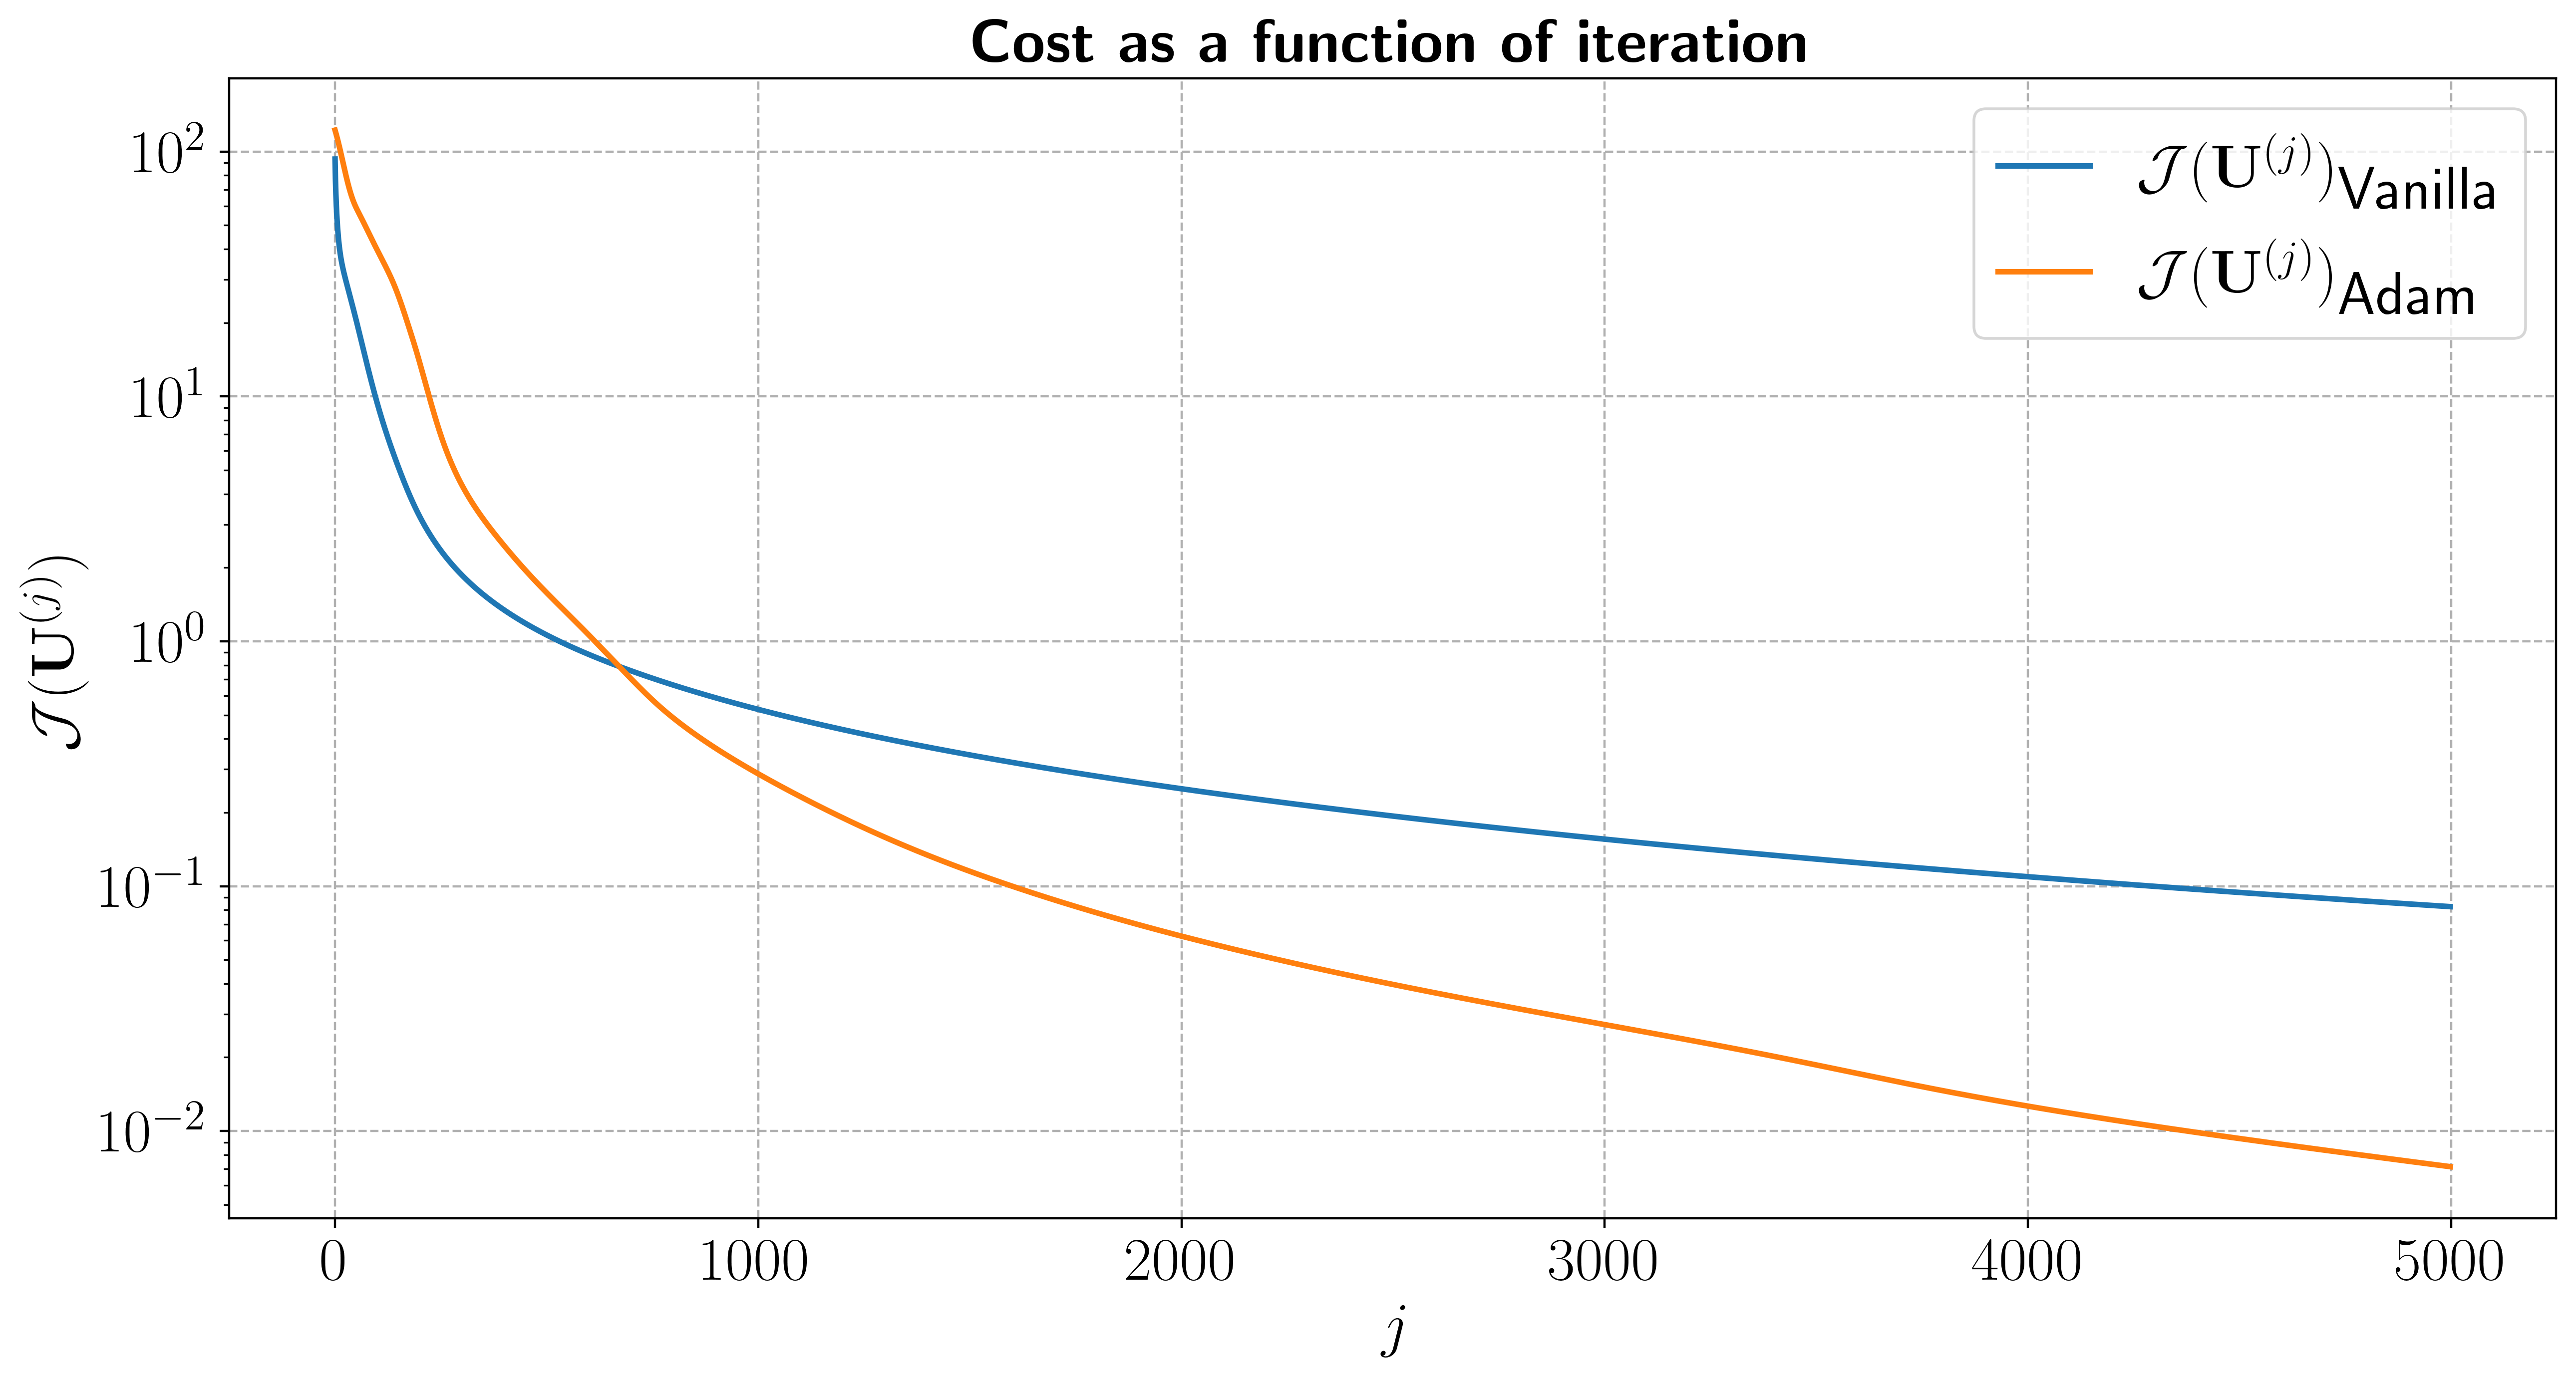

In [24]:
netVanilla.compare_evolution(netAdam, "Vanilla", "Adam")

As seen from the plot above, the network trained with the Adam-algorithm is trained much faster than the one trained with the Plain-Vanilla algorithm. Nevertheless, since this problem is so basic, the validation cost of both networks stagnate after a while. Therefore, training the Adam-network for $5000$ iterations is in this case rather excessive, since it does not enhance the performance. This is also seen below where we compare how the two networks perform in a _confusion matrix_.

The plot below shows the position of the red and blue data points after begin transformed through each of the layers of the network. From the visualisations below we see that what the network _learns_ how to twist and untangle the two spirals so that it is easy to make a classification, which it simply does by drawing a straight line in $\mathbb{R}^2$ that separates the blue chunk from the red. The insight gained from this artificially simple problem is indeed transferable to more complex data of higher dimension. The problem is that one cannot in higher-dimensional problems visualize this process with the same ease. If for example it were points in a $N$-dimensional space that we were to binary classify, a trained network would map the points around in the $N$-dimensional space through the layers, and eventually it would draw an $N-1$-dimensional hyperplane separating the two classes into two regions of space. 

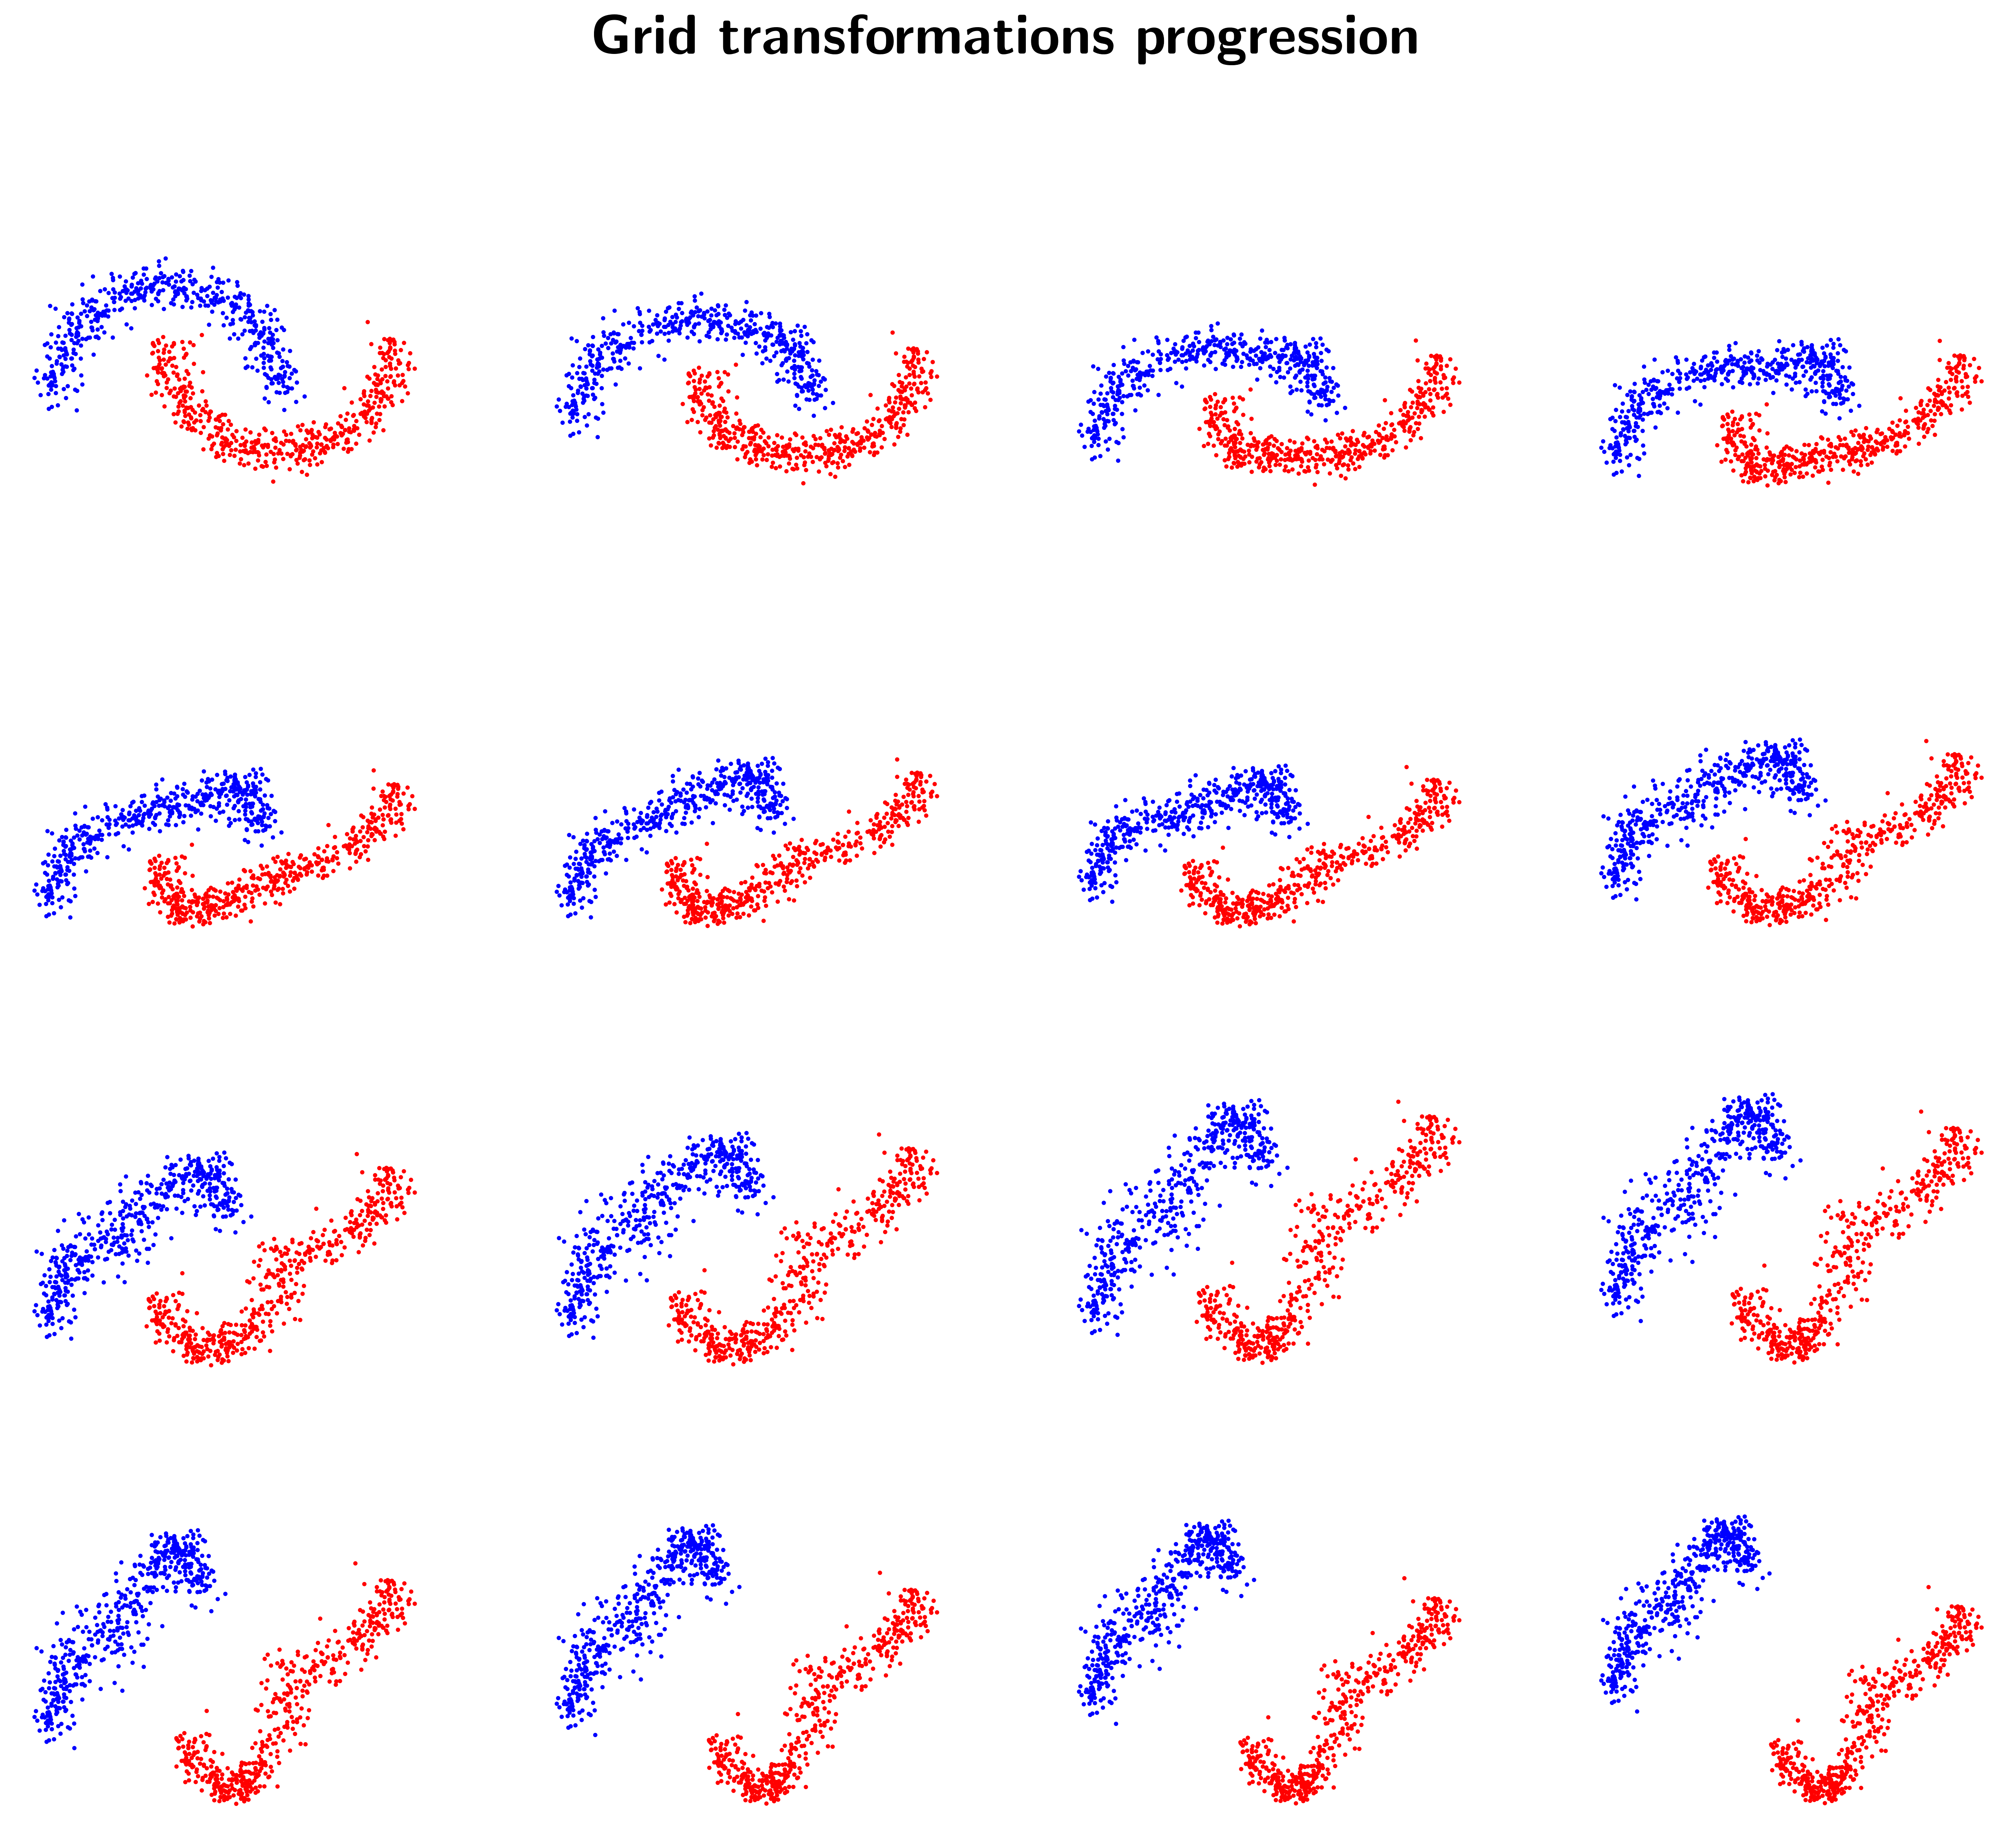

In [25]:
netAdam.visualize_layers()

From the network's perspective, there is nothing special about classifying the points in the spirals compared to any other point in the plane. If we were to classify the region around the spirals we expect the classification to be good in the vicinity of each spiral, and less so in-between them. This is exaclty what we observe below. 

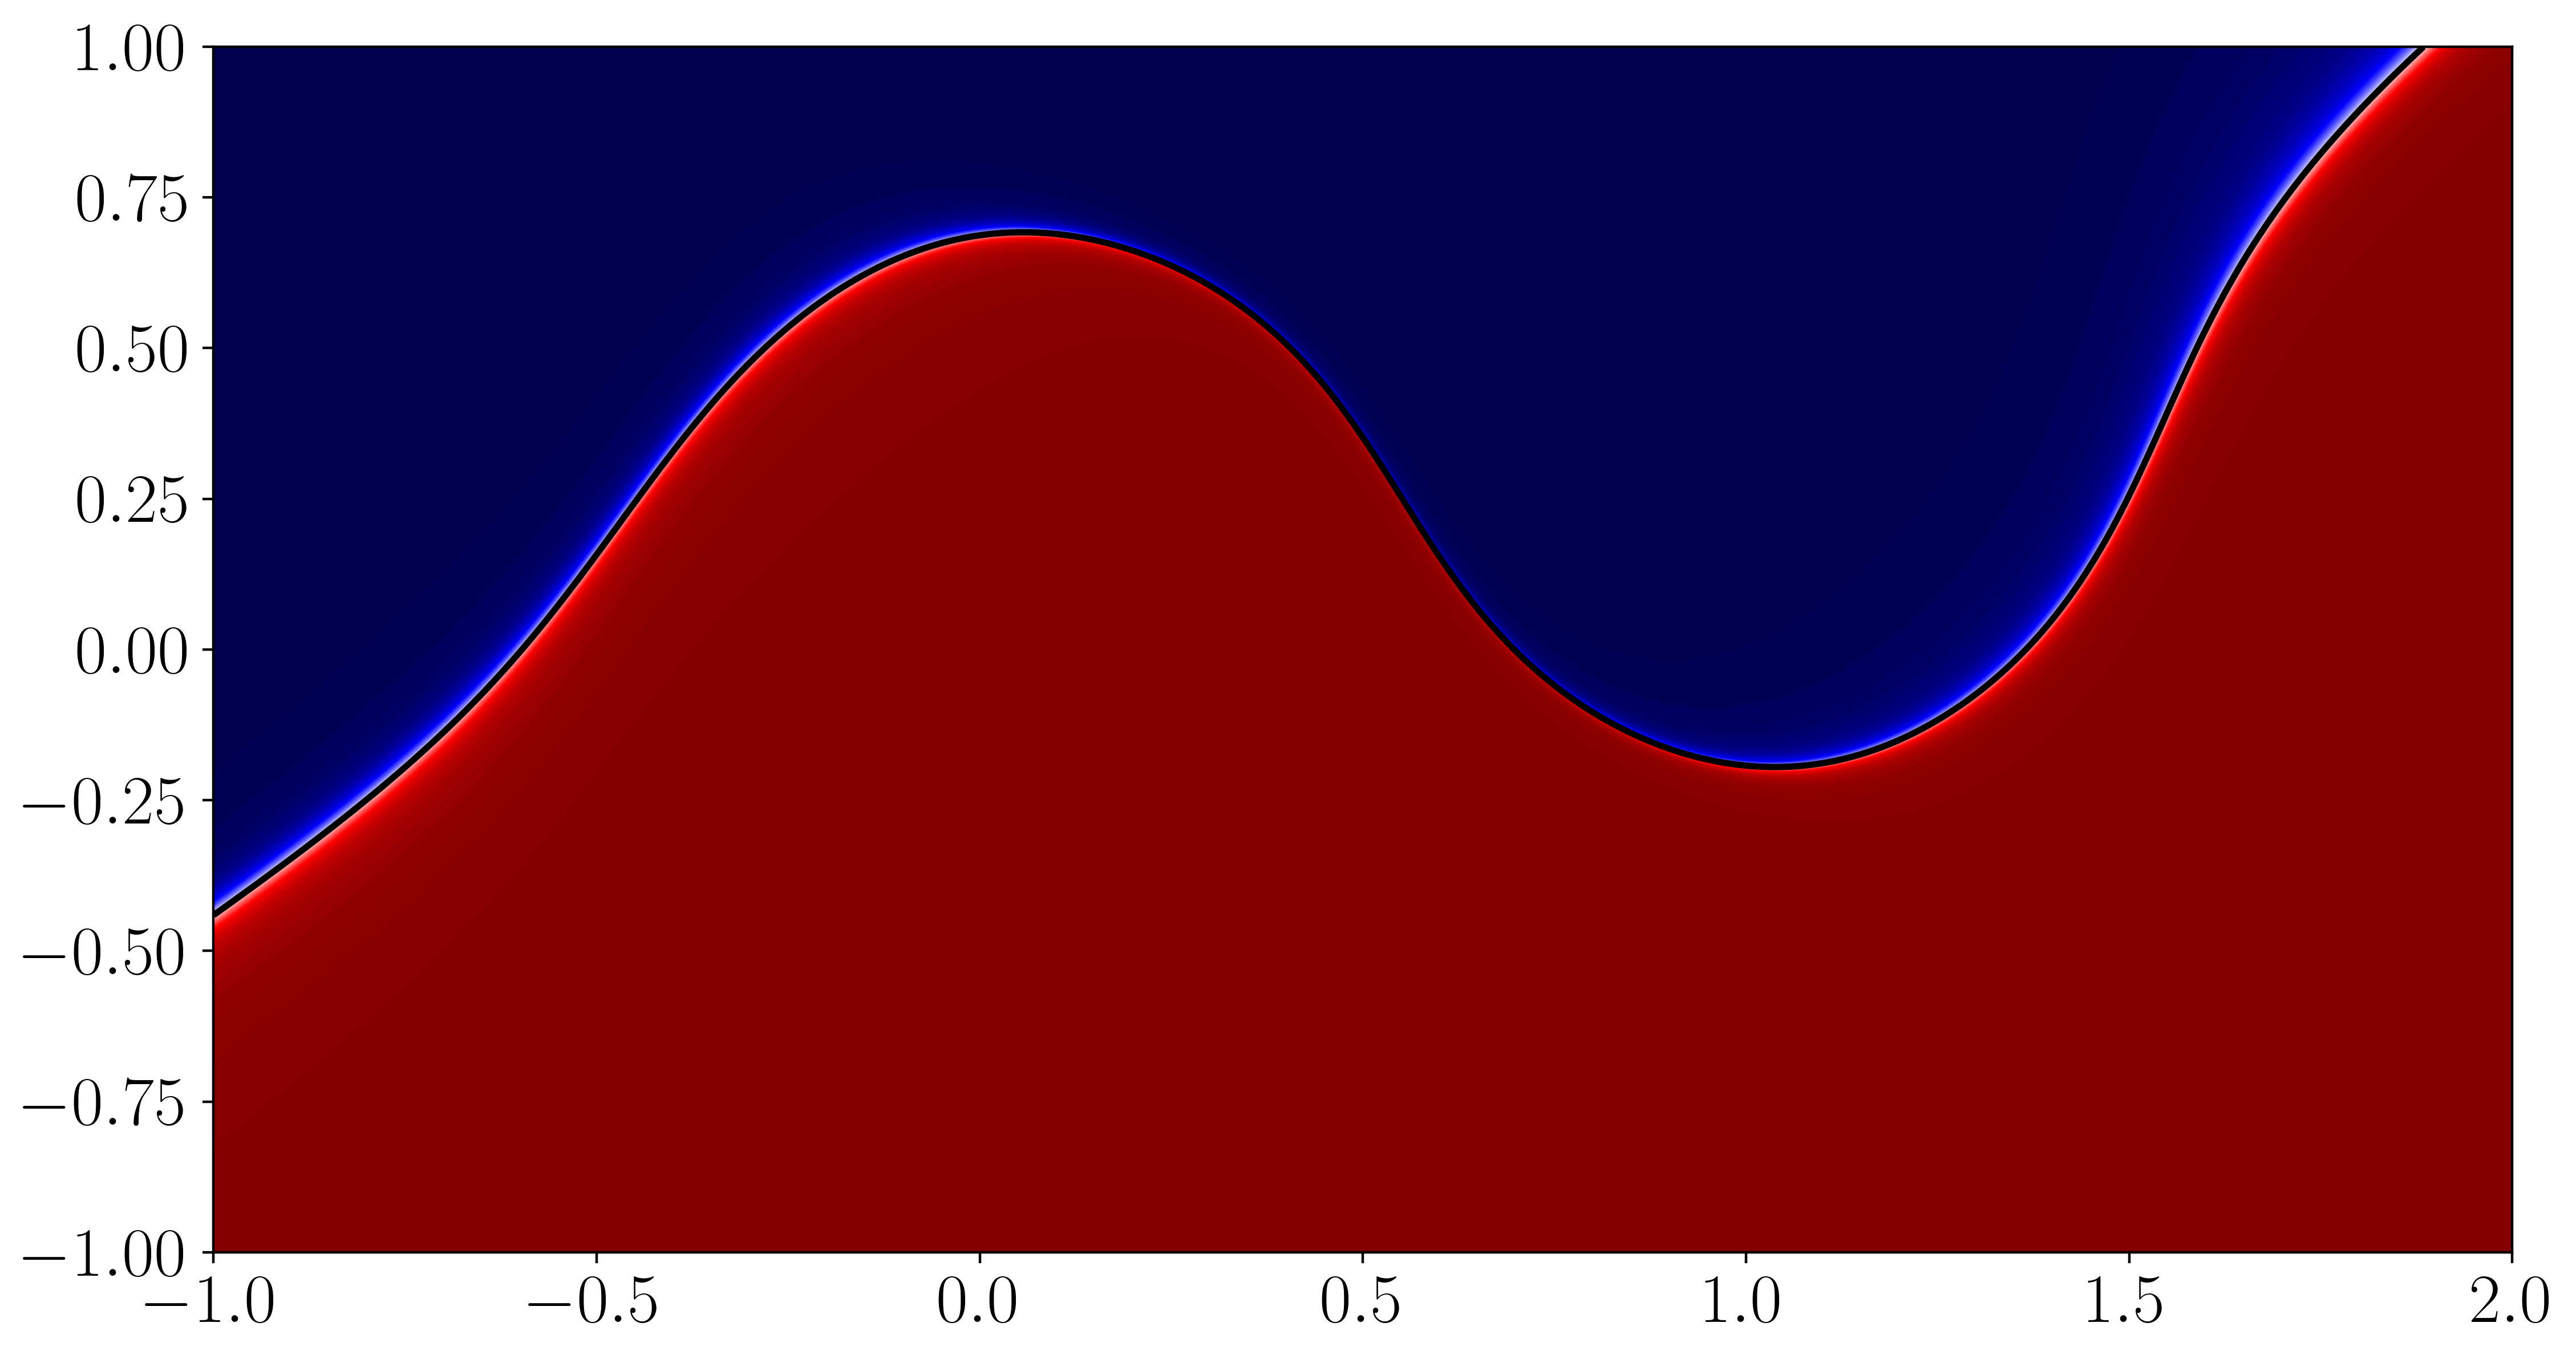

In [26]:
N = 1000

y = np.linspace(-1,1,N)
x = np.linspace(-1,2,N)

xx, yy = np.meshgrid(x,y)

plane = np.reshape((xx,yy), (2, N**2))

Z = netAdam.predict(plane, integers = False)

plt.contourf(x, y, Z.reshape((N,N)), cmap='seismic', levels = 100)
plt.contour(x, y, Z.reshape((N,N)), levels=1, colors='k')
plt.xlim([-1,2])
plt.ylim([-1,1])
plt.show()

### Accuracy of the Network
Even though it is important for the network to work well during training, it is the tests done with a validation set that really tell you how good the network is. Here you test the network on new data and you can see how well it preforms in general. There are many ways to test a network, but we have chosen three simple methods that can be implemented for most problems. First we test the accuracy of the network, i.e. what percentage of the guesses are right. If the accuracy is close to $50 \%$ for binary classification it means that the network has not been able to learn the connection between the input and output data, and a random guess would be equally good. 

In [27]:
#Method beloning to network
#self = Network

def accuracy(self, X, y):
    """Use a validation set {X,y} to check the accuracy of the network. 

    Parameters
    ----------
    X : np.array
        Validation set input
    y : np.array
        Validation set true value for output

    Returns
    -------
    accuracy : float
        The accuracy is the percentage of correct predictions
    """
    Y_test = self.predict(X)
    accuracy = np.sum(y == Y_test)/len(Y_test)
    return accuracy

In [28]:
n = 10000 
X_validate, c_validate = datasets.make_moons(n,noise = 0.15)

print("Accuracy Adam:    %.3f" %netAdam.accuracy(X_validate.T, np.array([c_validate]).T))
print("Accuracy Vanilla: %.3f" %netVanilla.accuracy(X_validate.T, np.array([c_validate]).T))

Accuracy Adam:    0.990
Accuracy Vanilla: 0.990


Secondly, we test the variance of the network. Here we can see how certain the network is on its guesses. Ideally, the network would output either $1$ or $0$ for the two categories, but in reality it returns a decimal number between $1$ and $0$. The variance is a measure of how close or far from the true value the guesses are. The smaller the variance is, the better.

In [29]:
#Function beloning to network
#self = Network

def variance(self, X, y):
    """
    Use a validation set {X,y} to check the variance of the network. 

    Parameters
    ----------
    X : np.array
        Validation set input
    y : np.array
        Validation set true value for output

    Returns
    -------
    variance : float
        The variance is 1/(n-1) sum((prediction - true value)^2)
    """
    Y_test = self.predict(X, integers=False)
    variance = 1/(len(y)-1)*np.sum(np.square(Y_test-y))
    return variance

In [30]:
print("Variance Adam:    %.3e" %netAdam.variance(X_validate.T, np.array([c_validate]).T))
print("Variance Vanilla: %.3e " %netVanilla.variance(X_validate.T, np.array([c_validate]).T))

Variance Adam:    8.590e-03
Variance Vanilla: 7.780e-03 


The third test is a confusion matrix. This is a square $n\times n$ matrix where $n$ is the number of classes it predicts. The rows represent the true value of the class, while the columns represent the guessed value. The slot $(i,j)$ of the matrix is then the (normalized) number of guessed instances of category $j$ which has true value $i$. A perfect classification would then be the identity matrix. Below we plot the confusion matricies for validation on the two networks. In the case of binary classification we can write the elements as true negatives (TN), true positives (TP), false negatives (FN) and false positives (FP) in the following way

$$
    \begin{bmatrix}
        \frac{\text{TN}}{\text{N}} & \frac{\text{FN}}{N} \\
        \frac{\text{FP}}{\text{P}} & \frac{\text{TP}}{P}
    \end{bmatrix},
$$

where P is the number of positve instances (category 1), and N is the number of negative instances (category 0). 

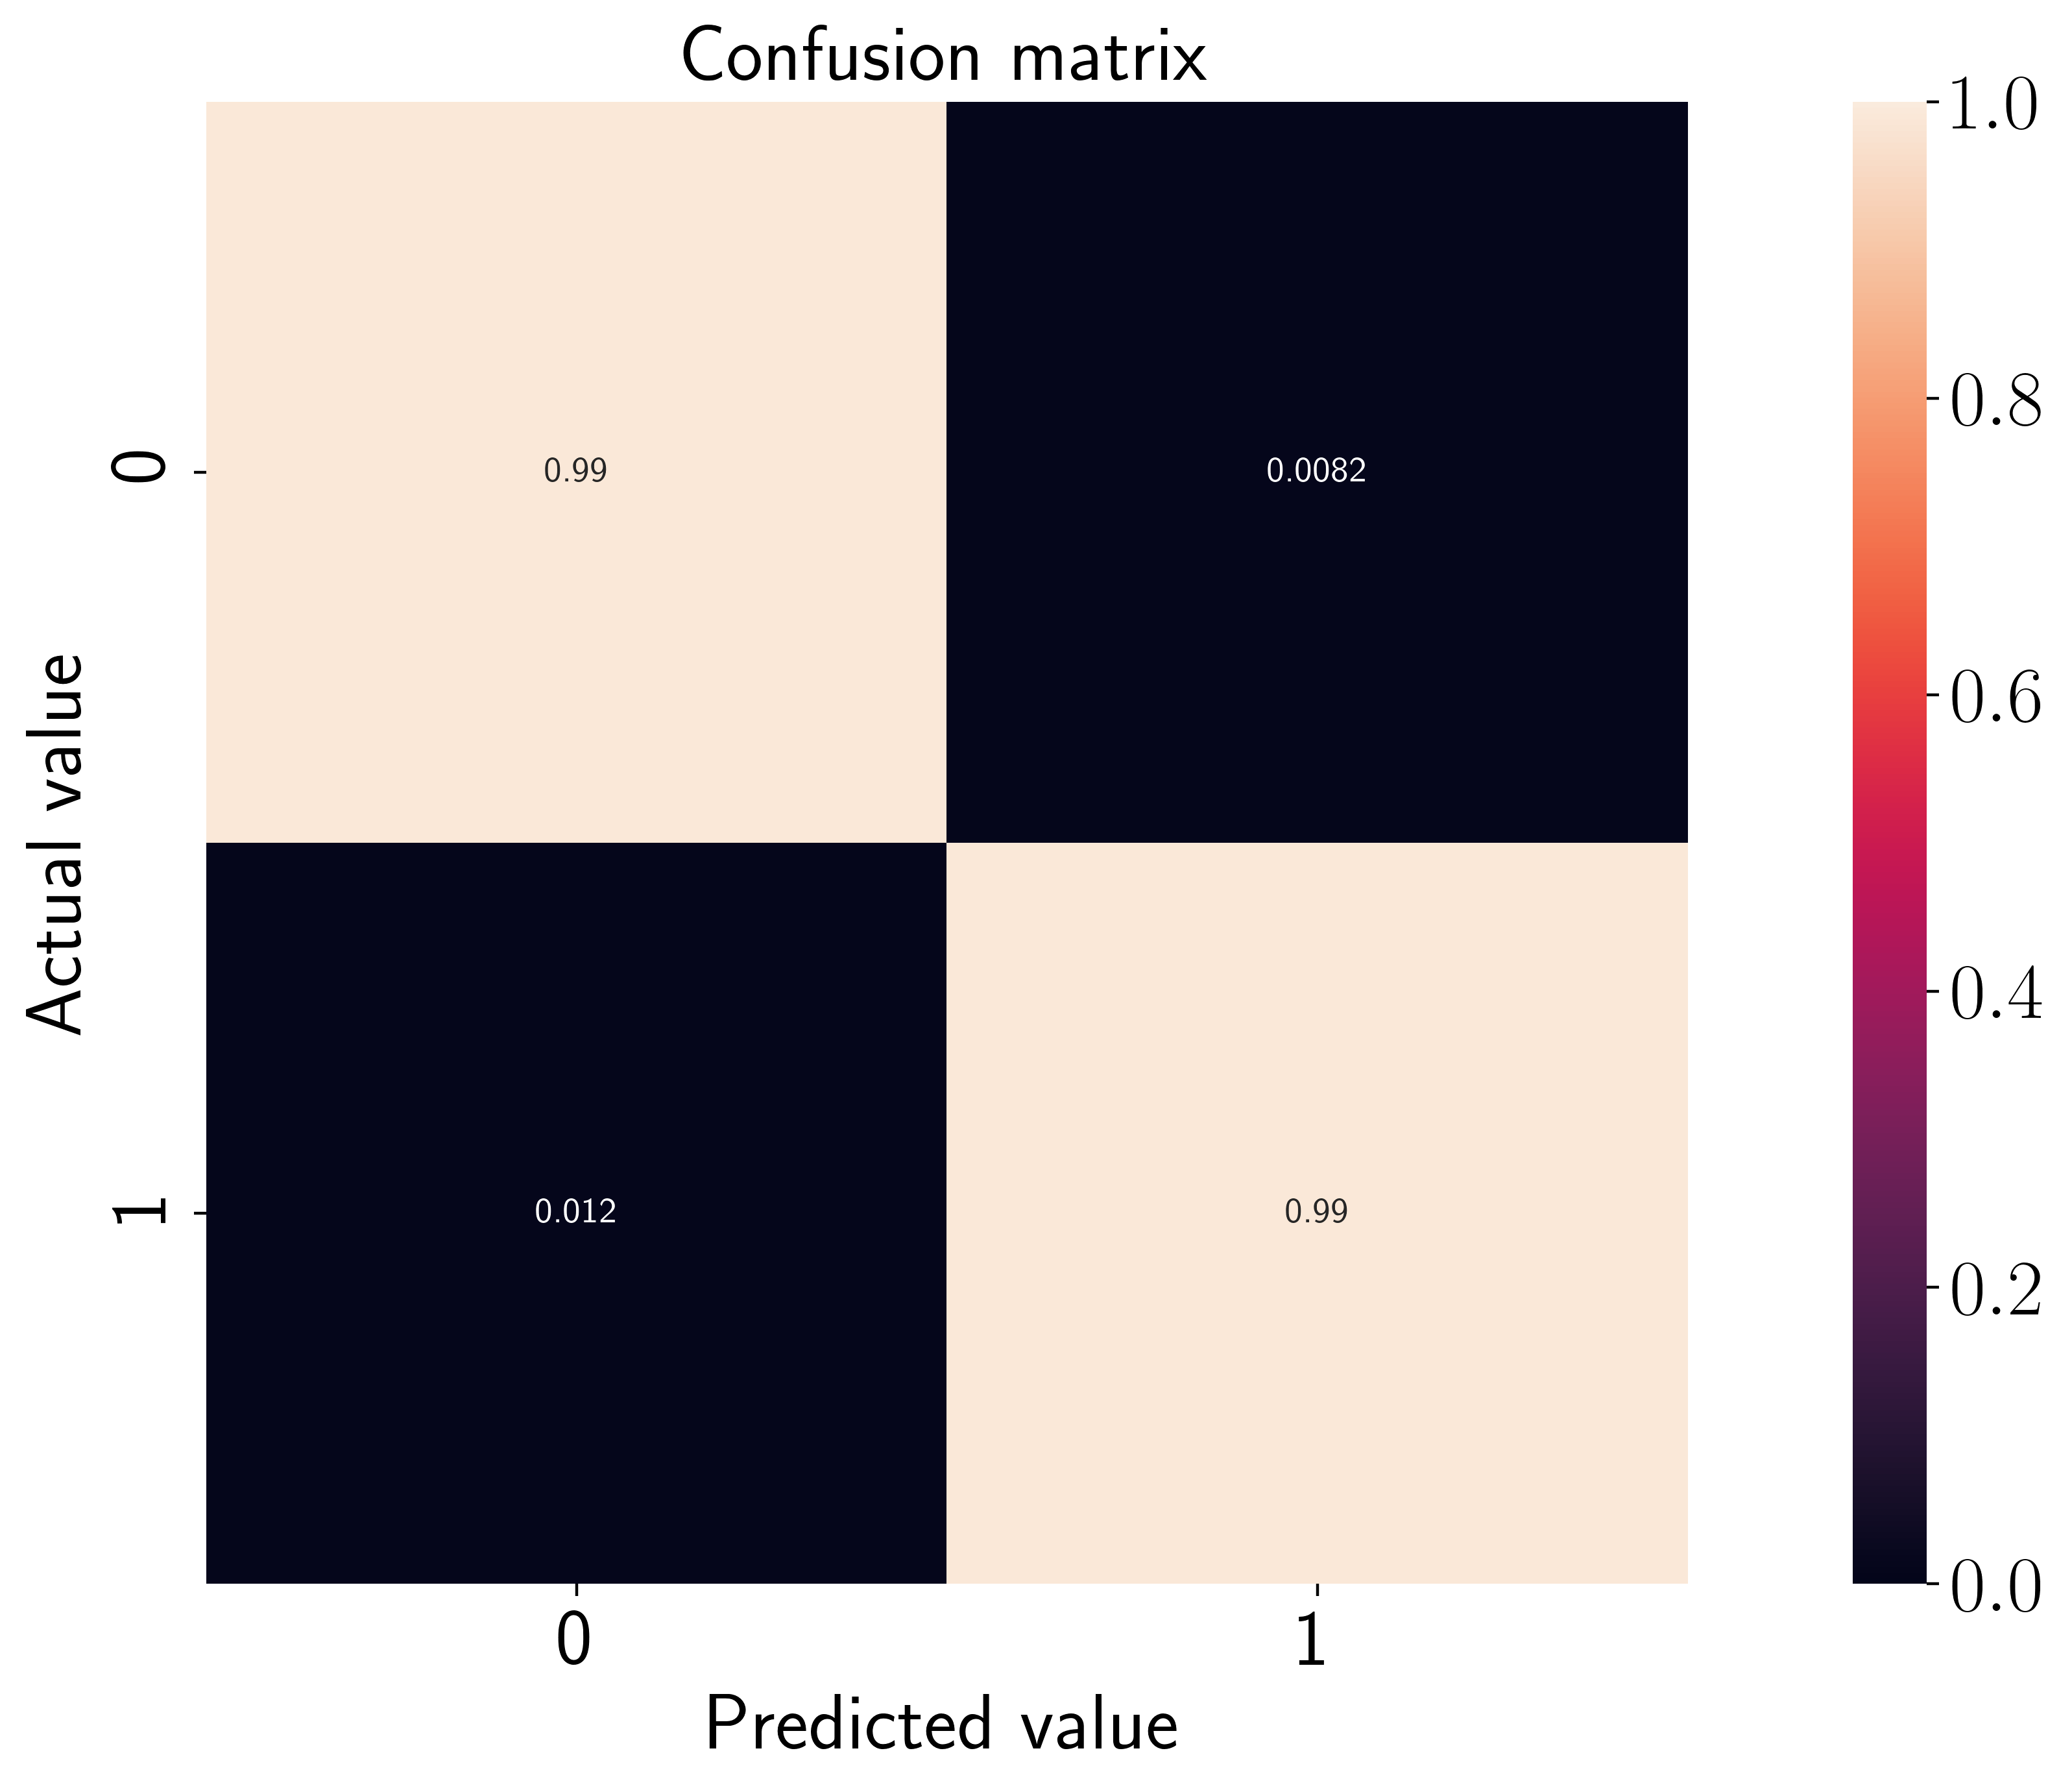

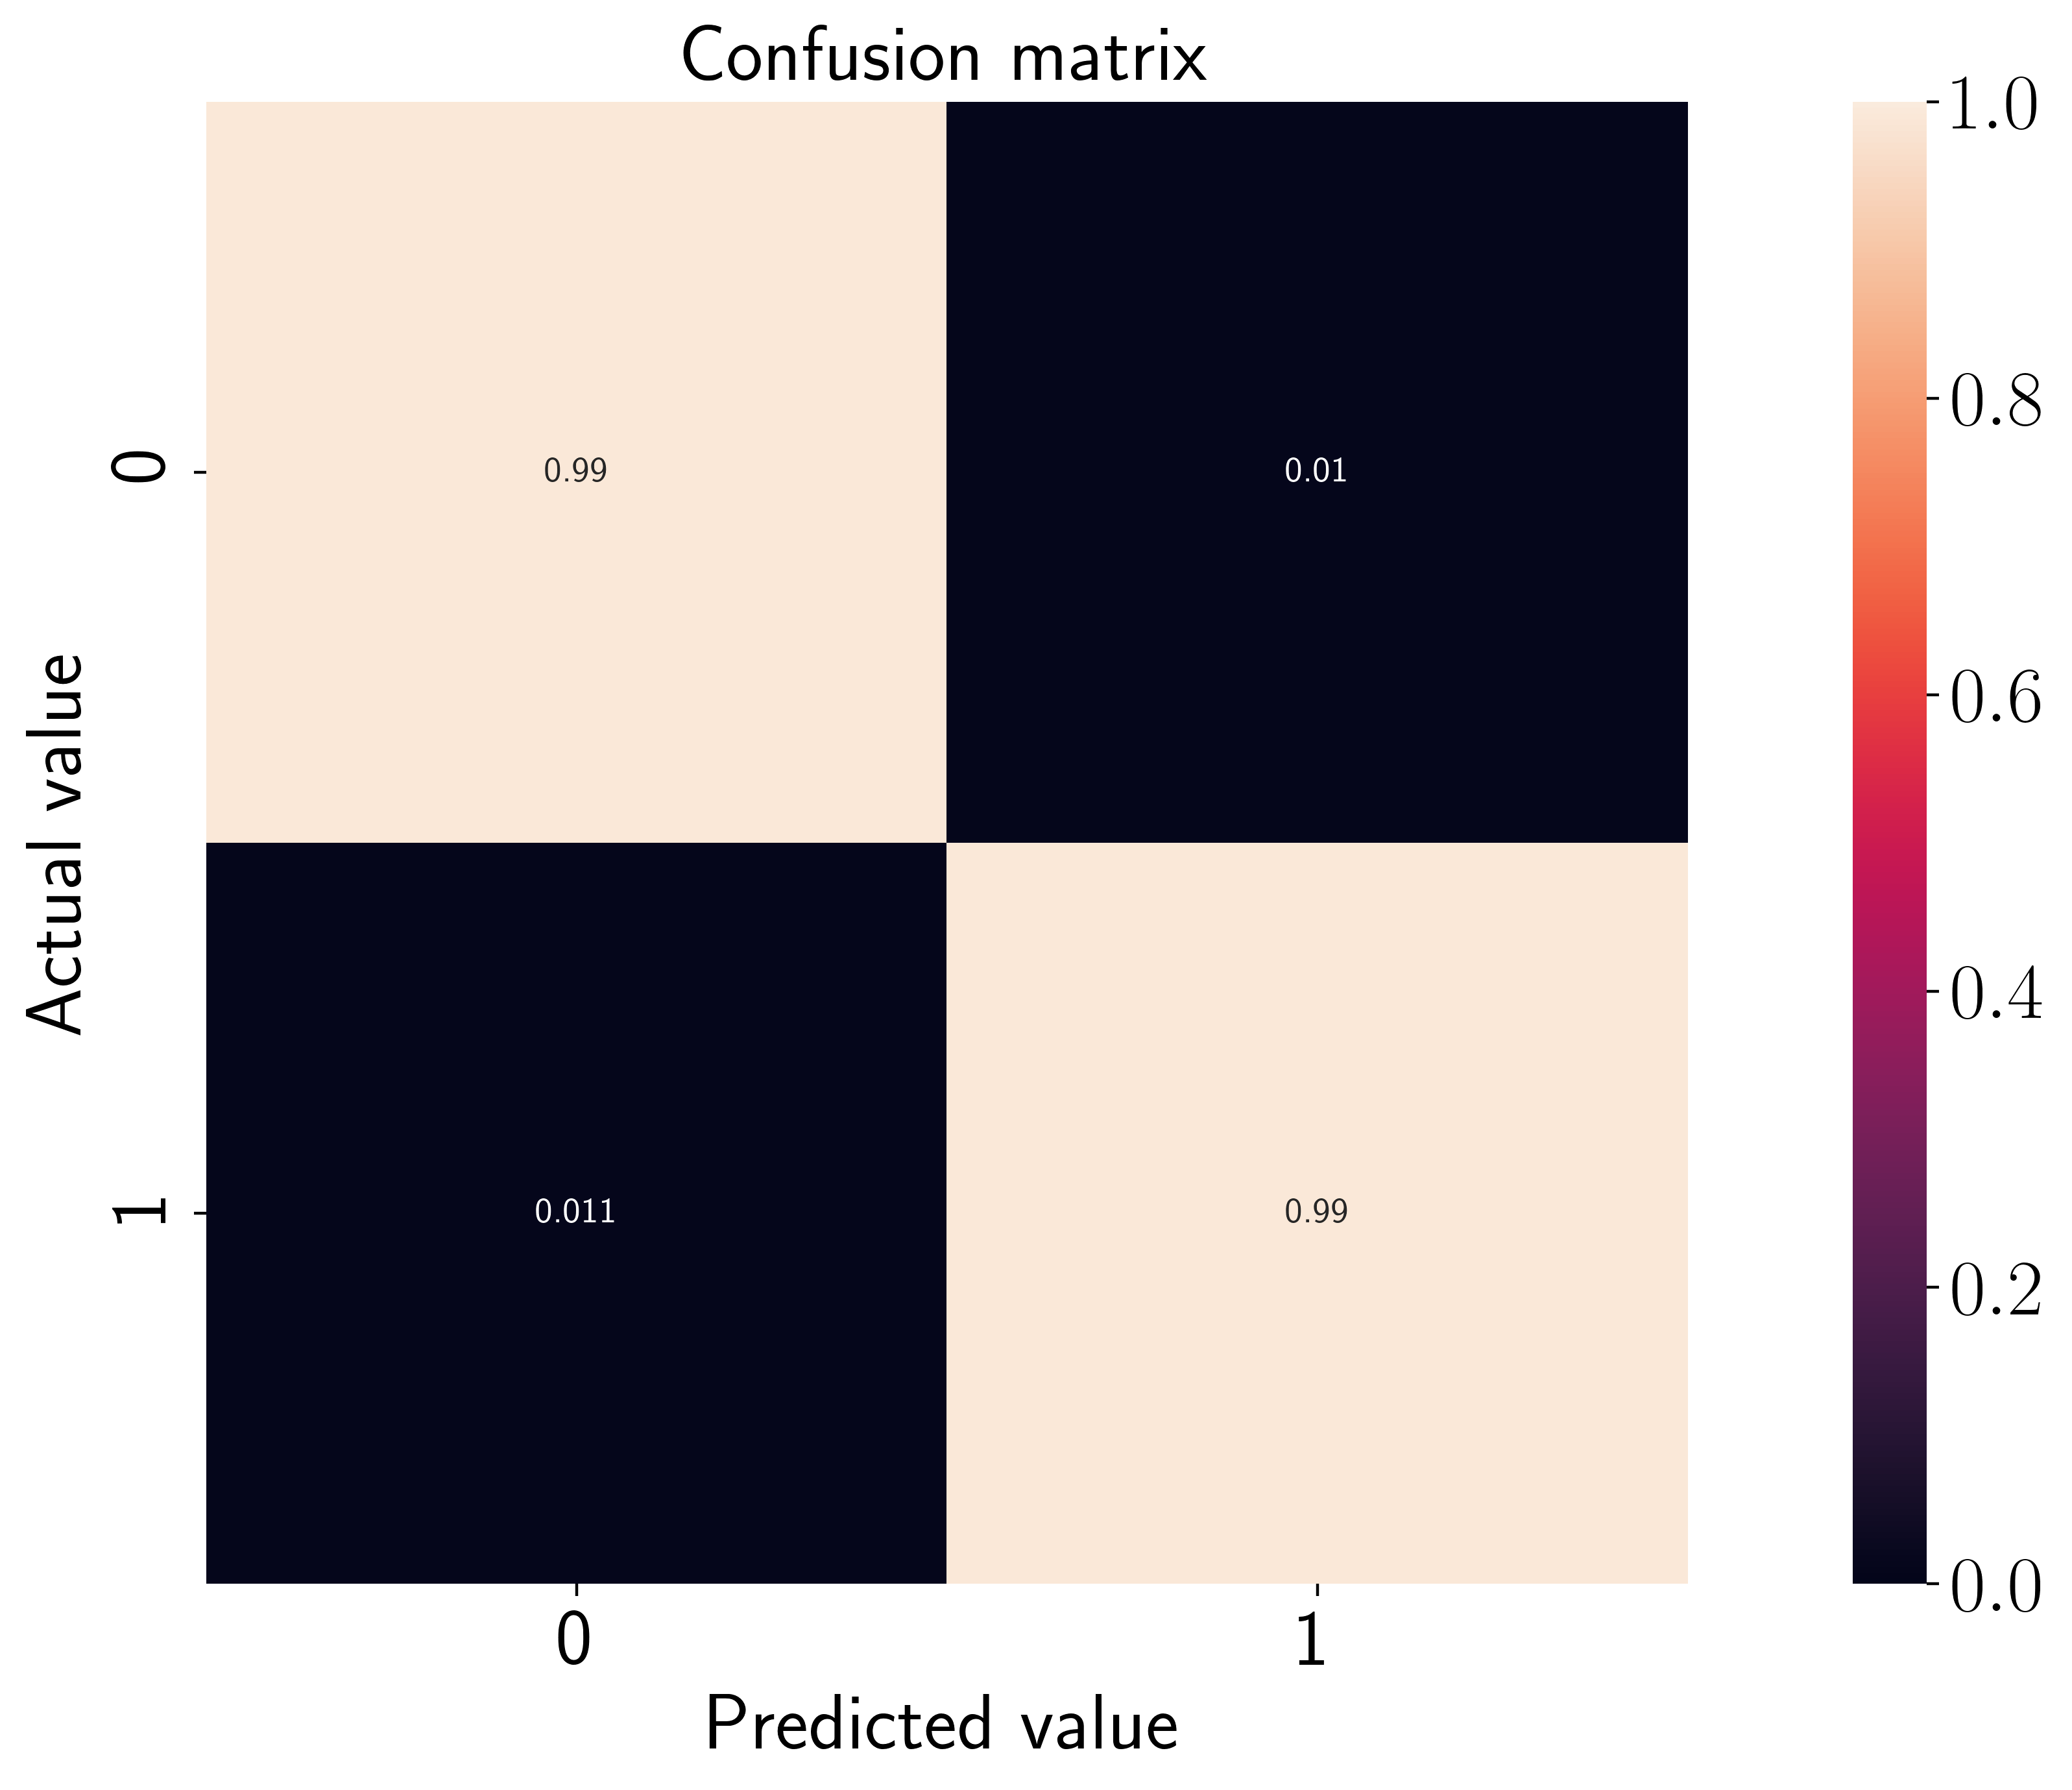

In [31]:
bias_test_vanilla = netVanilla.confusion_matrix(X_validate.T, np.array([c_validate]).T)
bias_test_adam = netAdam.confusion_matrix(X_validate.T, np.array([c_validate]).T)

## Comments

### Imbalanced Dataset
In this notebook, we have used a very idealized dataset, which always has an equal amount of data points form each class. When using real data, this is rarely the case. If the dataset has a large overweight of one of the classes, there is a good chance that the network will be biased to classify most objects to this class, because it tends to be a good decision during training. This is one of many problems you can encounter when working with real datasets. An illustration of what can happen in the case of an imbalanced data set is provided below. In this example we only include $10$ blue datapoints, and $250$ red ones to create an artificially imbalanced data set.

In [32]:
I = 500  # Number of datapoints

X_train, y_train = datasets.make_moons(I, random_state=100, noise=0.1)      
X_validate, y_validate = datasets.make_moons(I, random_state=30, noise=0.1)  

# Removing some of the blue datapoints 

blue = y_train == 0
red  = y_train == 1
y_blue = y_train[blue]
X_blue = X_train[blue]
y_red  = y_train[red]
X_red  = X_train[red]

y = y_blue[:10]
X = X_blue[:10]

X_train_new = np.concatenate((X,X_red), axis = 0 )
y_train_new = np.concatenate((y,y_red), axis = 0 )

y_train_new = np.reshape(y_train_new, (260,1))  # Change the shape to adapt it to the network.
y_validate = np.reshape(y_validate, (I,1))

imbalancedNet = Network(
    K=15,          # number of layers
    d=2,           # dimension of input
    I=260,         # number of datapoints
    num_iterations=1000,
    activation_functions_list=[tanh, tanh_derivative, sigmoid, sigmoid_derivative],
    gradient_descent_method=Plain_vanilla,
    gradient_descent_input=[], # using default values of the parameters
    data=[X_validate.T, y_validate, X_train_new.T, y_train_new],
)

In [33]:
imbalancedNet.train()

100%|██████████| 1000/1000 [00:03<00:00, 317.33it/s]


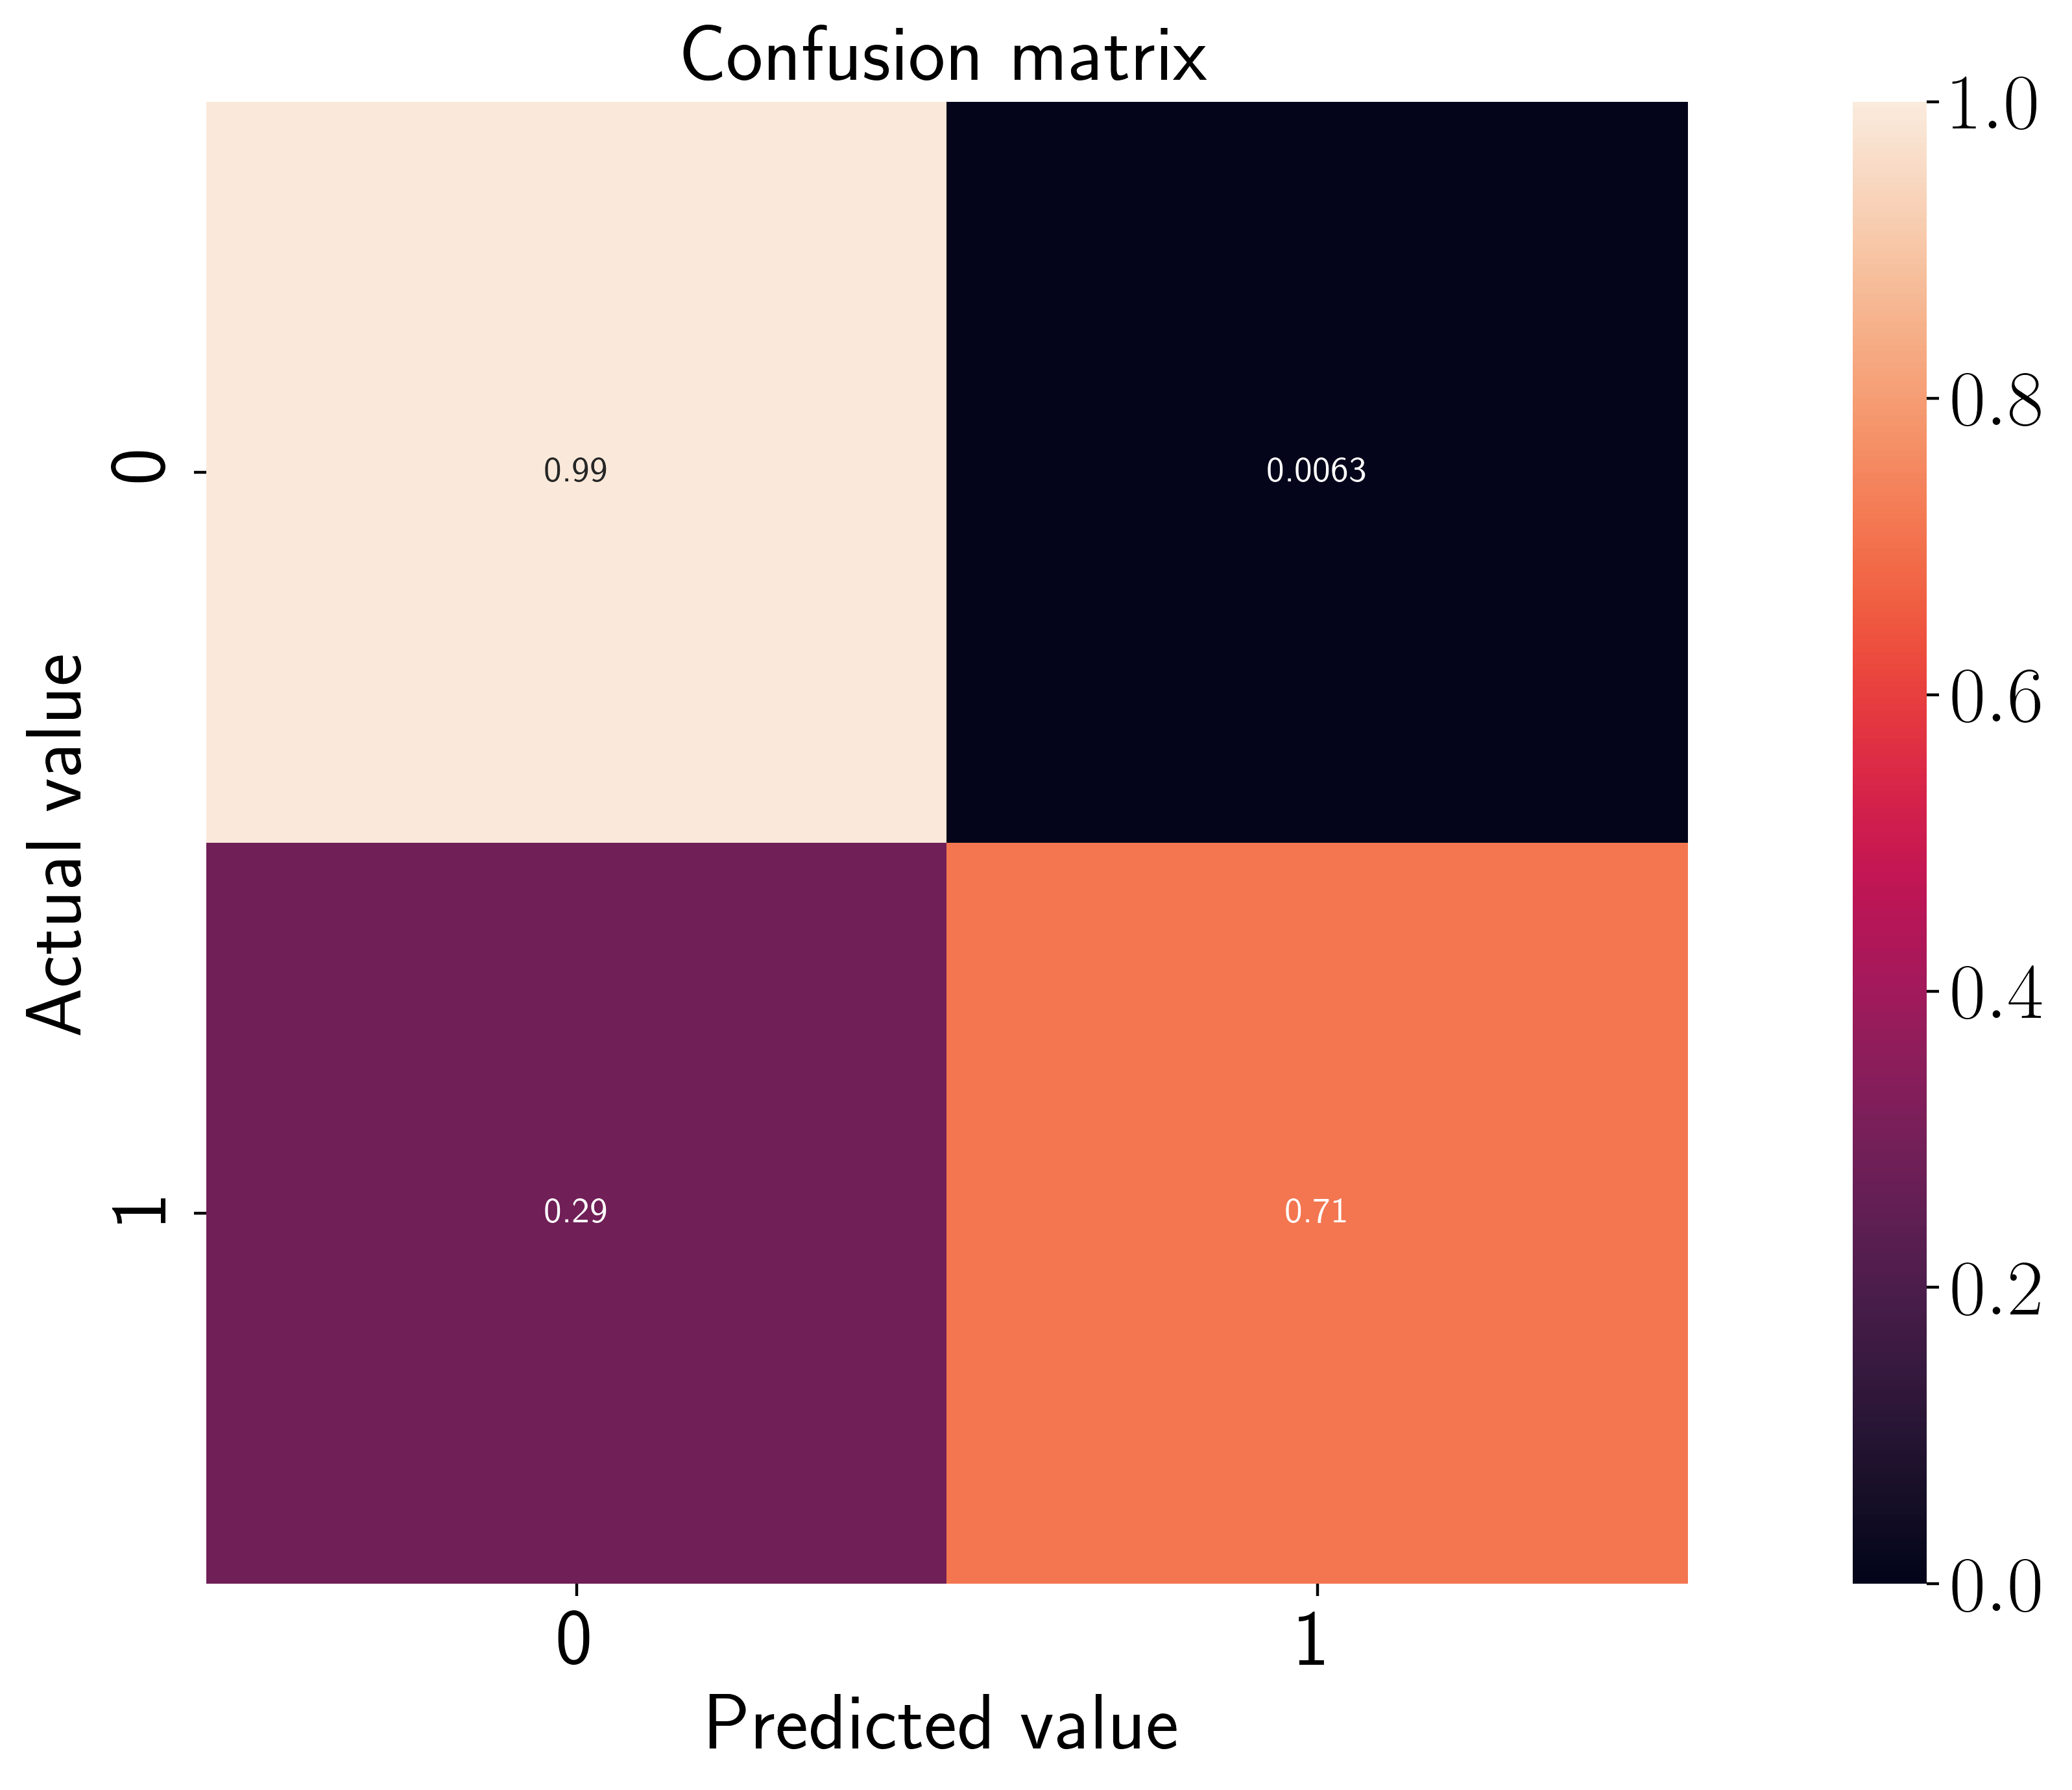

In [34]:
n = 10000 
X_validate, c_validate = datasets.make_moons(n,noise = 0.15)

bias_test_imbalanced = imbalancedNet.confusion_matrix(X_validate.T, np.array([c_validate]).T)

### Training, Validation and Test Set
In this notebook, we have only used training and validation sets. Normally, one would also use a test set. The training set is obviously used during the training of the network. The validation set is used to test the performance of the model *while developing* the network. This could be to for example find the best values for the number of layers, iterations and neurons in the network. When you are happy about the whole network and all its parameters, you do a final test with a test set. This is to ensure that the modifications made during the development also is suitable for unseen data. 

# The Next Step 
Even though the dataset in this notebook is a very ideal dataset, the theory can be applied to a wide range of problems. Making a machine learning model from scratch can be interesting and fun, but for more effective and complicated models, we recommend trying out some of the packages available for Python:


- <a href="https://www.tensorflow.org/overview">Getting started with Tensorflow</a>.
- <a href="https://pytorch.org/tutorials/">Getting started with PyTorch</a>.
- <a href="https://scikit-learn.org/stable/getting_started.html">Getting started with Scikit-learn</a>.

The <a href = "https://pandas.pydata.org/docs/getting_started/index.html"> Pandas </a> package is also very useful when working with large amounts of data, and most of the machine learning packages in Python is compatible with Pandas data frames.


Fully connected neural networks is a very popular type of machine learning, but there exist numerous different models, both within the neural networks category, but also models that use completly different structures.

- <a href = "https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/"> Long short term memory (LSTM) networks </a> can be used for e.g. speach recognition, and is specialized on finding patterns in time or order.
- <a href =  "https://www.geeksforgeeks.org/what-is-reinforcement-learning/"> Reinforcement learning </a> is a type of unsupervised machine learning method, that uses rewards during training instead of true values for each datapoint.
- <a href =  "https://towardsdatascience.com/understanding-random-forest-58381e0602d2"> Random forest </a> is a machine learning method that makes it easier to find out what variables are the most important for the classification or regression.
- <a href =  "https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148"> Logistic regression </a> is binary classifier that is known to be easy to implement and interperet, and can be a good place to start if you are interessed in the statistcs behind machine learning.
- <a href =  "https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47"> Support vector machine </a> can produce good accuracy for both classification and regression tasks with less computational power than e.g neural networks.
- <a href =  "https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1"> K-means </a> is an unsupervised method for finding patterns in a (unlabeled) dataset.

Footnotes <br>
$^1$ An ANN can also have less than three layers; A single-layer preceptron consist only of an outputlayer. <br>
$^2$ Not all networks have neurons that output values between 0 and 1. It is the range of the activation function that determines the scaling of the output from the neurons. <br>
$^3$ Or any other activation function. <br>

# References 
 <a name="biological_net">[1]</a> _Neural network_ https://en.wikipedia.org/wiki/Neural_network <br>
 <a name="activation_functions">[2]</a> _Understanding Activation Functions in Neural Networks_ https://medium.com/the-theory-of-everything/understanding-activation-functions-in-neural-networks-9491262884e0 <br>
 <a name="ann_training">[3]</a> _Activation functions in neural networks_ https://www.geeksforgeeks.org/activation-functions-neural-networks/ <br>
 <a name="ReLU">[4]</a> _A Practical Guide to ReLU_ https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7 <br>
 <a name="initialization_of_parameters">[5]</a> _Weight Initialization Techniques in Neural Networks_ https://towardsdatascience.com/weight-initialization-techniques-in-neural-networks-26c649eb3b78 
 
 The original report about the ResNet: <br>
 _Deep Residual Learning for Image Recognition_ https://arxiv.org/abs/1512.03385

# Appendix

## Derivation of gradient formulas

In the text we derived the gradients of $\mathcal{J}$ with respect to $\mu$ and $\omega$. We will here derive the two other gradients, and to this end we present a bit of new notation in order to handle the expressions more elegantly.

Let $H : \mathbb{R}^m \to \mathbb{R}^n$ be a function of $m$ variables, and let $\mathbf{x},\boldsymbol{\delta}$ be vectors in $\mathbb{R}^m$. The directional derivative of $H$ at $\mathbf{x}$ in the direction of $\boldsymbol{\delta}$ as 

$$
\frac{\text{d}}{\text{d} \epsilon} \biggr\lvert_{\epsilon = 0} H(\mathbf{x} + \epsilon \boldsymbol{\delta}) = \nabla H (\mathbf{x}) \cdot \boldsymbol{\delta} = \left\langle \frac{\partial H}{\partial \mathbf{x}} (\mathbf{x}), \boldsymbol{\delta} \right\rangle.
$$

Let us consider the change of $\mathcal{J}$ in the direction of $\delta W_k$. Since $\mathcal{J}$ depends only indirectly on $W_k$, through $\mathbf{Y}_K$, we will consider the change along the direction of $\delta \mathbf{Y}_K$ first

\begin{equation}\label{eq:del_J}
    \delta \mathcal{J} = \frac{\text{d}}{\text{d} \epsilon} \biggr\lvert_{\epsilon = 0} \mathcal{J}(\mathbf{Y}_K + \epsilon \delta \mathbf{Y}_K) = \left\langle \frac{\partial \mathcal{J}}{\partial \mathbf{Y}_K}, \delta \mathbf{Y}_K \right\rangle.
\end{equation}

Now, introduce $\mathbf{P}_K := \frac{\partial \mathcal{J}}{\partial \mathbf{Y}_K}$. Since we have 

\begin{equation}\label{eq:transf}
    \mathbf{Y}_K = \mathbf{Y}_{K-1} + h \sigma{\left( W_{K-1} \mathbf{Y}_{K-1} + b_{K-1} \right)},
\end{equation}

the change $\delta \mathbf{Y}_K$ is 

$$
    \delta \mathbf{Y}_K = \left( I +  h \frac{\partial \sigma}{\partial \mathbf{Y}} (W_{K-1} \mathbf{Y}_{K-1} + b_{K-1}) \right) \delta \mathbf{Y}_{K-1}.
$$

We can insert this into equation \eqref{eq:del_J}, and use the fact that $\langle v, Aw \rangle = \langle A^T v, w \rangle$ for arbitrary vectors $v\in \mathbb{R}^n, w \in \mathbb{R}^m$ and a matrix $A \in \mathbb{R}^{n\times m}$. Hence, 

\begin{align*}
    \delta \mathcal{J} &= \left\langle \mathbf{P}_K, \left( I +  h\frac{\partial \sigma}{\partial \mathbf{Y}} (W_{K-1} \mathbf{Y}_{K-1} + b_{K-1}) \right) \delta \mathbf{Y}_{K-1} \right\rangle \\
    &= \left\langle \mathbf{P}_K +  h\left[\frac{\partial \sigma}{\partial \mathbf{Y}} (W_{K-1} \mathbf{Y}_{K-1} + b_{K-1})\right]^T \mathbf{P}_K, \delta \mathbf{Y}_{K-1} \right\rangle.
\end{align*}

Therefore, we define generally 

\begin{equation}\label{eq:P_k-1_simple}
    \mathbf{P}_{k-1} = \mathbf{P}_k + h \left[ \frac{\partial \sigma}{\partial \mathbf{Y}} (W_{k-1} \mathbf{Y}_{k-1} + b_{k-1})\right]^T \mathbf{P}_k.
\end{equation}

This turns out to be exactly \eqref{eq:P_k-1}, that is 

$$
\mathbf{P}_{k-1} = \frac{\partial \mathcal{J}}{\partial \mathbf{Y}_{k-1}} = \mathbf{P}_k +  h W_{k-1}^{T} \cdot \left[ \sigma' \left(W_{k-1} \mathbf{Y}_{k-1} + b_{k-1} \right) \odot \mathbf{P}_{k}\right].
$$

We have thus arrived at $\delta \mathcal{J} = \langle \mathbf{P}_{K-1},\delta \mathbf{Y}_{K-1} \rangle$. By continuing the argument inductively, we will eventually find 

\begin{equation}\label{eq:del_J_compact}
    \delta \mathcal{J} = \langle \mathbf{P}_{k+1},\delta \mathbf{Y}_{k+1} \rangle.
\end{equation}

Since $\mathbf{Y}_{k+1} = \mathbf{Y}_{k} + h \sigma{\left( W_{k} \mathbf{Y}_{k} + b_{k} \right)},$ we can write 

\begin{equation}
    \delta \mathbf{Y}_{k+1} = h \frac{\partial \sigma}{\partial W} (W_{k} \mathbf{Y}_{k} + b_{k}) \delta W_k,
\end{equation}

which we can insert into equation \eqref{eq:del_J_compact} to get 

$$
    \delta \mathcal{J} = \left\langle h \left[ \frac{\partial \sigma}{\partial W} (W_{k} \mathbf{Y}_{k} + b_{k})\right]^T \mathbf{P}_{k+1}, \delta W_k \right\rangle.
$$

We can now conclude that the gradient of $\mathcal{J}$ with respect to $W_k$ is given as 

\begin{equation}\label{eq:delW}
    \frac{\partial \mathcal{J}}{\partial W_k} = h \left[ \frac{\partial \sigma}{\partial W} (W_{k} \mathbf{Y}_{k} + b_{k})\right]^T \mathbf{P}_{k+1}. 
\end{equation}

We note that $\mathbf{P}_k$ is needed to calculate $\mathbf{P}_{k-1}$, so we first calculate $\mathbf{P}$ for $k = K$, and then proceed backwards for all $k < K$. In an entirely similar fashion, we get 

\begin{equation}\label{eq:delb}
     \frac{\partial \mathcal{J}}{\partial b_k} = h \left[ \frac{\partial \sigma}{\partial b} (W_{k} \mathbf{Y}_{k} + b_{k})\right]^T \mathbf{P}_{k+1}.
\end{equation}

## Explicit formula for $\mathbf{P}_K$

To derive $\frac{\partial \mathcal{J}}{\partial \mathbf{Y}_K}$ we look at the following (and note that we suppress the index $K$)

$$
    \frac{\text{d}}{\text{d} \epsilon} \biggr\lvert_{\epsilon = 0} \mathcal{J}(\mathbf{Y} + \epsilon \delta \mathbf{Y}) = \frac{1}{2} \frac{\text{d}}{\text{d} \epsilon} \biggr\lvert_{\epsilon = 0} \left\langle
    \mathbf{Z}(\epsilon) - \mathbf{c}, \mathbf{Z}(\epsilon) - \mathbf{c}
    \right\rangle
    = \left\langle \mathbf{Z}(0) - \mathbf{c}, \mathbf{Z}^\prime(0) \right\rangle,
$$

where 

$$
\mathbf{Z}(\epsilon) = \eta\left( \left[\mathbf{Y} + \epsilon \delta \mathbf{Y})\right]^T \omega + \mu \mathbf{1}\right).
$$

By the chain-rule, we find 

$$
\mathbf{Z}^\prime(0) = \eta^\prime \left( \mathbf{Y}^T \omega + \mu \mathbf{1}\right) \delta \mathbf{Y}^T \omega.
$$

It then follows that 

$$
    \left\langle \mathbf{Z}(0) - \mathbf{c}, \mathbf{Z}^\prime(0) \right\rangle = \left\langle \omega \left[ (\mathbf{Z} - \mathbf{c}) \odot \eta^\prime \left( \mathbf{Y}^T \omega + \mu \mathbf{1}\right) \right]^T, \delta \mathbf{Y}  \right\rangle,
$$

and the expression for $\frac{\partial \mathcal{J}}{\partial \mathbf{Y}_K}$ follows. 

## Derivation of $\mathbf{P}_{k-1}$

To justify the claim that \eqref{eq:P_k-1} follows from \eqref{eq:P_k-1_simple} it suffices to show that 

$$
    \left[ \frac{\partial \sigma}{\partial \mathbf{Y}} (W_{k-1} \mathbf{Y}_{k-1} + b_{k-1})\right]^T \mathbf{P}_k = W_{k-1}^{T} \cdot \left[ \sigma' \left(W_{k-1} \mathbf{Y}_{k-1} + b_{k-1} \right) \odot \mathbf{P}_{k}\right].
$$

We will in the following suppress the index of the layers, and reserve index for "components". 

\begin{align*}
    \left\langle \left[ \frac{\partial \sigma}{\partial \mathbf{Y}} (\cdot) \right]^T \mathbf{P}, \delta \mathbf{Y} \right\rangle &= \left\langle \mathbf{P}, \frac{\partial \sigma}{\partial \mathbf{Y}} (\cdot) \delta \mathbf{Y} \right\rangle = \left\langle \mathbf{P}, \frac{\text{d}}{\text{d}\epsilon} \biggr\lvert_{\epsilon = 0} \sigma (W \left( \mathbf{Y} + \epsilon \delta\mathbf{Y} \right) + b ) \right\rangle \\
    &= \sum_{i,j,k} \mathbf{P}_{ij} \sigma^\prime \left( (W \mathbf{Y} + b)_{ij}\right) W_{ik} \delta \mathbf{Y}_{kj}  = \sum_{k,j} \delta \mathbf{Y}_{kj} \sum_{i} W_{ki}^{T} \left[ \mathbf{P} \odot \sigma^\prime(W\mathbf{Y} + b) \right]_{ij} \\
    &= \left\langle W^T \left[ \sigma^\prime (W\mathbf{Y} + b) \odot \mathbf{P} \right], \delta \mathbf{Y} \right\rangle.
\end{align*}

## Gradients with respect to $W_k$ and $b_k$

To get the final equations for $\frac{\partial \mathcal{J}}{\partial W_k}$, we start from \eqref{eq:delW}, and again we suppress the layer index. We then find 

\begin{align*}
    \left\langle \frac{\partial \mathcal{J}}{\partial W}, \delta W \right\rangle &= \left\langle h \left[ \frac{\partial \sigma}{\partial W} (W \mathbf{Y} + b)\right]^T \mathbf{P}, \delta W \right\rangle = h \left\langle \mathbf{P}, \frac{\partial \sigma}{\partial W} (W \mathbf{Y} + b) \delta W \right\rangle\\
    &= h \left\langle \mathbf{P}, \frac{\text{d}}{\text{d}\epsilon} \biggr\lvert_{\epsilon = 0} \sigma ((W + \epsilon \delta W) \mathbf{Y} + b ) \right\rangle \\
    &= h \sum_{i,j,k} \mathbf{P}_{ij} \sigma^\prime ((W\mathbf{Y} + b)_{ij}) \delta W_{ik} \mathbf{Y}_{kj} = h \sum_{i,k} \delta W_{ik} \sum_{j} \left[ \mathbf{P} \odot \sigma^\prime (W\mathbf{Y} + b)\right]_{ij} \mathbf{Y}_{jk}^T \\
    &= h \left\langle \left[ \mathbf{P} \odot \sigma^\prime (W\mathbf{Y} + b) \right] \mathbf{Y}^T, \delta W \right\rangle.
\end{align*}

This shows the final formula for $\frac{\partial \mathcal{J}}{\partial W_k}$. We omit the proof of the formula for $\frac{\partial \mathcal{J}}{\partial b_k}$ since it is derived in a very similar manner.